In [1]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import pandas as pd
import matplotlib as mpl
import dask
import dask.dataframe as dd
from asyncio import CancelledError
from dask.delayed import delayed
from dask.distributed import Client
from cycler import cycler
import geopandas as gpd
from IPython.display import clear_output, HTML, display, Audio

In [35]:
framerate = 4410
play_time_seconds = 3

t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)
audio_data = np.sin(4*np.pi*300*t) + np.sin(4*np.pi*240*t)

In [3]:
default_colors = ['#00c6ff', '#0078ff', '#dd2a7b']
mpl.rcParams['axes.prop_cycle'] = cycler('color', default_colors)
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['figure.titlesize'] = 22
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['legend.title_fontsize'] = 18

# pd.set_option('display.max_colwidth', None)

# Methodology

In exploring dataset for this report, the group analyzed a high population density dataset amounting to a total of over 8.12Gb. In order to handle this amount of memory, the group used distributed dask clustering to handle a big amount of data surpassing the capability of the local machine/client's memory. The general workflow for the formation of this report is shown in the figure below.

1. Data Extraction
2. Data Processing
3. Exploratory Data Analysis


<center><img src="methodology.JPG" alt="Methodology"/></center>

<center><strong>Fig.1 Methodology </strong></center>

# Data Description

<center><img src="data_desc.JPG" alt="Methodology" width='750px'/></center>


<center><strong>Fig.2 Data Description </strong></center>

| Country | Alpha-3 code   |
|---------|----------------|
| GBR     | United Kingdom |
| FRA     | France         |
| ITA     | Italy          |
| ESP     | Spain          |
| PRT     | Portugal       |
| CHE     | Switzerland    |
| GRC     | Greece         |
| DEU     | Germany        |
| NLD     | Netherlands    |
| POL     | Poland         |
| BEL     | Belgium        |
| AUT     | Austria        |
| ISL     | Iceland        |
| HRV     | Croatia        |
| CZE     | Czechia        |
| ROU     | Romania        |
| UKR     | Ukraine        |
| HUN     | Hungary        |
| ALB     | Albania        |
| SVK     | Slovakia       |
| MNE     | Montenegro     |
| MDA     | Moldova        |
| SRB     | Serbia         |
| BLR     | Belarus        |


<center><strong>Fig.3 Country Code </strong></center>

# Data Extraction

The collected used in this report were collected from the High Resolution Population Density Maps + Demographic Estimates by CIESIN and Facebook in the AWS open data registry.

In [16]:
# Uncomment to unzip shp files
# !unzip shp.zip

Archive:  shp.zip
  inflating: de_1km.shp              
  inflating: de_1km.shx              
  inflating: gb_1km.shp              
  inflating: gb_1km.shx              


## Dask Distributed Cluster

In [4]:
client = Client('172.31.47.101:8786')
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.8/site-packages/distributed/client.py:1129: VersionMismatchWarning: Mismatched versions found

+---------+---------------+---------------+---------------+
| Package | client        | scheduler     | workers       |
+---------+---------------+---------------+---------------+
| python  | 3.8.2.final.0 | 3.8.2.final.0 | 3.8.5.final.0 |
+---------+---------------+---------------+---------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


In [5]:
client

Client Scheduler: tcp://172.31.47.101:8786 Dashboard: http://172.31.47.101:8787/status,Cluster Workers: 3 Cores: 6 Memory: 25.04 GB


In [9]:
def get_path(country):
    """Return country CSV S3 path"""
    return dict(total_pop=('s3://dataforgood-fb-data/csv/month=2019-06'
                           f'/country={country}/type=total_population'
                           f'/{country}_total_population.csv.gz'),
                child=('s3://dataforgood-fb-data/csv/month=2019-06'
                             f'/country={country}/type=children_under_five'
                             f'/{country}_children_under_five.csv.gz'),
                elder=('s3://dataforgood-fb-data/csv/month=2019-06'
                               f'/country={country}/type=elderly_60_plus'
                               f'/{country}_elderly_60_plus.csv.gz'),
                men=('s3://dataforgood-fb-data/csv/month=2019-06'
                     f'/country={country}/type=men'
                     f'/{country}_men.csv.gz'),
                women=('s3://dataforgood-fb-data/csv/month=2019-06'
                       f'/country={country}/type=women'
                       f'/{country}_women.csv.gz'),
                reprod=('s3://dataforgood-fb-data/csv/month=2019-06'
                        f'/country={country}'
                        '/type=women_of_reproductive_age_15_49'
                        f'/{country}_women_of_'
                        'reproductive_age_15_49.csv.gz'),
                youth=('s3://dataforgood-fb-data/csv/month=2019-06'
                        f'/country={country}/type=youth_15_24'
                        f'/{country}_youth_15_24.csv.gz')
            )

In [6]:
# List of countries to analyze
countries = ['DEU',
             'GBR',
             'FRA',
             'ITA',
             'ESP',
             'PRT',
             'CHE',
             'GRC',
             'NLD',
             'POL',
             'BEL',
             'AUT',
             'ISL',
             'HRV',
             'CZE',
             'ROU',
             'UKR',
             'HUN',
             'ALB',
             'SVK',
             'MNE',
             'MDA',
             'SRB',
             'BLR']

In [7]:
df_countries_child = dict()
df_countries_youth = dict()
df_countries_elder = dict()

### Child

In [11]:
for country in countries:
    print('Extracting data from {}'.format(country))
    dfs_child = [delayed(pd.read_csv)(get_path(country)['child'],
                                     encoding='utf-8', sep='\t',
                                     compression='gzip')]
    print('Converting to DataFrame {}'.format(country))
    
    try:
        df_child = dd.from_delayed(dfs_child)
    except CancelledError:
        df_child = dd.from_delayed(dfs_child)
        
    print('Repartition {}'.format(country))
    df_child = df_child.repartition(npartitions=100)
    df_countries_child[country] = df_child
    del dfs_child
    del df_child
clear_output()
print('Done')

Done


### Youth

In [10]:
for country in countries:
    print('Extracting data from {}'.format(country))
    dfs_youth = [delayed(pd.read_csv)(get_path(country)['youth'],
                                     encoding='utf-8', sep='\t',
                                     compression='gzip')]
    print('Converting to DataFrame {}'.format(country))
    
    try:
        df_youth = dd.from_delayed(dfs_youth)
    except CancelledError:
        df_youth = dd.from_delayed(dfs_youth)
        
    print('Repartition {}'.format(country))
    df_youth = df_youth.repartition(npartitions=100)
    df_countries_youth[country] = df_youth
    del dfs_youth
    del df_youth
clear_output()
print('Done')

Done


### Elder

In [12]:
for country in countries:
    print('Extracting data from {}'.format(country))
    dfs_elder = [delayed(pd.read_csv)(get_path(country)['elder'],
                                     encoding='utf-8', sep='\t',
                                     compression='gzip')]
    print('Converting to DataFrame {}'.format(country))
    
    try:
        df_elder = dd.from_delayed(dfs_elder)
    except CancelledError:
        df_elder = dd.from_delayed(dfs_elder)
        
    print('Repartition {}'.format(country))
    df_elder = df_elder.repartition(npartitions=100)
    df_countries_elder[country] = df_elder
    del dfs_elder
    del df_elder
clear_output()
print('Done')

Done


# Data Preprocessing

To compare the population of each country, the group merged all the datasets per category to compare different countries. We added a new column country and determine the total number of people per 30 sqm of each country. We also group the data per by 2 degrees latitude and longitude for compuational efficieny.

In [100]:
def add_features(df, country):
    """Return dataframe with required column columns"""
    df = df.copy()
    # Group data by 2 degrees
    step = 0.2
    to_bin = lambda x: np.floor(x / step) * step
    df["latbin"] = df.latitude.map(to_bin)
    df["lonbin"] = df.longitude.map(to_bin)
    df = df.groupby(['latbin', 'lonbin'])['population'].sum().to_frame()
    df['country'] = country
    return df

In [37]:
Audio(audio_data, rate=framerate, autoplay=True)

### Child

In [102]:
df_child = dd.concat([add_features(ddf, country)
                      for country, ddf in df_countries_child.items()],
                     axis=0)

df_child.count().compute()

### Youth

In [104]:
df_youth = dd.concat([add_features(ddf, country)
                      for country, ddf in df_countries_youth.items()],
                     axis=0)

df_youth.count().compute()

### Elder

In [105]:
df_elder = dd.concat([add_features(ddf, country)
                      for country, ddf in df_countries_elder.items()],
                     axis=0)

In [ ]:
df_elder.count().compute()

# Exploratory Data Analysis

## Population density based on Age

In [107]:
total_pop_child = df_child.groupby(['country']).population.sum().compute()
total_pop_child.sort_values(inplace=True)
total_pop_youth = df_youth.groupby(['country']).population.sum().compute()
total_pop_youth.sort_values(inplace=True)
total_pop_elder = df_elder.groupby(['country']).population.sum().compute()
total_pop_elder.sort_values(inplace=True)

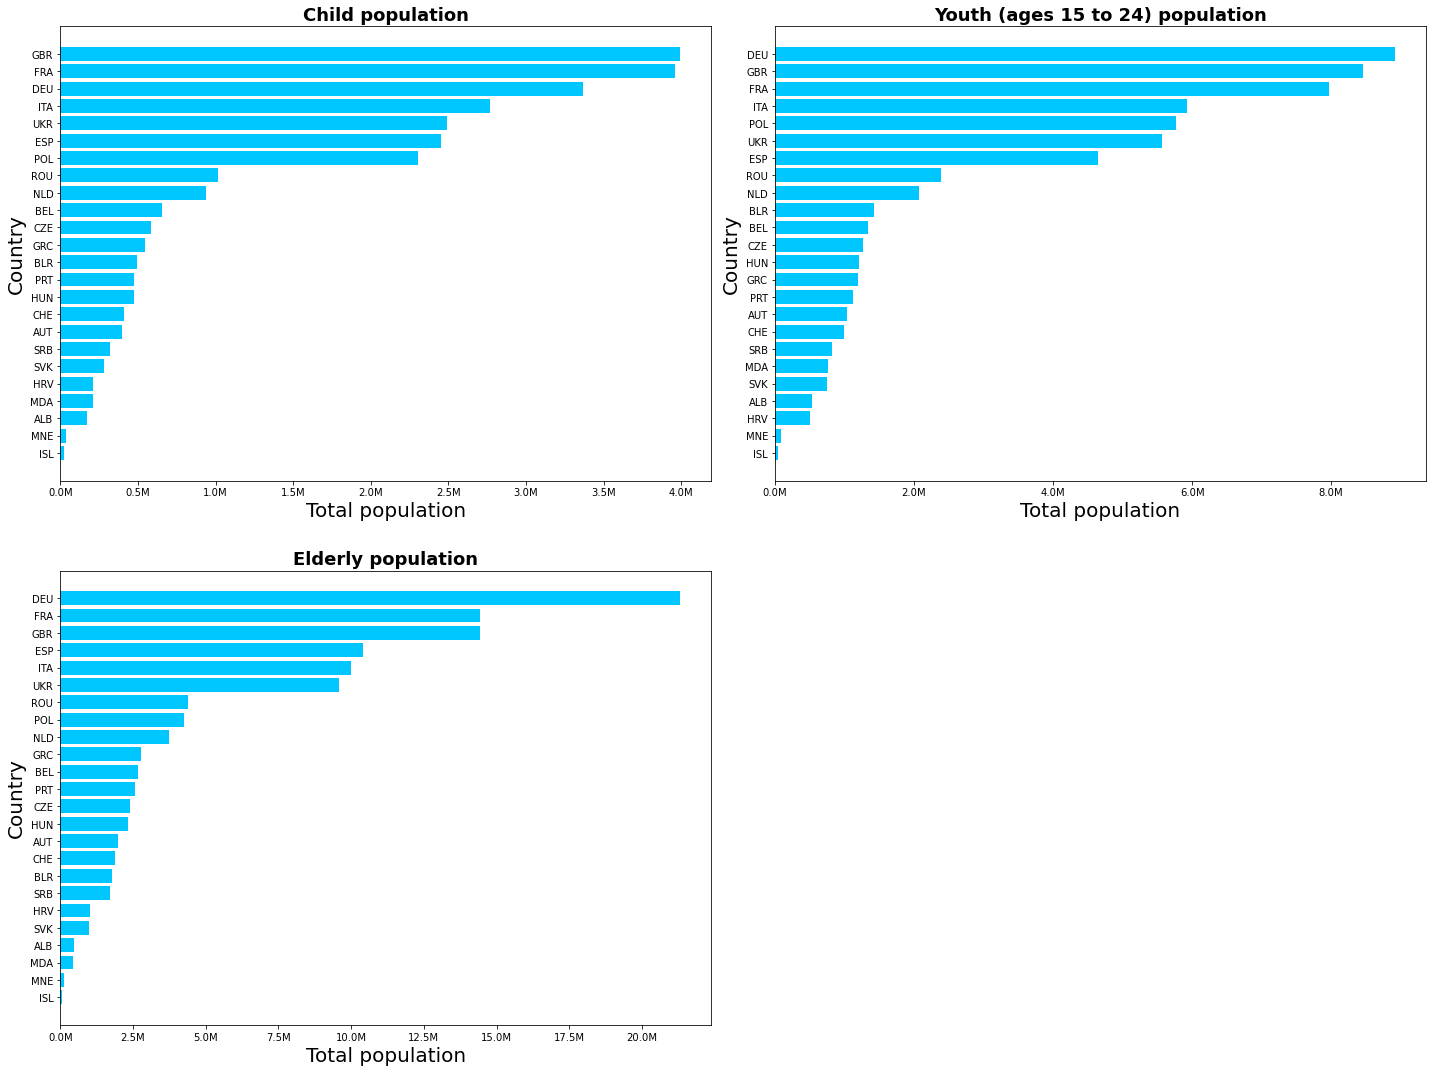

In [109]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(20, 15))

ax0 = plt.subplot(221)
ax1 = plt.subplot(222)
ax2 = plt.subplot(223)

y_child = total_pop_child.index
x_child = total_pop_child.values

y_youth = total_pop_youth.index
x_youth = total_pop_youth.values

y_elder = total_pop_elder.index
x_elder = total_pop_elder.values

# Plot data
ax0.barh(y_child, x_child)
ax0.set_title('Child population')
ax0.set_ylabel('Country')
ax0.set_xlabel('Total population')

ax1.barh(y_youth, x_youth)
ax1.set_title('Youth (ages 15 to 24) population')
ax1.set_ylabel('Country')
ax1.set_xlabel('Total population')

ax2.barh(y_elder, x_elder)
ax2.set_title('Elderly population')
ax2.set_ylabel('Country')
ax2.set_xlabel('Total population')

# Change ticks
xlabels = [f'{x:.1f}M' for x in ax0.get_xticks()/1e6]
ax0.set_xticklabels(xlabels)

xlabels = [f'{x:.1f}M' for x in ax1.get_xticks()/1e6]
ax1.set_xticklabels(xlabels)

xlabels = [f'{x:.1f}M' for x in ax2.get_xticks()/1e6]
ax2.set_xticklabels(xlabels)

plt.tight_layout(h_pad=3)
plt.show()

## Geospatial analysis

In [111]:
from keplergl import KeplerGl

In [131]:
map_deu = KeplerGl(height=600, width=800)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [116]:
ddf_deu = add_features(df_countries_youth['DEU'],
                       'DEU').population.reset_index().persist()

In [118]:
Audio(audio_data, rate=framerate, autoplay=True)

In [138]:
gdf_deu = gpd.GeoDataFrame(ddf_deu.compute(),
                           geometry=gpd.points_from_xy(
                               ddf_deu.lonbin.compute(),
                               ddf_deu.latbin.compute()))

In [139]:
gdf_deu

,latbin,lonbin,population,geometry
0,47.6,7.4,3029.275953,POINT (7.40000 47.60000)
1,47.6,7.6,11851.686994,POINT (7.60000 47.60000)
2,47.6,8.4,1907.330596,POINT (8.40000 47.60000)
3,47.6,8.8,11774.657328,POINT (8.80000 47.60000)
4,47.6,9.6,9649.097927,POINT (9.60000 47.60000)
...,...,...,...,...
1288,47.2,10.0,6.744687,POINT (10.00000 47.20000)
1289,52.8,14.2,1.243772,POINT (14.20000 52.80000)
1290,54.6,13.4,12.547605,POINT (13.40000 54.60000)
1291,54.2,13.8,1.333904,POINT (13.80000 54.20000)


In [140]:
map_deu.add_data(data=gdf_deu, name="population")

In [143]:
map_deu

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'gy4fobb', 'type': …

In [142]:
HTLM('''<html><head>


<!-- Load require.js. Delete this if your page already loads require.js -->
<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.4/require.min.js" integrity="sha256-Ae2Vz/4ePdIu6ZyI/5ZGsYnb+m0JlOmKPjt6XZ9JJkA=" crossorigin="anonymous"></script>
<script src="https://unpkg.com/@jupyter-widgets/html-manager@*/dist/embed-amd.js" crossorigin="anonymous"></script>
<script type="application/vnd.jupyter.widget-state+json">
{
    "version_major": 2,
    "version_minor": 0,
    "state": {
        "9e97cd2437534ab6abefe98e91994528": {
            "model_name": "LayoutModel",
            "model_module": "@jupyter-widgets/base",
            "model_module_version": "1.2.0",
            "state": {}
        },
        "1230f59b83f748a483a1db9c106d768a": {
            "model_name": "KeplerGlModal",
            "model_module": "keplergl-jupyter",
            "model_module_version": "^0.2.1",
            "state": {
                "_model_module_version": "^0.2.1",
                "_view_module_version": "^0.2.1",
                "config": {
                    "version": "v1",
                    "config": {
                        "visState": {
                            "filters": [],
                            "layers": [
                                {
                                    "id": "lxnj54k",
                                    "type": "geojson",
                                    "config": {
                                        "dataId": "Germany Population",
                                        "label": "Germany Population",
                                        "color": [
                                            183,
                                            136,
                                            94
                                        ],
                                        "columns": {
                                            "geojson": "geometry"
                                        },
                                        "isVisible": true,
                                        "visConfig": {
                                            "opacity": 0.8,
                                            "strokeOpacity": 0.8,
                                            "thickness": 0.5,
                                            "strokeColor": null,
                                            "colorRange": {
                                                "name": "Global Warming",
                                                "type": "sequential",
                                                "category": "Uber",
                                                "colors": [
                                                    "#5A1846",
                                                    "#900C3F",
                                                    "#C70039",
                                                    "#E3611C",
                                                    "#F1920E",
                                                    "#FFC300"
                                                ]
                                            },
                                            "strokeColorRange": {
                                                "name": "Global Warming",
                                                "type": "sequential",
                                                "category": "Uber",
                                                "colors": [
                                                    "#5A1846",
                                                    "#900C3F",
                                                    "#C70039",
                                                    "#E3611C",
                                                    "#F1920E",
                                                    "#FFC300"
                                                ]
                                            },
                                            "radius": 10,
                                            "sizeRange": [
                                                0,
                                                10
                                            ],
                                            "radiusRange": [
                                                0,
                                                50
                                            ],
                                            "heightRange": [
                                                0,
                                                500
                                            ],
                                            "elevationScale": 5,
                                            "stroked": false,
                                            "filled": true,
                                            "enable3d": false,
                                            "wireframe": false
                                        },
                                        "hidden": false,
                                        "textLabel": [
                                            {
                                                "field": null,
                                                "color": [
                                                    255,
                                                    255,
                                                    255
                                                ],
                                                "size": 18,
                                                "offset": [
                                                    0,
                                                    0
                                                ],
                                                "anchor": "start",
                                                "alignment": "center"
                                            }
                                        ]
                                    },
                                    "visualChannels": {
                                        "colorField": null,
                                        "colorScale": "quantile",
                                        "sizeField": null,
                                        "sizeScale": "linear",
                                        "strokeColorField": null,
                                        "strokeColorScale": "quantile",
                                        "heightField": null,
                                        "heightScale": "linear",
                                        "radiusField": null,
                                        "radiusScale": "linear"
                                    }
                                }
                            ],
                            "interactionConfig": {
                                "tooltip": {
                                    "fieldsToShow": {
                                        "Germany Population": [
                                            {
                                                "name": "population",
                                                "format": null
                                            }
                                        ]
                                    },
                                    "compareMode": false,
                                    "compareType": "absolute",
                                    "enabled": true
                                },
                                "brush": {
                                    "size": 0.5,
                                    "enabled": false
                                },
                                "geocoder": {
                                    "enabled": false
                                },
                                "coordinate": {
                                    "enabled": false
                                }
                            },
                            "layerBlending": "normal",
                            "splitMaps": [],
                            "animationConfig": {
                                "currentTime": null,
                                "speed": 1
                            }
                        },
                        "mapState": {
                            "bearing": 0,
                            "dragRotate": false,
                            "latitude": 50.27447841744856,
                            "longitude": 8.153710799421773,
                            "pitch": 0,
                            "zoom": 5.337536589990779,
                            "isSplit": false
                        },
                        "mapStyle": {
                            "styleType": "dark",
                            "topLayerGroups": {},
                            "visibleLayerGroups": {
                                "label": true,
                                "road": true,
                                "border": false,
                                "building": true,
                                "water": true,
                                "land": true,
                                "3d building": false
                            },
                            "threeDBuildingColor": [
                                9.665468314072013,
                                17.18305478057247,
                                31.1442867897876
                            ],
                            "mapStyles": {}
                        }
                    }
                },
                "data": {
                    "Germany Population": {
                        "index": [
                            0,
                            1,
                            2,
                            3,
                            4,
                            5,
                            6,
                            7,
                            8,
                            9,
                            10,
                            11,
                            12,
                            13,
                            14,
                            15,
                            16,
                            17,
                            18,
                            19,
                            20,
                            21,
                            22,
                            23,
                            24,
                            25,
                            26,
                            27,
                            28,
                            29,
                            30,
                            31,
                            32,
                            33,
                            34,
                            35,
                            36,
                            37,
                            38,
                            39,
                            40,
                            41,
                            42,
                            43,
                            44,
                            45,
                            46,
                            47,
                            48,
                            49,
                            50,
                            51,
                            52,
                            53,
                            54,
                            55,
                            56,
                            57,
                            58,
                            59,
                            60,
                            61,
                            62,
                            63,
                            64,
                            65,
                            66,
                            67,
                            68,
                            69,
                            70,
                            71,
                            72,
                            73,
                            74,
                            75,
                            76,
                            77,
                            78,
                            79,
                            80,
                            81,
                            82,
                            83,
                            84,
                            85,
                            86,
                            87,
                            88,
                            89,
                            90,
                            91,
                            92,
                            93,
                            94,
                            95,
                            96,
                            97,
                            98,
                            99,
                            100,
                            101,
                            102,
                            103,
                            104,
                            105,
                            106,
                            107,
                            108,
                            109,
                            110,
                            111,
                            112,
                            113,
                            114,
                            115,
                            116,
                            117,
                            118,
                            119,
                            120,
                            121,
                            122,
                            123,
                            124,
                            125,
                            126,
                            127,
                            128,
                            129,
                            130,
                            131,
                            132,
                            133,
                            134,
                            135,
                            136,
                            137,
                            138,
                            139,
                            140,
                            141,
                            142,
                            143,
                            144,
                            145,
                            146,
                            147,
                            148,
                            149,
                            150,
                            151,
                            152,
                            153,
                            154,
                            155,
                            156,
                            157,
                            158,
                            159,
                            160,
                            161,
                            162,
                            163,
                            164,
                            165,
                            166,
                            167,
                            168,
                            169,
                            170,
                            171,
                            172,
                            173,
                            174,
                            175,
                            176,
                            177,
                            178,
                            179,
                            180,
                            181,
                            182,
                            183,
                            184,
                            185,
                            186,
                            187,
                            188,
                            189,
                            190,
                            191,
                            192,
                            193,
                            194,
                            195,
                            196,
                            197,
                            198,
                            199,
                            200,
                            201,
                            202,
                            203,
                            204,
                            205,
                            206,
                            207,
                            208,
                            209,
                            210,
                            211,
                            212,
                            213,
                            214,
                            215,
                            216,
                            217,
                            218,
                            219,
                            220,
                            221,
                            222,
                            223,
                            224,
                            225,
                            226,
                            227,
                            228,
                            229,
                            230,
                            231,
                            232,
                            233,
                            234,
                            235,
                            236,
                            237,
                            238,
                            239,
                            240,
                            241,
                            242,
                            243,
                            244,
                            245,
                            246,
                            247,
                            248,
                            249,
                            250,
                            251,
                            252,
                            253,
                            254,
                            255,
                            256,
                            257,
                            258,
                            259,
                            260,
                            261,
                            262,
                            263,
                            264,
                            265,
                            266,
                            267,
                            268,
                            269,
                            270,
                            271,
                            272,
                            273,
                            274,
                            275,
                            276,
                            277,
                            278,
                            279,
                            280,
                            281,
                            282,
                            283,
                            284,
                            285,
                            286,
                            287,
                            288,
                            289,
                            290,
                            291,
                            292,
                            293,
                            294,
                            295,
                            296,
                            297,
                            298,
                            299,
                            300,
                            301,
                            302,
                            303,
                            304,
                            305,
                            306,
                            307,
                            308,
                            309,
                            310,
                            311,
                            312,
                            313,
                            314,
                            315,
                            316,
                            317,
                            318,
                            319,
                            320,
                            321,
                            322,
                            323,
                            324,
                            325,
                            326,
                            327,
                            328,
                            329,
                            330,
                            331,
                            332,
                            333,
                            334,
                            335,
                            336,
                            337,
                            338,
                            339,
                            340,
                            341,
                            342,
                            343,
                            344,
                            345,
                            346,
                            347,
                            348,
                            349,
                            350,
                            351,
                            352,
                            353,
                            354,
                            355,
                            356,
                            357,
                            358,
                            359,
                            360,
                            361,
                            362,
                            363,
                            364,
                            365,
                            366,
                            367,
                            368,
                            369,
                            370,
                            371,
                            372,
                            373,
                            374,
                            375,
                            376,
                            377,
                            378,
                            379,
                            380,
                            381,
                            382,
                            383,
                            384,
                            385,
                            386,
                            387,
                            388,
                            389,
                            390,
                            391,
                            392,
                            393,
                            394,
                            395,
                            396,
                            397,
                            398,
                            399,
                            400,
                            401,
                            402,
                            403,
                            404,
                            405,
                            406,
                            407,
                            408,
                            409,
                            410,
                            411,
                            412,
                            413,
                            414,
                            415,
                            416,
                            417,
                            418,
                            419,
                            420,
                            421,
                            422,
                            423,
                            424,
                            425,
                            426,
                            427,
                            428,
                            429,
                            430,
                            431,
                            432,
                            433,
                            434,
                            435,
                            436,
                            437,
                            438,
                            439,
                            440,
                            441,
                            442,
                            443,
                            444,
                            445,
                            446,
                            447,
                            448,
                            449,
                            450,
                            451,
                            452,
                            453,
                            454,
                            455,
                            456,
                            457,
                            458,
                            459,
                            460,
                            461,
                            462,
                            463,
                            464,
                            465,
                            466,
                            467,
                            468,
                            469,
                            470,
                            471,
                            472,
                            473,
                            474,
                            475,
                            476,
                            477,
                            478,
                            479,
                            480,
                            481,
                            482,
                            483,
                            484,
                            485,
                            486,
                            487,
                            488,
                            489,
                            490,
                            491,
                            492,
                            493,
                            494,
                            495,
                            496,
                            497,
                            498,
                            499,
                            500,
                            501,
                            502,
                            503,
                            504,
                            505,
                            506,
                            507,
                            508,
                            509,
                            510,
                            511,
                            512,
                            513,
                            514,
                            515,
                            516,
                            517,
                            518,
                            519,
                            520,
                            521,
                            522,
                            523,
                            524,
                            525,
                            526,
                            527,
                            528,
                            529,
                            530,
                            531,
                            532,
                            533,
                            534,
                            535,
                            536,
                            537,
                            538,
                            539,
                            540,
                            541,
                            542,
                            543,
                            544,
                            545,
                            546,
                            547,
                            548,
                            549,
                            550,
                            551,
                            552,
                            553,
                            554,
                            555,
                            556,
                            557,
                            558,
                            559,
                            560,
                            561,
                            562,
                            563,
                            564,
                            565,
                            566,
                            567,
                            568,
                            569,
                            570,
                            571,
                            572,
                            573,
                            574,
                            575,
                            576,
                            577,
                            578,
                            579,
                            580,
                            581,
                            582,
                            583,
                            584,
                            585,
                            586,
                            587,
                            588,
                            589,
                            590,
                            591,
                            592,
                            593,
                            594,
                            595,
                            596,
                            597,
                            598,
                            599,
                            600,
                            601,
                            602,
                            603,
                            604,
                            605,
                            606,
                            607,
                            608,
                            609,
                            610,
                            611,
                            612,
                            613,
                            614,
                            615,
                            616,
                            617,
                            618,
                            619,
                            620,
                            621,
                            622,
                            623,
                            624,
                            625,
                            626,
                            627,
                            628,
                            629,
                            630,
                            631,
                            632,
                            633,
                            634,
                            635,
                            636,
                            637,
                            638,
                            639,
                            640,
                            641,
                            642,
                            643,
                            644,
                            645,
                            646,
                            647,
                            648,
                            649,
                            650,
                            651,
                            652,
                            653,
                            654,
                            655,
                            656,
                            657,
                            658,
                            659,
                            660,
                            661,
                            662,
                            663,
                            664,
                            665,
                            666,
                            667,
                            668,
                            669,
                            670,
                            671,
                            672,
                            673,
                            674,
                            675,
                            676,
                            677,
                            678,
                            679,
                            680,
                            681,
                            682,
                            683,
                            684,
                            685,
                            686,
                            687,
                            688,
                            689,
                            690,
                            691,
                            692,
                            693,
                            694,
                            695,
                            696,
                            697,
                            698,
                            699,
                            700,
                            701,
                            702,
                            703,
                            704,
                            705,
                            706,
                            707,
                            708,
                            709,
                            710,
                            711,
                            712,
                            713,
                            714,
                            715,
                            716,
                            717,
                            718,
                            719,
                            720,
                            721,
                            722,
                            723,
                            724,
                            725,
                            726,
                            727,
                            728,
                            729,
                            730,
                            731,
                            732,
                            733,
                            734,
                            735,
                            736,
                            737,
                            738,
                            739,
                            740,
                            741,
                            742,
                            743,
                            744,
                            745,
                            746,
                            747,
                            748,
                            749,
                            750,
                            751,
                            752,
                            753,
                            754,
                            755,
                            756,
                            757,
                            758,
                            759,
                            760,
                            761,
                            762,
                            763,
                            764,
                            765,
                            766,
                            767,
                            768,
                            769,
                            770,
                            771,
                            772,
                            773,
                            774,
                            775,
                            776,
                            777,
                            778,
                            779,
                            780,
                            781,
                            782,
                            783,
                            784,
                            785,
                            786,
                            787,
                            788,
                            789,
                            790,
                            791,
                            792,
                            793,
                            794,
                            795,
                            796,
                            797,
                            798,
                            799,
                            800,
                            801,
                            802,
                            803,
                            804,
                            805,
                            806,
                            807,
                            808,
                            809,
                            810,
                            811,
                            812,
                            813,
                            814,
                            815,
                            816,
                            817,
                            818,
                            819,
                            820,
                            821,
                            822,
                            823,
                            824,
                            825,
                            826,
                            827,
                            828,
                            829,
                            830,
                            831,
                            832,
                            833,
                            834,
                            835,
                            836,
                            837,
                            838,
                            839,
                            840,
                            841,
                            842,
                            843,
                            844,
                            845,
                            846,
                            847,
                            848,
                            849,
                            850,
                            851,
                            852,
                            853,
                            854,
                            855,
                            856,
                            857,
                            858,
                            859,
                            860,
                            861,
                            862,
                            863,
                            864,
                            865,
                            866,
                            867,
                            868,
                            869,
                            870,
                            871,
                            872,
                            873,
                            874,
                            875,
                            876,
                            877,
                            878,
                            879,
                            880,
                            881,
                            882,
                            883,
                            884,
                            885,
                            886,
                            887,
                            888,
                            889,
                            890,
                            891,
                            892,
                            893,
                            894,
                            895,
                            896,
                            897,
                            898,
                            899,
                            900,
                            901,
                            902,
                            903,
                            904,
                            905,
                            906,
                            907,
                            908,
                            909,
                            910,
                            911,
                            912,
                            913,
                            914,
                            915,
                            916,
                            917,
                            918,
                            919,
                            920,
                            921,
                            922,
                            923,
                            924,
                            925,
                            926,
                            927,
                            928,
                            929,
                            930,
                            931,
                            932,
                            933,
                            934,
                            935,
                            936,
                            937,
                            938,
                            939,
                            940,
                            941,
                            942,
                            943,
                            944,
                            945,
                            946,
                            947,
                            948,
                            949,
                            950,
                            951,
                            952,
                            953,
                            954,
                            955,
                            956,
                            957,
                            958,
                            959,
                            960,
                            961,
                            962,
                            963,
                            964,
                            965,
                            966,
                            967,
                            968,
                            969,
                            970,
                            971,
                            972,
                            973,
                            974,
                            975,
                            976,
                            977,
                            978,
                            979,
                            980,
                            981,
                            982,
                            983,
                            984,
                            985,
                            986,
                            987,
                            988,
                            989,
                            990,
                            991,
                            992,
                            993,
                            994,
                            995,
                            996,
                            997,
                            998,
                            999,
                            1000,
                            1001,
                            1002,
                            1003,
                            1004,
                            1005,
                            1006,
                            1007,
                            1008,
                            1009,
                            1010,
                            1011,
                            1012,
                            1013,
                            1014,
                            1015,
                            1016,
                            1017,
                            1018,
                            1019,
                            1020,
                            1021,
                            1022,
                            1023,
                            1024,
                            1025,
                            1026,
                            1027,
                            1028,
                            1029,
                            1030,
                            1031,
                            1032,
                            1033,
                            1034,
                            1035,
                            1036,
                            1037,
                            1038,
                            1039,
                            1040,
                            1041,
                            1042,
                            1043,
                            1044,
                            1045,
                            1046,
                            1047,
                            1048,
                            1049,
                            1050,
                            1051,
                            1052,
                            1053,
                            1054,
                            1055,
                            1056,
                            1057,
                            1058,
                            1059,
                            1060,
                            1061,
                            1062,
                            1063,
                            1064,
                            1065,
                            1066,
                            1067,
                            1068,
                            1069,
                            1070,
                            1071,
                            1072,
                            1073,
                            1074,
                            1075,
                            1076,
                            1077,
                            1078,
                            1079,
                            1080,
                            1081,
                            1082,
                            1083,
                            1084,
                            1085,
                            1086,
                            1087,
                            1088,
                            1089,
                            1090,
                            1091,
                            1092,
                            1093,
                            1094,
                            1095,
                            1096,
                            1097,
                            1098,
                            1099,
                            1100,
                            1101,
                            1102,
                            1103,
                            1104,
                            1105,
                            1106,
                            1107,
                            1108,
                            1109,
                            1110,
                            1111,
                            1112,
                            1113,
                            1114,
                            1115,
                            1116,
                            1117,
                            1118,
                            1119,
                            1120,
                            1121,
                            1122,
                            1123,
                            1124,
                            1125,
                            1126,
                            1127,
                            1128,
                            1129,
                            1130,
                            1131,
                            1132,
                            1133,
                            1134,
                            1135,
                            1136,
                            1137,
                            1138,
                            1139,
                            1140,
                            1141,
                            1142,
                            1143,
                            1144,
                            1145,
                            1146,
                            1147,
                            1148,
                            1149,
                            1150,
                            1151,
                            1152,
                            1153,
                            1154,
                            1155,
                            1156,
                            1157,
                            1158,
                            1159,
                            1160,
                            1161,
                            1162,
                            1163,
                            1164,
                            1165,
                            1166,
                            1167,
                            1168,
                            1169,
                            1170,
                            1171,
                            1172,
                            1173,
                            1174,
                            1175,
                            1176,
                            1177,
                            1178,
                            1179,
                            1180,
                            1181,
                            1182,
                            1183,
                            1184,
                            1185,
                            1186,
                            1187,
                            1188,
                            1189,
                            1190,
                            1191,
                            1192,
                            1193,
                            1194,
                            1195,
                            1196,
                            1197,
                            1198,
                            1199,
                            1200,
                            1201,
                            1202,
                            1203,
                            1204,
                            1205,
                            1206,
                            1207,
                            1208,
                            1209,
                            1210,
                            1211,
                            1212,
                            1213,
                            1214,
                            1215,
                            1216,
                            1217,
                            1218,
                            1219,
                            1220,
                            1221,
                            1222,
                            1223,
                            1224,
                            1225,
                            1226,
                            1227,
                            1228,
                            1229,
                            1230,
                            1231,
                            1232,
                            1233,
                            1234,
                            1235,
                            1236,
                            1237,
                            1238,
                            1239,
                            1240,
                            1241,
                            1242,
                            1243,
                            1244,
                            1245,
                            1246,
                            1247,
                            1248,
                            1249,
                            1250,
                            1251,
                            1252,
                            1253,
                            1254,
                            1255,
                            1256,
                            1257,
                            1258,
                            1259,
                            1260,
                            1261,
                            1262,
                            1263,
                            1264,
                            1265,
                            1266,
                            1267,
                            1268,
                            1269,
                            1270,
                            1271,
                            1272,
                            1273,
                            1274,
                            1275,
                            1276,
                            1277,
                            1278,
                            1279,
                            1280,
                            1281,
                            1282,
                            1283,
                            1284,
                            1285,
                            1286,
                            1287,
                            1288,
                            1289,
                            1290,
                            1291,
                            1292
                        ],
                        "columns": [
                            "population",
                            "geometry"
                        ],
                        "data": [
                            [
                                3029.275953200022,
                                "POINT (7.4000000000000004 47.6000000000000014)"
                            ],
                            [
                                11851.686993600013,
                                "POINT (7.6000000000000005 47.6000000000000014)"
                            ],
                            [
                                1907.3305955999904,
                                "POINT (8.4000000000000004 47.6000000000000014)"
                            ],
                            [
                                11774.65732799999,
                                "POINT (8.8000000000000007 47.6000000000000014)"
                            ],
                            [
                                9649.097927000024,
                                "POINT (9.6000000000000014 47.6000000000000014)"
                            ],
                            [
                                6306.849847799922,
                                "POINT (9.8000000000000007 47.6000000000000014)"
                            ],
                            [
                                3695.352170399998,
                                "POINT (10.0000000000000000 47.6000000000000014)"
                            ],
                            [
                                12618.953690599803,
                                "POINT (10.2000000000000011 47.6000000000000014)"
                            ],
                            [
                                3020.055108999988,
                                "POINT (10.4000000000000004 47.6000000000000014)"
                            ],
                            [
                                2436.45965410001,
                                "POINT (10.8000000000000007 47.6000000000000014)"
                            ],
                            [
                                3811.9424035000056,
                                "POINT (11.0000000000000000 47.6000000000000014)"
                            ],
                            [
                                4640.140861599981,
                                "POINT (11.2000000000000011 47.6000000000000014)"
                            ],
                            [
                                4930.335721200059,
                                "POINT (11.4000000000000004 47.6000000000000014)"
                            ],
                            [
                                1467.0032358999913,
                                "POINT (12.6000000000000014 47.6000000000000014)"
                            ],
                            [
                                4885.583316499982,
                                "POINT (12.8000000000000007 47.6000000000000014)"
                            ],
                            [
                                1039.0006260999903,
                                "POINT (13.0000000000000000 47.6000000000000014)"
                            ],
                            [
                                14708.856603199913,
                                "POINT (7.6000000000000005 47.8000000000000043)"
                            ],
                            [
                                18722.331486600044,
                                "POINT (7.8000000000000007 47.8000000000000043)"
                            ],
                            [
                                2360.6026435999975,
                                "POINT (8.0000000000000000 47.8000000000000043)"
                            ],
                            [
                                3271.097107399991,
                                "POINT (8.2000000000000011 47.8000000000000043)"
                            ],
                            [
                                5771.126311899978,
                                "POINT (8.4000000000000004 47.8000000000000043)"
                            ],
                            [
                                4652.484945099965,
                                "POINT (8.5999999999999996 47.8000000000000043)"
                            ],
                            [
                                6921.052491299968,
                                "POINT (8.8000000000000007 47.8000000000000043)"
                            ],
                            [
                                3945.2917661000038,
                                "POINT (9.4000000000000004 47.8000000000000043)"
                            ],
                            [
                                9636.877695000087,
                                "POINT (9.6000000000000014 47.8000000000000043)"
                            ],
                            [
                                3268.093749000018,
                                "POINT (9.8000000000000007 47.8000000000000043)"
                            ],
                            [
                                7711.706708600109,
                                "POINT (10.6000000000000014 47.8000000000000043)"
                            ],
                            [
                                4958.562982200008,
                                "POINT (11.2000000000000011 47.8000000000000043)"
                            ],
                            [
                                7794.132960800035,
                                "POINT (11.4000000000000004 47.8000000000000043)"
                            ],
                            [
                                4579.443215500029,
                                "POINT (11.6000000000000014 47.8000000000000043)"
                            ],
                            [
                                6147.808693800044,
                                "POINT (11.8000000000000007 47.8000000000000043)"
                            ],
                            [
                                15138.964000000007,
                                "POINT (12.0000000000000000 47.8000000000000043)"
                            ],
                            [
                                5884.916759100007,
                                "POINT (12.8000000000000007 47.8000000000000043)"
                            ],
                            [
                                11126.762774999988,
                                "POINT (7.6000000000000005 48.0000000000000000)"
                            ],
                            [
                                23163.293816999958,
                                "POINT (7.8000000000000007 48.0000000000000000)"
                            ],
                            [
                                3134.317572199998,
                                "POINT (8.0000000000000000 48.0000000000000000)"
                            ],
                            [
                                4380.992873599984,
                                "POINT (8.2000000000000011 48.0000000000000000)"
                            ],
                            [
                                14161.79655930015,
                                "POINT (8.4000000000000004 48.0000000000000000)"
                            ],
                            [
                                12223.028966299957,
                                "POINT (8.5999999999999996 48.0000000000000000)"
                            ],
                            [
                                4113.395201899999,
                                "POINT (8.8000000000000007 48.0000000000000000)"
                            ],
                            [
                                5585.204698599969,
                                "POINT (9.4000000000000004 48.0000000000000000)"
                            ],
                            [
                                6849.544353999998,
                                "POINT (9.6000000000000014 48.0000000000000000)"
                            ],
                            [
                                6158.90465710001,
                                "POINT (9.8000000000000007 48.0000000000000000)"
                            ],
                            [
                                5514.589003099993,
                                "POINT (10.0000000000000000 48.0000000000000000)"
                            ],
                            [
                                6176.740536799991,
                                "POINT (10.6000000000000014 48.0000000000000000)"
                            ],
                            [
                                6122.414304900018,
                                "POINT (11.0000000000000000 48.0000000000000000)"
                            ],
                            [
                                20703.704452400045,
                                "POINT (11.2000000000000011 48.0000000000000000)"
                            ],
                            [
                                103663.22093819745,
                                "POINT (11.4000000000000004 48.0000000000000000)"
                            ],
                            [
                                59260.65003269946,
                                "POINT (11.6000000000000014 48.0000000000000000)"
                            ],
                            [
                                4746.672791299962,
                                "POINT (12.0000000000000000 48.0000000000000000)"
                            ],
                            [
                                3896.0198338999926,
                                "POINT (12.2000000000000011 48.0000000000000000)"
                            ],
                            [
                                5208.450235499988,
                                "POINT (8.0000000000000000 48.2000000000000028)"
                            ],
                            [
                                3678.5139101999794,
                                "POINT (8.2000000000000011 48.2000000000000028)"
                            ],
                            [
                                7144.650775900012,
                                "POINT (8.4000000000000004 48.2000000000000028)"
                            ],
                            [
                                5568.852847300035,
                                "POINT (8.5999999999999996 48.2000000000000028)"
                            ],
                            [
                                11900.637097499985,
                                "POINT (8.8000000000000007 48.2000000000000028)"
                            ],
                            [
                                2041.3714549000065,
                                "POINT (9.4000000000000004 48.2000000000000028)"
                            ],
                            [
                                5841.03504409998,
                                "POINT (9.6000000000000014 48.2000000000000028)"
                            ],
                            [
                                15727.32775209996,
                                "POINT (9.8000000000000007 48.2000000000000028)"
                            ],
                            [
                                14754.272776099966,
                                "POINT (10.0000000000000000 48.2000000000000028)"
                            ],
                            [
                                4225.807453299993,
                                "POINT (10.4000000000000004 48.2000000000000028)"
                            ],
                            [
                                5470.4566402999635,
                                "POINT (10.6000000000000014 48.2000000000000028)"
                            ],
                            [
                                45370.528693399516,
                                "POINT (10.8000000000000007 48.2000000000000028)"
                            ],
                            [
                                4749.1523614999915,
                                "POINT (11.0000000000000000 48.2000000000000028)"
                            ],
                            [
                                8491.327321199991,
                                "POINT (11.2000000000000011 48.2000000000000028)"
                            ],
                            [
                                26715.759270099923,
                                "POINT (11.4000000000000004 48.2000000000000028)"
                            ],
                            [
                                14747.347939699834,
                                "POINT (11.6000000000000014 48.2000000000000028)"
                            ],
                            [
                                4358.564642100004,
                                "POINT (12.0000000000000000 48.2000000000000028)"
                            ],
                            [
                                4392.308360500004,
                                "POINT (12.2000000000000011 48.2000000000000028)"
                            ],
                            [
                                16131.34647440019,
                                "POINT (7.8000000000000007 48.4000000000000057)"
                            ],
                            [
                                6842.640761699945,
                                "POINT (8.0000000000000000 48.4000000000000057)"
                            ],
                            [
                                6985.870611299992,
                                "POINT (8.4000000000000004 48.4000000000000057)"
                            ],
                            [
                                9724.45752230006,
                                "POINT (8.5999999999999996 48.4000000000000057)"
                            ],
                            [
                                14227.016296699927,
                                "POINT (8.8000000000000007 48.4000000000000057)"
                            ],
                            [
                                26753.6703635,
                                "POINT (9.0000000000000000 48.4000000000000057)"
                            ],
                            [
                                21061.15572260013,
                                "POINT (9.2000000000000011 48.4000000000000057)"
                            ],
                            [
                                5506.002159499953,
                                "POINT (9.4000000000000004 48.4000000000000057)"
                            ],
                            [
                                4470.558138799999,
                                "POINT (10.6000000000000014 48.4000000000000057)"
                            ],
                            [
                                11601.832590999893,
                                "POINT (10.8000000000000007 48.4000000000000057)"
                            ],
                            [
                                4194.9867348000225,
                                "POINT (11.2000000000000011 48.4000000000000057)"
                            ],
                            [
                                6714.936542799955,
                                "POINT (11.4000000000000004 48.4000000000000057)"
                            ],
                            [
                                2972.52318759999,
                                "POINT (12.4000000000000004 48.4000000000000057)"
                            ],
                            [
                                3458.793724299988,
                                "POINT (12.6000000000000014 48.4000000000000057)"
                            ],
                            [
                                3422.619387599969,
                                "POINT (13.0000000000000000 48.4000000000000057)"
                            ],
                            [
                                6095.124384200012,
                                "POINT (13.2000000000000011 48.4000000000000057)"
                            ],
                            [
                                2637.782704499998,
                                "POINT (7.8000000000000007 48.6000000000000014)"
                            ],
                            [
                                12838.03690989992,
                                "POINT (8.0000000000000000 48.6000000000000014)"
                            ],
                            [
                                20164.028750800026,
                                "POINT (8.8000000000000007 48.6000000000000014)"
                            ],
                            [
                                50880.209991800424,
                                "POINT (9.0000000000000000 48.6000000000000014)"
                            ],
                            [
                                49383.712096699805,
                                "POINT (9.2000000000000011 48.6000000000000014)"
                            ],
                            [
                                20156.288051400024,
                                "POINT (9.4000000000000004 48.6000000000000014)"
                            ],
                            [
                                19764.708935500235,
                                "POINT (9.6000000000000014 48.6000000000000014)"
                            ],
                            [
                                9949.17748660002,
                                "POINT (9.8000000000000007 48.6000000000000014)"
                            ],
                            [
                                4319.577649200048,
                                "POINT (10.6000000000000014 48.6000000000000014)"
                            ],
                            [
                                4296.236432499987,
                                "POINT (11.0000000000000000 48.6000000000000014)"
                            ],
                            [
                                7631.141731399983,
                                "POINT (11.2000000000000011 48.6000000000000014)"
                            ],
                            [
                                17016.047543999965,
                                "POINT (11.4000000000000004 48.6000000000000014)"
                            ],
                            [
                                5253.304307800052,
                                "POINT (11.6000000000000014 48.6000000000000014)"
                            ],
                            [
                                3001.271753700016,
                                "POINT (11.8000000000000007 48.6000000000000014)"
                            ],
                            [
                                4366.06853,
                                "POINT (12.4000000000000004 48.6000000000000014)"
                            ],
                            [
                                3758.401823800031,
                                "POINT (12.6000000000000014 48.6000000000000014)"
                            ],
                            [
                                3826.8351534999874,
                                "POINT (12.8000000000000007 48.6000000000000014)"
                            ],
                            [
                                5647.736693199998,
                                "POINT (13.0000000000000000 48.6000000000000014)"
                            ],
                            [
                                4232.082059800024,
                                "POINT (13.2000000000000011 48.6000000000000014)"
                            ],
                            [
                                22492.872823399903,
                                "POINT (8.2000000000000011 48.8000000000000043)"
                            ],
                            [
                                19976.457334800005,
                                "POINT (8.4000000000000004 48.8000000000000043)"
                            ],
                            [
                                14246.210943800023,
                                "POINT (8.8000000000000007 48.8000000000000043)"
                            ],
                            [
                                49279.92212490022,
                                "POINT (9.0000000000000000 48.8000000000000043)"
                            ],
                            [
                                41598.44017879975,
                                "POINT (9.2000000000000011 48.8000000000000043)"
                            ],
                            [
                                7285.699870600028,
                                "POINT (9.6000000000000014 48.8000000000000043)"
                            ],
                            [
                                6744.828387399994,
                                "POINT (9.8000000000000007 48.8000000000000043)"
                            ],
                            [
                                12444.420190600056,
                                "POINT (10.0000000000000000 48.8000000000000043)"
                            ],
                            [
                                4017.1775186,
                                "POINT (10.2000000000000011 48.8000000000000043)"
                            ],
                            [
                                5036.862443399965,
                                "POINT (10.4000000000000004 48.8000000000000043)"
                            ],
                            [
                                3059.7694310999905,
                                "POINT (10.6000000000000014 48.8000000000000043)"
                            ],
                            [
                                3264.231831499961,
                                "POINT (10.8000000000000007 48.8000000000000043)"
                            ],
                            [
                                5139.446469599987,
                                "POINT (11.4000000000000004 48.8000000000000043)"
                            ],
                            [
                                2964.914665200017,
                                "POINT (11.6000000000000014 48.8000000000000043)"
                            ],
                            [
                                5485.153963100003,
                                "POINT (11.8000000000000007 48.8000000000000043)"
                            ],
                            [
                                10547.86742570001,
                                "POINT (12.0000000000000000 48.8000000000000043)"
                            ],
                            [
                                3998.3016108000543,
                                "POINT (12.2000000000000011 48.8000000000000043)"
                            ],
                            [
                                5705.8433310999735,
                                "POINT (12.6000000000000014 48.8000000000000043)"
                            ],
                            [
                                6560.40949889995,
                                "POINT (12.8000000000000007 48.8000000000000043)"
                            ],
                            [
                                3365.61877790001,
                                "POINT (13.0000000000000000 48.8000000000000043)"
                            ],
                            [
                                3119.293961200018,
                                "POINT (13.2000000000000011 48.8000000000000043)"
                            ],
                            [
                                2423.796352599991,
                                "POINT (13.4000000000000004 48.8000000000000043)"
                            ],
                            [
                                498.88281229999734,
                                "POINT (13.6000000000000014 48.8000000000000043)"
                            ],
                            [
                                2506.142336500012,
                                "POINT (7.4000000000000004 49.0000000000000000)"
                            ],
                            [
                                3318.068113899999,
                                "POINT (7.8000000000000007 49.0000000000000000)"
                            ],
                            [
                                25963.62897429996,
                                "POINT (8.2000000000000011 49.0000000000000000)"
                            ],
                            [
                                25642.642753700173,
                                "POINT (8.4000000000000004 49.0000000000000000)"
                            ],
                            [
                                19209.245244799808,
                                "POINT (9.0000000000000000 49.0000000000000000)"
                            ],
                            [
                                6815.167400699975,
                                "POINT (9.4000000000000004 49.0000000000000000)"
                            ],
                            [
                                8048.211076200034,
                                "POINT (9.6000000000000014 49.0000000000000000)"
                            ],
                            [
                                4078.355855900002,
                                "POINT (9.8000000000000007 49.0000000000000000)"
                            ],
                            [
                                6303.194172699934,
                                "POINT (10.0000000000000000 49.0000000000000000)"
                            ],
                            [
                                4773.9517135999895,
                                "POINT (10.2000000000000011 49.0000000000000000)"
                            ],
                            [
                                2893.296218199993,
                                "POINT (10.4000000000000004 49.0000000000000000)"
                            ],
                            [
                                4301.395863599964,
                                "POINT (10.6000000000000014 49.0000000000000000)"
                            ],
                            [
                                4419.351300999942,
                                "POINT (10.8000000000000007 49.0000000000000000)"
                            ],
                            [
                                2953.3168261000064,
                                "POINT (11.2000000000000011 49.0000000000000000)"
                            ],
                            [
                                3335.8345850000064,
                                "POINT (11.4000000000000004 49.0000000000000000)"
                            ],
                            [
                                3419.862864400019,
                                "POINT (12.8000000000000007 49.0000000000000000)"
                            ],
                            [
                                1841.939333800001,
                                "POINT (13.0000000000000000 49.0000000000000000)"
                            ],
                            [
                                1322.113357799991,
                                "POINT (13.2000000000000011 49.0000000000000000)"
                            ],
                            [
                                12988.732945199949,
                                "POINT (6.6000000000000005 49.2000000000000028)"
                            ],
                            [
                                24125.096234399804,
                                "POINT (6.8000000000000007 49.2000000000000028)"
                            ],
                            [
                                26978.77222880014,
                                "POINT (7.0000000000000000 49.2000000000000028)"
                            ],
                            [
                                15429.751753699948,
                                "POINT (7.2000000000000002 49.2000000000000028)"
                            ],
                            [
                                6496.495377199969,
                                "POINT (7.4000000000000004 49.2000000000000028)"
                            ],
                            [
                                11999.390617899975,
                                "POINT (8.0000000000000000 49.2000000000000028)"
                            ],
                            [
                                12487.695109399932,
                                "POINT (8.2000000000000011 49.2000000000000028)"
                            ],
                            [
                                21775.095721799866,
                                "POINT (8.4000000000000004 49.2000000000000028)"
                            ],
                            [
                                30143.933783799846,
                                "POINT (8.5999999999999996 49.2000000000000028)"
                            ],
                            [
                                9469.492112799937,
                                "POINT (8.8000000000000007 49.2000000000000028)"
                            ],
                            [
                                4868.141950899984,
                                "POINT (9.4000000000000004 49.2000000000000028)"
                            ],
                            [
                                4150.353482199986,
                                "POINT (9.6000000000000014 49.2000000000000028)"
                            ],
                            [
                                5790.672787000003,
                                "POINT (10.6000000000000014 49.2000000000000028)"
                            ],
                            [
                                7206.213276699901,
                                "POINT (11.4000000000000004 49.2000000000000028)"
                            ],
                            [
                                6821.238582100009,
                                "POINT (12.0000000000000000 49.2000000000000028)"
                            ],
                            [
                                2139.515234400009,
                                "POINT (12.4000000000000004 49.2000000000000028)"
                            ],
                            [
                                2487.501453700009,
                                "POINT (12.8000000000000007 49.2000000000000028)"
                            ],
                            [
                                7979.2130820000475,
                                "POINT (7.0000000000000000 49.4000000000000057)"
                            ],
                            [
                                5328.30026939998,
                                "POINT (7.2000000000000002 49.4000000000000057)"
                            ],
                            [
                                6006.346103600038,
                                "POINT (7.4000000000000004 49.4000000000000057)"
                            ],
                            [
                                16760.761773299797,
                                "POINT (7.6000000000000005 49.4000000000000057)"
                            ],
                            [
                                4779.574942500015,
                                "POINT (7.8000000000000007 49.4000000000000057)"
                            ],
                            [
                                8404.052436800026,
                                "POINT (8.0000000000000000 49.4000000000000057)"
                            ],
                            [
                                23279.297808299918,
                                "POINT (8.2000000000000011 49.4000000000000057)"
                            ],
                            [
                                57597.83446219948,
                                "POINT (8.4000000000000004 49.4000000000000057)"
                            ],
                            [
                                30599.90995659958,
                                "POINT (8.5999999999999996 49.4000000000000057)"
                            ],
                            [
                                5086.749557600006,
                                "POINT (8.8000000000000007 49.4000000000000057)"
                            ],
                            [
                                2204.1812453999983,
                                "POINT (9.0000000000000000 49.4000000000000057)"
                            ],
                            [
                                2801.0849893000127,
                                "POINT (9.8000000000000007 49.4000000000000057)"
                            ],
                            [
                                1725.6909068000093,
                                "POINT (10.0000000000000000 49.4000000000000057)"
                            ],
                            [
                                2258.3802531999822,
                                "POINT (10.2000000000000011 49.4000000000000057)"
                            ],
                            [
                                3406.979700899976,
                                "POINT (10.4000000000000004 49.4000000000000057)"
                            ],
                            [
                                5340.883964799991,
                                "POINT (10.6000000000000014 49.4000000000000057)"
                            ],
                            [
                                27785.486547300083,
                                "POINT (10.8000000000000007 49.4000000000000057)"
                            ],
                            [
                                4135.799697400013,
                                "POINT (11.6000000000000014 49.4000000000000057)"
                            ],
                            [
                                6235.790711900023,
                                "POINT (6.4000000000000004 49.6000000000000014)"
                            ],
                            [
                                18733.09286749986,
                                "POINT (6.6000000000000005 49.6000000000000014)"
                            ],
                            [
                                3455.616706699989,
                                "POINT (6.8000000000000007 49.6000000000000014)"
                            ],
                            [
                                5275.105454000017,
                                "POINT (7.2000000000000002 49.6000000000000014)"
                            ],
                            [
                                3207.825547700014,
                                "POINT (7.4000000000000004 49.6000000000000014)"
                            ],
                            [
                                3292.5526581999816,
                                "POINT (7.8000000000000007 49.6000000000000014)"
                            ],
                            [
                                7494.6918617000265,
                                "POINT (8.0000000000000000 49.6000000000000014)"
                            ],
                            [
                                14549.036755800387,
                                "POINT (8.2000000000000011 49.6000000000000014)"
                            ],
                            [
                                19372.865989000107,
                                "POINT (9.8000000000000007 49.6000000000000014)"
                            ],
                            [
                                8018.837918100045,
                                "POINT (10.0000000000000000 49.6000000000000014)"
                            ],
                            [
                                2324.3455732000193,
                                "POINT (10.4000000000000004 49.6000000000000014)"
                            ],
                            [
                                2969.301602999996,
                                "POINT (10.6000000000000014 49.6000000000000014)"
                            ],
                            [
                                1985.6778133000196,
                                "POINT (11.6000000000000014 49.6000000000000014)"
                            ],
                            [
                                8197.133998899972,
                                "POINT (12.0000000000000000 49.6000000000000014)"
                            ],
                            [
                                1243.4107790999992,
                                "POINT (6.2000000000000002 49.8000000000000043)"
                            ],
                            [
                                5341.085320200004,
                                "POINT (6.6000000000000005 49.8000000000000043)"
                            ],
                            [
                                4289.609363100003,
                                "POINT (7.0000000000000000 49.8000000000000043)"
                            ],
                            [
                                2469.6692569999946,
                                "POINT (7.2000000000000002 49.8000000000000043)"
                            ],
                            [
                                14218.735144800045,
                                "POINT (8.0000000000000000 49.8000000000000043)"
                            ],
                            [
                                30207.94779169967,
                                "POINT (8.2000000000000011 49.8000000000000043)"
                            ],
                            [
                                22133.356126499988,
                                "POINT (8.4000000000000004 49.8000000000000043)"
                            ],
                            [
                                32069.93326060063,
                                "POINT (8.5999999999999996 49.8000000000000043)"
                            ],
                            [
                                14689.71750830001,
                                "POINT (8.8000000000000007 49.8000000000000043)"
                            ],
                            [
                                19693.95172979997,
                                "POINT (9.0000000000000000 49.8000000000000043)"
                            ],
                            [
                                5309.245841700004,
                                "POINT (9.2000000000000011 49.8000000000000043)"
                            ],
                            [
                                3576.337768200002,
                                "POINT (9.4000000000000004 49.8000000000000043)"
                            ],
                            [
                                4262.337189399995,
                                "POINT (9.6000000000000014 49.8000000000000043)"
                            ],
                            [
                                12811.240848600057,
                                "POINT (9.8000000000000007 49.8000000000000043)"
                            ],
                            [
                                5437.4641849999825,
                                "POINT (10.0000000000000000 49.8000000000000043)"
                            ],
                            [
                                5114.71329199999,
                                "POINT (10.2000000000000011 49.8000000000000043)"
                            ],
                            [
                                2440.1871465999916,
                                "POINT (10.4000000000000004 49.8000000000000043)"
                            ],
                            [
                                4321.550775700026,
                                "POINT (10.6000000000000014 49.8000000000000043)"
                            ],
                            [
                                5604.073202999984,
                                "POINT (11.6000000000000014 49.8000000000000043)"
                            ],
                            [
                                2692.3526946000243,
                                "POINT (11.8000000000000007 49.8000000000000043)"
                            ],
                            [
                                1580.673267100004,
                                "POINT (6.2000000000000002 50.0000000000000000)"
                            ],
                            [
                                1955.7927242000012,
                                "POINT (6.4000000000000004 50.0000000000000000)"
                            ],
                            [
                                2626.7878042999914,
                                "POINT (6.8000000000000007 50.0000000000000000)"
                            ],
                            [
                                3577.8883812000086,
                                "POINT (7.0000000000000000 50.0000000000000000)"
                            ],
                            [
                                2353.829619299993,
                                "POINT (7.2000000000000002 50.0000000000000000)"
                            ],
                            [
                                3380.190837599996,
                                "POINT (7.6000000000000005 50.0000000000000000)"
                            ],
                            [
                                12702.696086999877,
                                "POINT (8.0000000000000000 50.0000000000000000)"
                            ],
                            [
                                38740.46962590034,
                                "POINT (8.2000000000000011 50.0000000000000000)"
                            ],
                            [
                                41692.68644070028,
                                "POINT (8.4000000000000004 50.0000000000000000)"
                            ],
                            [
                                78124.92647719997,
                                "POINT (8.5999999999999996 50.0000000000000000)"
                            ],
                            [
                                34977.79156589979,
                                "POINT (8.8000000000000007 50.0000000000000000)"
                            ],
                            [
                                15284.686565400098,
                                "POINT (9.0000000000000000 50.0000000000000000)"
                            ],
                            [
                                5064.616927099982,
                                "POINT (9.2000000000000011 50.0000000000000000)"
                            ],
                            [
                                2369.245248399999,
                                "POINT (9.4000000000000004 50.0000000000000000)"
                            ],
                            [
                                2862.1841657999976,
                                "POINT (9.6000000000000014 50.0000000000000000)"
                            ],
                            [
                                6559.612307500016,
                                "POINT (10.0000000000000000 50.0000000000000000)"
                            ],
                            [
                                4166.434210099949,
                                "POINT (10.4000000000000004 50.0000000000000000)"
                            ],
                            [
                                2080.527612899991,
                                "POINT (10.6000000000000014 50.0000000000000000)"
                            ],
                            [
                                4161.467681599979,
                                "POINT (10.8000000000000007 50.0000000000000000)"
                            ],
                            [
                                2474.399105399999,
                                "POINT (11.8000000000000007 50.0000000000000000)"
                            ],
                            [
                                609.9810385999984,
                                "POINT (6.2000000000000002 50.2000000000000028)"
                            ],
                            [
                                2190.6383789999954,
                                "POINT (6.4000000000000004 50.2000000000000028)"
                            ],
                            [
                                2293.956192199992,
                                "POINT (6.8000000000000007 50.2000000000000028)"
                            ],
                            [
                                3070.265332199997,
                                "POINT (7.0000000000000000 50.2000000000000028)"
                            ],
                            [
                                8013.490726900056,
                                "POINT (7.2000000000000002 50.2000000000000028)"
                            ],
                            [
                                14488.347873700066,
                                "POINT (7.4000000000000004 50.2000000000000028)"
                            ],
                            [
                                4261.431914800001,
                                "POINT (7.8000000000000007 50.2000000000000028)"
                            ],
                            [
                                8818.731022200001,
                                "POINT (8.4000000000000004 50.2000000000000028)"
                            ],
                            [
                                19911.86274609999,
                                "POINT (8.5999999999999996 50.2000000000000028)"
                            ],
                            [
                                6843.692512699978,
                                "POINT (9.0000000000000000 50.2000000000000028)"
                            ],
                            [
                                2830.969753800012,
                                "POINT (9.4000000000000004 50.2000000000000028)"
                            ],
                            [
                                2481.5409158999764,
                                "POINT (9.6000000000000014 50.2000000000000028)"
                            ],
                            [
                                4022.54747080002,
                                "POINT (10.2000000000000011 50.2000000000000028)"
                            ],
                            [
                                3893.759187100006,
                                "POINT (11.6000000000000014 50.2000000000000028)"
                            ],
                            [
                                7660.442143799959,
                                "POINT (11.8000000000000007 50.2000000000000028)"
                            ],
                            [
                                1807.4272449999878,
                                "POINT (12.0000000000000000 50.2000000000000028)"
                            ],
                            [
                                657.2286002999926,
                                "POINT (12.4000000000000004 50.2000000000000028)"
                            ],
                            [
                                4006.5109543000112,
                                "POINT (6.6000000000000005 50.4000000000000057)"
                            ],
                            [
                                2724.4272807999982,
                                "POINT (6.8000000000000007 50.4000000000000057)"
                            ],
                            [
                                6243.373504499905,
                                "POINT (7.0000000000000000 50.4000000000000057)"
                            ],
                            [
                                10580.756559099997,
                                "POINT (7.2000000000000002 50.4000000000000057)"
                            ],
                            [
                                17663.370557800168,
                                "POINT (7.4000000000000004 50.4000000000000057)"
                            ],
                            [
                                9086.621948399996,
                                "POINT (7.6000000000000005 50.4000000000000057)"
                            ],
                            [
                                7604.848024000003,
                                "POINT (7.8000000000000007 50.4000000000000057)"
                            ],
                            [
                                6013.169581799991,
                                "POINT (8.2000000000000011 50.4000000000000057)"
                            ],
                            [
                                11920.216632100044,
                                "POINT (8.4000000000000004 50.4000000000000057)"
                            ],
                            [
                                7037.484392299981,
                                "POINT (8.8000000000000007 50.4000000000000057)"
                            ],
                            [
                                3906.7934183000143,
                                "POINT (9.0000000000000000 50.4000000000000057)"
                            ],
                            [
                                4029.349361700011,
                                "POINT (9.4000000000000004 50.4000000000000057)"
                            ],
                            [
                                13901.282970000033,
                                "POINT (9.6000000000000014 50.4000000000000057)"
                            ],
                            [
                                2496.564224399978,
                                "POINT (10.2000000000000011 50.4000000000000057)"
                            ],
                            [
                                1058.2966182000062,
                                "POINT (11.4000000000000004 50.4000000000000057)"
                            ],
                            [
                                1732.009413799999,
                                "POINT (11.6000000000000014 50.4000000000000057)"
                            ],
                            [
                                1753.6346051000007,
                                "POINT (11.8000000000000007 50.4000000000000057)"
                            ],
                            [
                                4302.394055299963,
                                "POINT (12.2000000000000011 50.4000000000000057)"
                            ],
                            [
                                2949.1163381999845,
                                "POINT (12.4000000000000004 50.4000000000000057)"
                            ],
                            [
                                5176.8969032999685,
                                "POINT (12.6000000000000014 50.4000000000000057)"
                            ],
                            [
                                2166.1736037000032,
                                "POINT (13.0000000000000000 50.4000000000000057)"
                            ],
                            [
                                432.8097923999998,
                                "POINT (5.8000000000000007 50.6000000000000014)"
                            ],
                            [
                                27643.376678500288,
                                "POINT (6.0000000000000000 50.6000000000000014)"
                            ],
                            [
                                8894.635270200071,
                                "POINT (6.6000000000000005 50.6000000000000014)"
                            ],
                            [
                                14006.702113099938,
                                "POINT (6.8000000000000007 50.6000000000000014)"
                            ],
                            [
                                17758.762682200046,
                                "POINT (7.2000000000000002 50.6000000000000014)"
                            ],
                            [
                                5953.870211299958,
                                "POINT (7.4000000000000004 50.6000000000000014)"
                            ],
                            [
                                6879.115611400036,
                                "POINT (7.6000000000000005 50.6000000000000014)"
                            ],
                            [
                                9772.153191499981,
                                "POINT (7.8000000000000007 50.6000000000000014)"
                            ],
                            [
                                6256.5412164,
                                "POINT (8.0000000000000000 50.6000000000000014)"
                            ],
                            [
                                5977.796775700035,
                                "POINT (8.4000000000000004 50.6000000000000014)"
                            ],
                            [
                                13995.153495699997,
                                "POINT (8.5999999999999996 50.6000000000000014)"
                            ],
                            [
                                2164.4749558000017,
                                "POINT (9.8000000000000007 50.6000000000000014)"
                            ],
                            [
                                1883.3832586999968,
                                "POINT (10.0000000000000000 50.6000000000000014)"
                            ],
                            [
                                1956.678614399998,
                                "POINT (11.8000000000000007 50.6000000000000014)"
                            ],
                            [
                                3351.2754412999957,
                                "POINT (12.0000000000000000 50.6000000000000014)"
                            ],
                            [
                                6389.876045200009,
                                "POINT (12.2000000000000011 50.6000000000000014)"
                            ],
                            [
                                11920.720754700022,
                                "POINT (12.4000000000000004 50.6000000000000014)"
                            ],
                            [
                                8900.199040299958,
                                "POINT (12.6000000000000014 50.6000000000000014)"
                            ],
                            [
                                4395.650883799994,
                                "POINT (13.0000000000000000 50.6000000000000014)"
                            ],
                            [
                                28215.125695300027,
                                "POINT (6.0000000000000000 50.8000000000000043)"
                            ],
                            [
                                78922.86505650065,
                                "POINT (6.8000000000000007 50.8000000000000043)"
                            ],
                            [
                                60888.287678501125,
                                "POINT (7.0000000000000000 50.8000000000000043)"
                            ],
                            [
                                14140.958302399837,
                                "POINT (7.2000000000000002 50.8000000000000043)"
                            ],
                            [
                                9649.45335419986,
                                "POINT (7.4000000000000004 50.8000000000000043)"
                            ],
                            [
                                6482.143925999935,
                                "POINT (7.6000000000000005 50.8000000000000043)"
                            ],
                            [
                                14960.882460300187,
                                "POINT (8.0000000000000000 50.8000000000000043)"
                            ],
                            [
                                3722.383805500025,
                                "POINT (8.2000000000000011 50.8000000000000043)"
                            ],
                            [
                                6257.247201000015,
                                "POINT (8.4000000000000004 50.8000000000000043)"
                            ],
                            [
                                9028.754525900054,
                                "POINT (8.5999999999999996 50.8000000000000043)"
                            ],
                            [
                                5217.6746219999995,
                                "POINT (9.0000000000000000 50.8000000000000043)"
                            ],
                            [
                                3937.7320494000323,
                                "POINT (9.2000000000000011 50.8000000000000043)"
                            ],
                            [
                                5693.254499800038,
                                "POINT (9.6000000000000014 50.8000000000000043)"
                            ],
                            [
                                2968.405736499999,
                                "POINT (9.8000000000000007 50.8000000000000043)"
                            ],
                            [
                                2999.4768437000093,
                                "POINT (10.0000000000000000 50.8000000000000043)"
                            ],
                            [
                                5838.918729300068,
                                "POINT (10.2000000000000011 50.8000000000000043)"
                            ],
                            [
                                3309.0210336000237,
                                "POINT (10.4000000000000004 50.8000000000000043)"
                            ],
                            [
                                6367.311486599926,
                                "POINT (10.6000000000000014 50.8000000000000043)"
                            ],
                            [
                                8507.1166196,
                                "POINT (10.8000000000000007 50.8000000000000043)"
                            ],
                            [
                                12724.078976599954,
                                "POINT (11.0000000000000000 50.8000000000000043)"
                            ],
                            [
                                10852.66176659997,
                                "POINT (11.4000000000000004 50.8000000000000043)"
                            ],
                            [
                                3659.9454382000176,
                                "POINT (11.8000000000000007 50.8000000000000043)"
                            ],
                            [
                                3294.0072361000307,
                                "POINT (12.2000000000000011 50.8000000000000043)"
                            ],
                            [
                                6842.645889899937,
                                "POINT (12.4000000000000004 50.8000000000000043)"
                            ],
                            [
                                6706.627813899973,
                                "POINT (12.6000000000000014 50.8000000000000043)"
                            ],
                            [
                                20187.275200000193,
                                "POINT (12.8000000000000007 50.8000000000000043)"
                            ],
                            [
                                5418.476932400032,
                                "POINT (13.0000000000000000 50.8000000000000043)"
                            ],
                            [
                                5308.738393500005,
                                "POINT (13.6000000000000014 50.8000000000000043)"
                            ],
                            [
                                8179.104063099992,
                                "POINT (13.8000000000000007 50.8000000000000043)"
                            ],
                            [
                                4137.801097299999,
                                "POINT (14.6000000000000014 50.8000000000000043)"
                            ],
                            [
                                1670.6049039000022,
                                "POINT (14.8000000000000007 50.8000000000000043)"
                            ],
                            [
                                18452.44530200011,
                                "POINT (6.2000000000000002 51.0000000000000000)"
                            ],
                            [
                                26775.743592899693,
                                "POINT (6.4000000000000004 51.0000000000000000)"
                            ],
                            [
                                22491.357923700176,
                                "POINT (6.6000000000000005 51.0000000000000000)"
                            ],
                            [
                                56680.613362900156,
                                "POINT (6.8000000000000007 51.0000000000000000)"
                            ],
                            [
                                43349.798650600205,
                                "POINT (7.0000000000000000 51.0000000000000000)"
                            ],
                            [
                                14796.780934700117,
                                "POINT (7.2000000000000002 51.0000000000000000)"
                            ],
                            [
                                10387.733507300003,
                                "POINT (7.4000000000000004 51.0000000000000000)"
                            ],
                            [
                                8228.65659210006,
                                "POINT (7.6000000000000005 51.0000000000000000)"
                            ],
                            [
                                8491.473674300032,
                                "POINT (7.8000000000000007 51.0000000000000000)"
                            ],
                            [
                                5021.403579199952,
                                "POINT (8.0000000000000000 51.0000000000000000)"
                            ],
                            [
                                3543.9861369999985,
                                "POINT (8.2000000000000011 51.0000000000000000)"
                            ],
                            [
                                3464.304623099986,
                                "POINT (8.5999999999999996 51.0000000000000000)"
                            ],
                            [
                                2437.175652699989,
                                "POINT (8.8000000000000007 51.0000000000000000)"
                            ],
                            [
                                2538.748280900008,
                                "POINT (9.6000000000000014 51.0000000000000000)"
                            ],
                            [
                                2242.626705299976,
                                "POINT (9.8000000000000007 51.0000000000000000)"
                            ],
                            [
                                3509.631239899998,
                                "POINT (10.0000000000000000 51.0000000000000000)"
                            ],
                            [
                                2291.564982799987,
                                "POINT (10.2000000000000011 51.0000000000000000)"
                            ],
                            [
                                1988.9984516999978,
                                "POINT (10.4000000000000004 51.0000000000000000)"
                            ],
                            [
                                4119.367628600007,
                                "POINT (10.8000000000000007 51.0000000000000000)"
                            ],
                            [
                                7737.721579299977,
                                "POINT (11.0000000000000000 51.0000000000000000)"
                            ],
                            [
                                2746.0355531999726,
                                "POINT (11.6000000000000014 51.0000000000000000)"
                            ],
                            [
                                4377.300023500029,
                                "POINT (12.0000000000000000 51.0000000000000000)"
                            ],
                            [
                                3739.334631099966,
                                "POINT (12.2000000000000011 51.0000000000000000)"
                            ],
                            [
                                4924.194673800005,
                                "POINT (12.4000000000000004 51.0000000000000000)"
                            ],
                            [
                                4070.966984499983,
                                "POINT (13.0000000000000000 51.0000000000000000)"
                            ],
                            [
                                2070.7204778000023,
                                "POINT (13.2000000000000011 51.0000000000000000)"
                            ],
                            [
                                2971.437875200011,
                                "POINT (14.6000000000000014 51.0000000000000000)"
                            ],
                            [
                                5298.905943400028,
                                "POINT (14.8000000000000007 51.0000000000000000)"
                            ],
                            [
                                3080.3374159999694,
                                "POINT (6.0000000000000000 51.2000000000000028)"
                            ],
                            [
                                17708.319556299994,
                                "POINT (6.2000000000000002 51.2000000000000028)"
                            ],
                            [
                                36254.71291060035,
                                "POINT (6.4000000000000004 51.2000000000000028)"
                            ],
                            [
                                61277.45192390047,
                                "POINT (6.6000000000000005 51.2000000000000028)"
                            ],
                            [
                                41337.468599600106,
                                "POINT (6.8000000000000007 51.2000000000000028)"
                            ],
                            [
                                45097.94474500046,
                                "POINT (7.0000000000000000 51.2000000000000028)"
                            ],
                            [
                                32381.517230900045,
                                "POINT (7.2000000000000002 51.2000000000000028)"
                            ],
                            [
                                23633.814992300424,
                                "POINT (7.4000000000000004 51.2000000000000028)"
                            ],
                            [
                                7533.024890700046,
                                "POINT (7.8000000000000007 51.2000000000000028)"
                            ],
                            [
                                5663.6862683000245,
                                "POINT (8.0000000000000000 51.2000000000000028)"
                            ],
                            [
                                4632.529424800021,
                                "POINT (8.4000000000000004 51.2000000000000028)"
                            ],
                            [
                                2165.140860300008,
                                "POINT (8.5999999999999996 51.2000000000000028)"
                            ],
                            [
                                35290.14504720027,
                                "POINT (9.4000000000000004 51.2000000000000028)"
                            ],
                            [
                                4385.717518399978,
                                "POINT (9.6000000000000014 51.2000000000000028)"
                            ],
                            [
                                3352.139280599986,
                                "POINT (9.8000000000000007 51.2000000000000028)"
                            ],
                            [
                                3334.498882999993,
                                "POINT (10.0000000000000000 51.2000000000000028)"
                            ],
                            [
                                3428.8948553000146,
                                "POINT (10.2000000000000011 51.2000000000000028)"
                            ],
                            [
                                4325.154599800015,
                                "POINT (10.4000000000000004 51.2000000000000028)"
                            ],
                            [
                                2063.196346900014,
                                "POINT (11.0000000000000000 51.2000000000000028)"
                            ],
                            [
                                1689.0079905000098,
                                "POINT (11.2000000000000011 51.2000000000000028)"
                            ],
                            [
                                1811.2333256999937,
                                "POINT (11.4000000000000004 51.2000000000000028)"
                            ],
                            [
                                2068.5057153000034,
                                "POINT (11.6000000000000014 51.2000000000000028)"
                            ],
                            [
                                4370.59640160003,
                                "POINT (13.2000000000000011 51.2000000000000028)"
                            ],
                            [
                                2050.1147195999934,
                                "POINT (14.2000000000000011 51.2000000000000028)"
                            ],
                            [
                                1335.0518661999972,
                                "POINT (14.4000000000000004 51.2000000000000028)"
                            ],
                            [
                                1046.7825300000045,
                                "POINT (14.6000000000000014 51.2000000000000028)"
                            ],
                            [
                                59314.54287860077,
                                "POINT (6.6000000000000005 51.4000000000000057)"
                            ],
                            [
                                77367.70301780039,
                                "POINT (6.8000000000000007 51.4000000000000057)"
                            ],
                            [
                                91398.90736759969,
                                "POINT (7.0000000000000000 51.4000000000000057)"
                            ],
                            [
                                67091.67688850017,
                                "POINT (7.2000000000000002 51.4000000000000057)"
                            ],
                            [
                                62580.1826474001,
                                "POINT (7.4000000000000004 51.4000000000000057)"
                            ],
                            [
                                25590.428656199918,
                                "POINT (7.6000000000000005 51.4000000000000057)"
                            ],
                            [
                                14017.288463699926,
                                "POINT (7.8000000000000007 51.4000000000000057)"
                            ],
                            [
                                4856.547411399958,
                                "POINT (8.2000000000000011 51.4000000000000057)"
                            ],
                            [
                                3858.4027711999147,
                                "POINT (8.4000000000000004 51.4000000000000057)"
                            ],
                            [
                                3302.741297399997,
                                "POINT (8.5999999999999996 51.4000000000000057)"
                            ],
                            [
                                2732.2403059000044,
                                "POINT (9.2000000000000011 51.4000000000000057)"
                            ],
                            [
                                3035.499466900012,
                                "POINT (9.4000000000000004 51.4000000000000057)"
                            ],
                            [
                                4694.546685699994,
                                "POINT (9.6000000000000014 51.4000000000000057)"
                            ],
                            [
                                18924.388136700138,
                                "POINT (9.8000000000000007 51.4000000000000057)"
                            ],
                            [
                                3229.8950592999954,
                                "POINT (10.0000000000000000 51.4000000000000057)"
                            ],
                            [
                                3014.869403700001,
                                "POINT (10.4000000000000004 51.4000000000000057)"
                            ],
                            [
                                2855.7780967999906,
                                "POINT (10.8000000000000007 51.4000000000000057)"
                            ],
                            [
                                1209.4293142999995,
                                "POINT (11.0000000000000000 51.4000000000000057)"
                            ],
                            [
                                2805.622686400001,
                                "POINT (11.2000000000000011 51.4000000000000057)"
                            ],
                            [
                                3604.871532299987,
                                "POINT (11.4000000000000004 51.4000000000000057)"
                            ],
                            [
                                2174.4052101000025,
                                "POINT (11.6000000000000014 51.4000000000000057)"
                            ],
                            [
                                22901.630008999833,
                                "POINT (11.8000000000000007 51.4000000000000057)"
                            ],
                            [
                                1470.0121114000053,
                                "POINT (13.0000000000000000 51.4000000000000057)"
                            ],
                            [
                                1503.1660008000026,
                                "POINT (13.2000000000000011 51.4000000000000057)"
                            ],
                            [
                                2735.036103200004,
                                "POINT (13.4000000000000004 51.4000000000000057)"
                            ],
                            [
                                2844.725000700005,
                                "POINT (13.8000000000000007 51.4000000000000057)"
                            ],
                            [
                                3162.6801362999768,
                                "POINT (14.0000000000000000 51.4000000000000057)"
                            ],
                            [
                                4141.462759099935,
                                "POINT (14.2000000000000011 51.4000000000000057)"
                            ],
                            [
                                819.5702046000107,
                                "POINT (14.4000000000000004 51.4000000000000057)"
                            ],
                            [
                                5478.181128100005,
                                "POINT (6.2000000000000002 51.6000000000000014)"
                            ],
                            [
                                7296.834419799992,
                                "POINT (6.4000000000000004 51.6000000000000014)"
                            ],
                            [
                                10888.32580659996,
                                "POINT (6.6000000000000005 51.6000000000000014)"
                            ],
                            [
                                11028.967288200127,
                                "POINT (6.8000000000000007 51.6000000000000014)"
                            ],
                            [
                                23684.58814629993,
                                "POINT (7.0000000000000000 51.6000000000000014)"
                            ],
                            [
                                16138.169345000031,
                                "POINT (7.2000000000000002 51.6000000000000014)"
                            ],
                            [
                                18544.162036199596,
                                "POINT (7.8000000000000007 51.6000000000000014)"
                            ],
                            [
                                6311.114077100063,
                                "POINT (8.0000000000000000 51.6000000000000014)"
                            ],
                            [
                                4243.531523100013,
                                "POINT (9.0000000000000000 51.6000000000000014)"
                            ],
                            [
                                5086.091931900023,
                                "POINT (9.2000000000000011 51.6000000000000014)"
                            ],
                            [
                                2037.9132092999896,
                                "POINT (9.4000000000000004 51.6000000000000014)"
                            ],
                            [
                                4903.483602599999,
                                "POINT (9.8000000000000007 51.6000000000000014)"
                            ],
                            [
                                3772.477338200002,
                                "POINT (10.0000000000000000 51.6000000000000014)"
                            ],
                            [
                                1770.3482195000129,
                                "POINT (10.8000000000000007 51.6000000000000014)"
                            ],
                            [
                                3854.6870118999677,
                                "POINT (11.0000000000000000 51.6000000000000014)"
                            ],
                            [
                                1752.731230299999,
                                "POINT (11.2000000000000011 51.6000000000000014)"
                            ],
                            [
                                3785.7221300000174,
                                "POINT (11.6000000000000014 51.6000000000000014)"
                            ],
                            [
                                2885.095574699973,
                                "POINT (12.0000000000000000 51.6000000000000014)"
                            ],
                            [
                                5378.446977199947,
                                "POINT (12.2000000000000011 51.6000000000000014)"
                            ],
                            [
                                2003.2773920000168,
                                "POINT (12.4000000000000004 51.6000000000000014)"
                            ],
                            [
                                889.2263865999779,
                                "POINT (13.4000000000000004 51.6000000000000014)"
                            ],
                            [
                                1395.0346056000087,
                                "POINT (14.0000000000000000 51.6000000000000014)"
                            ],
                            [
                                10818.14045380006,
                                "POINT (14.2000000000000011 51.6000000000000014)"
                            ],
                            [
                                1476.0370126999987,
                                "POINT (14.4000000000000004 51.6000000000000014)"
                            ],
                            [
                                3557.862624599951,
                                "POINT (6.2000000000000002 51.8000000000000043)"
                            ],
                            [
                                4957.4256749000015,
                                "POINT (6.4000000000000004 51.8000000000000043)"
                            ],
                            [
                                6762.976557799986,
                                "POINT (7.8000000000000007 51.8000000000000043)"
                            ],
                            [
                                8065.966632699925,
                                "POINT (8.0000000000000000 51.8000000000000043)"
                            ],
                            [
                                16613.705212599998,
                                "POINT (8.2000000000000011 51.8000000000000043)"
                            ],
                            [
                                23055.54084150001,
                                "POINT (8.4000000000000004 51.8000000000000043)"
                            ],
                            [
                                14454.91519499987,
                                "POINT (8.5999999999999996 51.8000000000000043)"
                            ],
                            [
                                12308.83005360001,
                                "POINT (8.8000000000000007 51.8000000000000043)"
                            ],
                            [
                                5892.169216000016,
                                "POINT (9.0000000000000000 51.8000000000000043)"
                            ],
                            [
                                4227.245414300034,
                                "POINT (9.2000000000000011 51.8000000000000043)"
                            ],
                            [
                                4620.426869100014,
                                "POINT (9.4000000000000004 51.8000000000000043)"
                            ],
                            [
                                3933.1696122999933,
                                "POINT (12.0000000000000000 51.8000000000000043)"
                            ],
                            [
                                5255.119730199989,
                                "POINT (12.2000000000000011 51.8000000000000043)"
                            ],
                            [
                                3402.7567462999464,
                                "POINT (12.6000000000000014 51.8000000000000043)"
                            ],
                            [
                                835.0159193999987,
                                "POINT (12.8000000000000007 51.8000000000000043)"
                            ],
                            [
                                1132.986200099992,
                                "POINT (13.0000000000000000 51.8000000000000043)"
                            ],
                            [
                                592.5136695999998,
                                "POINT (13.2000000000000011 51.8000000000000043)"
                            ],
                            [
                                687.4849221999966,
                                "POINT (13.4000000000000004 51.8000000000000043)"
                            ],
                            [
                                1152.4690062999905,
                                "POINT (13.6000000000000014 51.8000000000000043)"
                            ],
                            [
                                994.3522829000016,
                                "POINT (14.0000000000000000 51.8000000000000043)"
                            ],
                            [
                                1495.8981192999981,
                                "POINT (14.2000000000000011 51.8000000000000043)"
                            ],
                            [
                                785.2426525000068,
                                "POINT (14.4000000000000004 51.8000000000000043)"
                            ],
                            [
                                1473.7865411000191,
                                "POINT (14.6000000000000014 51.8000000000000043)"
                            ],
                            [
                                7245.7754322999735,
                                "POINT (6.8000000000000007 52.0000000000000000)"
                            ],
                            [
                                5598.8535671999525,
                                "POINT (7.0000000000000000 52.0000000000000000)"
                            ],
                            [
                                7536.237897200012,
                                "POINT (7.2000000000000002 52.0000000000000000)"
                            ],
                            [
                                9270.951922000022,
                                "POINT (8.0000000000000000 52.0000000000000000)"
                            ],
                            [
                                30369.996338000114,
                                "POINT (8.4000000000000004 52.0000000000000000)"
                            ],
                            [
                                26520.188474400013,
                                "POINT (8.5999999999999996 52.0000000000000000)"
                            ],
                            [
                                10017.072808699955,
                                "POINT (8.8000000000000007 52.0000000000000000)"
                            ],
                            [
                                8101.252185899997,
                                "POINT (9.2000000000000011 52.0000000000000000)"
                            ],
                            [
                                3821.3109684999763,
                                "POINT (9.4000000000000004 52.0000000000000000)"
                            ],
                            [
                                5232.376746000033,
                                "POINT (9.6000000000000014 52.0000000000000000)"
                            ],
                            [
                                14378.73522190005,
                                "POINT (9.8000000000000007 52.0000000000000000)"
                            ],
                            [
                                4918.107929099995,
                                "POINT (10.0000000000000000 52.0000000000000000)"
                            ],
                            [
                                10621.136661099996,
                                "POINT (10.4000000000000004 52.0000000000000000)"
                            ],
                            [
                                1894.3202764999999,
                                "POINT (11.0000000000000000 52.0000000000000000)"
                            ],
                            [
                                2152.526218900012,
                                "POINT (11.2000000000000011 52.0000000000000000)"
                            ],
                            [
                                10240.560971700064,
                                "POINT (11.4000000000000004 52.0000000000000000)"
                            ],
                            [
                                21253.898849600067,
                                "POINT (11.6000000000000014 52.0000000000000000)"
                            ],
                            [
                                1027.107846899997,
                                "POINT (12.6000000000000014 52.0000000000000000)"
                            ],
                            [
                                945.7365305999926,
                                "POINT (12.8000000000000007 52.0000000000000000)"
                            ],
                            [
                                2663.000696999969,
                                "POINT (13.0000000000000000 52.0000000000000000)"
                            ],
                            [
                                941.7214199000014,
                                "POINT (13.2000000000000011 52.0000000000000000)"
                            ],
                            [
                                654.2373919000031,
                                "POINT (14.0000000000000000 52.0000000000000000)"
                            ],
                            [
                                956.6088932999928,
                                "POINT (14.2000000000000011 52.0000000000000000)"
                            ],
                            [
                                732.0784811000012,
                                "POINT (14.4000000000000004 52.0000000000000000)"
                            ],
                            [
                                2697.6040714000324,
                                "POINT (14.6000000000000014 52.0000000000000000)"
                            ],
                            [
                                6447.988308599934,
                                "POINT (7.2000000000000002 52.2000000000000028)"
                            ],
                            [
                                11885.169633699825,
                                "POINT (7.4000000000000004 52.2000000000000028)"
                            ],
                            [
                                11052.054699300013,
                                "POINT (7.8000000000000007 52.2000000000000028)"
                            ],
                            [
                                24052.546493400278,
                                "POINT (8.0000000000000000 52.2000000000000028)"
                            ],
                            [
                                7732.102417300013,
                                "POINT (8.4000000000000004 52.2000000000000028)"
                            ],
                            [
                                13700.557087399737,
                                "POINT (8.5999999999999996 52.2000000000000028)"
                            ],
                            [
                                16355.360383199863,
                                "POINT (8.8000000000000007 52.2000000000000028)"
                            ],
                            [
                                8804.236654599994,
                                "POINT (9.0000000000000000 52.2000000000000028)"
                            ],
                            [
                                6479.76530080007,
                                "POINT (9.2000000000000011 52.2000000000000028)"
                            ],
                            [
                                8663.367803800096,
                                "POINT (9.4000000000000004 52.2000000000000028)"
                            ],
                            [
                                34956.35596460022,
                                "POINT (9.6000000000000014 52.2000000000000028)"
                            ],
                            [
                                6321.362806299996,
                                "POINT (10.0000000000000000 52.2000000000000028)"
                            ],
                            [
                                9431.054208100026,
                                "POINT (10.2000000000000011 52.2000000000000028)"
                            ],
                            [
                                30964.327805399407,
                                "POINT (10.4000000000000004 52.2000000000000028)"
                            ],
                            [
                                4345.451044200002,
                                "POINT (10.8000000000000007 52.2000000000000028)"
                            ],
                            [
                                2713.6017927000175,
                                "POINT (11.0000000000000000 52.2000000000000028)"
                            ],
                            [
                                1592.3898107000225,
                                "POINT (11.2000000000000011 52.2000000000000028)"
                            ],
                            [
                                1965.9593217000045,
                                "POINT (11.4000000000000004 52.2000000000000028)"
                            ],
                            [
                                3188.0167646999803,
                                "POINT (11.6000000000000014 52.2000000000000028)"
                            ],
                            [
                                833.9199538000029,
                                "POINT (12.2000000000000011 52.2000000000000028)"
                            ],
                            [
                                2553.7132740000097,
                                "POINT (12.4000000000000004 52.2000000000000028)"
                            ],
                            [
                                1239.5954310999446,
                                "POINT (12.6000000000000014 52.2000000000000028)"
                            ],
                            [
                                3432.55344740001,
                                "POINT (12.8000000000000007 52.2000000000000028)"
                            ],
                            [
                                11224.14783550001,
                                "POINT (13.0000000000000000 52.2000000000000028)"
                            ],
                            [
                                8963.414435099994,
                                "POINT (13.2000000000000011 52.2000000000000028)"
                            ],
                            [
                                11789.689146399971,
                                "POINT (13.4000000000000004 52.2000000000000028)"
                            ],
                            [
                                8039.023774699997,
                                "POINT (13.6000000000000014 52.2000000000000028)"
                            ],
                            [
                                581.9138645000004,
                                "POINT (14.2000000000000011 52.2000000000000028)"
                            ],
                            [
                                7260.733167599913,
                                "POINT (7.0000000000000000 52.4000000000000057)"
                            ],
                            [
                                8248.366438699963,
                                "POINT (7.2000000000000002 52.4000000000000057)"
                            ],
                            [
                                3105.392041099985,
                                "POINT (7.4000000000000004 52.4000000000000057)"
                            ],
                            [
                                2740.9991611000023,
                                "POINT (7.6000000000000005 52.4000000000000057)"
                            ],
                            [
                                5311.052591600039,
                                "POINT (7.8000000000000007 52.4000000000000057)"
                            ],
                            [
                                1805.7970647000056,
                                "POINT (8.4000000000000004 52.4000000000000057)"
                            ],
                            [
                                2464.5066292000206,
                                "POINT (8.5999999999999996 52.4000000000000057)"
                            ],
                            [
                                2860.5634891999807,
                                "POINT (9.0000000000000000 52.4000000000000057)"
                            ],
                            [
                                3864.160958799979,
                                "POINT (9.2000000000000011 52.4000000000000057)"
                            ],
                            [
                                10135.746840099891,
                                "POINT (9.4000000000000004 52.4000000000000057)"
                            ],
                            [
                                8628.034358199986,
                                "POINT (9.8000000000000007 52.4000000000000057)"
                            ],
                            [
                                7158.8148952000065,
                                "POINT (10.0000000000000000 52.4000000000000057)"
                            ],
                            [
                                3315.5506796000236,
                                "POINT (10.2000000000000011 52.4000000000000057)"
                            ],
                            [
                                8013.635482199969,
                                "POINT (10.4000000000000004 52.4000000000000057)"
                            ],
                            [
                                9472.08872969996,
                                "POINT (10.6000000000000014 52.4000000000000057)"
                            ],
                            [
                                939.5143834999994,
                                "POINT (11.0000000000000000 52.4000000000000057)"
                            ],
                            [
                                874.0258893000005,
                                "POINT (11.2000000000000011 52.4000000000000057)"
                            ],
                            [
                                1016.1088223000004,
                                "POINT (11.4000000000000004 52.4000000000000057)"
                            ],
                            [
                                1596.596466599999,
                                "POINT (11.6000000000000014 52.4000000000000057)"
                            ],
                            [
                                1105.3734645999943,
                                "POINT (12.0000000000000000 52.4000000000000057)"
                            ],
                            [
                                2087.1606401000013,
                                "POINT (12.2000000000000011 52.4000000000000057)"
                            ],
                            [
                                4875.792363000091,
                                "POINT (12.4000000000000004 52.4000000000000057)"
                            ],
                            [
                                1342.4468443000023,
                                "POINT (12.6000000000000014 52.4000000000000057)"
                            ],
                            [
                                5924.308829700029,
                                "POINT (12.8000000000000007 52.4000000000000057)"
                            ],
                            [
                                33295.734237400015,
                                "POINT (13.0000000000000000 52.4000000000000057)"
                            ],
                            [
                                142870.43385309412,
                                "POINT (13.2000000000000011 52.4000000000000057)"
                            ],
                            [
                                132859.94769819535,
                                "POINT (13.4000000000000004 52.4000000000000057)"
                            ],
                            [
                                28152.48392850003,
                                "POINT (13.6000000000000014 52.4000000000000057)"
                            ],
                            [
                                4289.60503439989,
                                "POINT (13.8000000000000007 52.4000000000000057)"
                            ],
                            [
                                1025.4826146000064,
                                "POINT (14.0000000000000000 52.4000000000000057)"
                            ],
                            [
                                2788.52057669997,
                                "POINT (7.4000000000000004 52.6000000000000014)"
                            ],
                            [
                                4270.720396499981,
                                "POINT (7.8000000000000007 52.6000000000000014)"
                            ],
                            [
                                9586.875318700053,
                                "POINT (8.2000000000000011 52.6000000000000014)"
                            ],
                            [
                                2613.7376873999856,
                                "POINT (8.4000000000000004 52.6000000000000014)"
                            ],
                            [
                                1972.4166261999903,
                                "POINT (8.5999999999999996 52.6000000000000014)"
                            ],
                            [
                                2075.9138760999913,
                                "POINT (8.8000000000000007 52.6000000000000014)"
                            ],
                            [
                                2378.258668199994,
                                "POINT (9.0000000000000000 52.6000000000000014)"
                            ],
                            [
                                5287.4814327999475,
                                "POINT (9.2000000000000011 52.6000000000000014)"
                            ],
                            [
                                1758.241528799995,
                                "POINT (9.4000000000000004 52.6000000000000014)"
                            ],
                            [
                                2136.429693499977,
                                "POINT (9.6000000000000014 52.6000000000000014)"
                            ],
                            [
                                3476.4647345999692,
                                "POINT (9.8000000000000007 52.6000000000000014)"
                            ],
                            [
                                7118.385076999928,
                                "POINT (10.0000000000000000 52.6000000000000014)"
                            ],
                            [
                                1213.6602158999956,
                                "POINT (10.4000000000000004 52.6000000000000014)"
                            ],
                            [
                                1760.5611956999958,
                                "POINT (10.6000000000000014 52.6000000000000014)"
                            ],
                            [
                                964.0145708999995,
                                "POINT (10.8000000000000007 52.6000000000000014)"
                            ],
                            [
                                847.2308969999983,
                                "POINT (11.4000000000000004 52.6000000000000014)"
                            ],
                            [
                                1227.6439453999988,
                                "POINT (11.6000000000000014 52.6000000000000014)"
                            ],
                            [
                                671.6143274999954,
                                "POINT (12.0000000000000000 52.6000000000000014)"
                            ],
                            [
                                2146.069098899999,
                                "POINT (12.2000000000000011 52.6000000000000014)"
                            ],
                            [
                                586.4758932000038,
                                "POINT (12.4000000000000004 52.6000000000000014)"
                            ],
                            [
                                4433.029065799954,
                                "POINT (13.0000000000000000 52.6000000000000014)"
                            ],
                            [
                                25433.931042500022,
                                "POINT (13.2000000000000011 52.6000000000000014)"
                            ],
                            [
                                17188.22968180008,
                                "POINT (13.4000000000000004 52.6000000000000014)"
                            ],
                            [
                                2316.576445199997,
                                "POINT (13.6000000000000014 52.6000000000000014)"
                            ],
                            [
                                589.2318289000048,
                                "POINT (13.8000000000000007 52.6000000000000014)"
                            ],
                            [
                                1432.4534198000038,
                                "POINT (14.0000000000000000 52.6000000000000014)"
                            ],
                            [
                                675.4773493999946,
                                "POINT (14.2000000000000011 52.6000000000000014)"
                            ],
                            [
                                3029.657880900018,
                                "POINT (7.2000000000000002 52.8000000000000043)"
                            ],
                            [
                                2325.2708599999587,
                                "POINT (7.4000000000000004 52.8000000000000043)"
                            ],
                            [
                                4018.4828099999854,
                                "POINT (7.6000000000000005 52.8000000000000043)"
                            ],
                            [
                                2807.9660279000013,
                                "POINT (7.8000000000000007 52.8000000000000043)"
                            ],
                            [
                                8103.837975400078,
                                "POINT (8.0000000000000000 52.8000000000000043)"
                            ],
                            [
                                3417.452053699976,
                                "POINT (8.2000000000000011 52.8000000000000043)"
                            ],
                            [
                                3339.562309900013,
                                "POINT (8.4000000000000004 52.8000000000000043)"
                            ],
                            [
                                4190.882516999985,
                                "POINT (8.5999999999999996 52.8000000000000043)"
                            ],
                            [
                                6129.034475299995,
                                "POINT (8.8000000000000007 52.8000000000000043)"
                            ],
                            [
                                4093.729441500004,
                                "POINT (9.0000000000000000 52.8000000000000043)"
                            ],
                            [
                                5013.019865600065,
                                "POINT (9.2000000000000011 52.8000000000000043)"
                            ],
                            [
                                2766.9642623999716,
                                "POINT (9.4000000000000004 52.8000000000000043)"
                            ],
                            [
                                3060.5634493999983,
                                "POINT (9.6000000000000014 52.8000000000000043)"
                            ],
                            [
                                2882.6669043999696,
                                "POINT (9.8000000000000007 52.8000000000000043)"
                            ],
                            [
                                2696.8999196,
                                "POINT (10.0000000000000000 52.8000000000000043)"
                            ],
                            [
                                2836.1709523000172,
                                "POINT (11.0000000000000000 52.8000000000000043)"
                            ],
                            [
                                795.1476859999999,
                                "POINT (13.0000000000000000 52.8000000000000043)"
                            ],
                            [
                                1394.1721551000014,
                                "POINT (13.2000000000000011 52.8000000000000043)"
                            ],
                            [
                                774.2144217999976,
                                "POINT (13.4000000000000004 52.8000000000000043)"
                            ],
                            [
                                3017.593835899964,
                                "POINT (13.6000000000000014 52.8000000000000043)"
                            ],
                            [
                                2148.169231899989,
                                "POINT (13.8000000000000007 52.8000000000000043)"
                            ],
                            [
                                1088.0678711000023,
                                "POINT (14.0000000000000000 52.8000000000000043)"
                            ],
                            [
                                7264.814726200021,
                                "POINT (7.4000000000000004 53.0000000000000000)"
                            ],
                            [
                                4977.354339100008,
                                "POINT (7.6000000000000005 53.0000000000000000)"
                            ],
                            [
                                4716.54613929999,
                                "POINT (7.8000000000000007 53.0000000000000000)"
                            ],
                            [
                                11977.465620500023,
                                "POINT (8.0000000000000000 53.0000000000000000)"
                            ],
                            [
                                15988.632290600042,
                                "POINT (8.2000000000000011 53.0000000000000000)"
                            ],
                            [
                                35950.528018799814,
                                "POINT (8.5999999999999996 53.0000000000000000)"
                            ],
                            [
                                6463.1269854999555,
                                "POINT (9.0000000000000000 53.0000000000000000)"
                            ],
                            [
                                3644.2110521000095,
                                "POINT (9.2000000000000011 53.0000000000000000)"
                            ],
                            [
                                3378.3147223999895,
                                "POINT (9.4000000000000004 53.0000000000000000)"
                            ],
                            [
                                1394.3777847000024,
                                "POINT (10.0000000000000000 53.0000000000000000)"
                            ],
                            [
                                1620.5858561999955,
                                "POINT (10.2000000000000011 53.0000000000000000)"
                            ],
                            [
                                3092.911986400012,
                                "POINT (10.4000000000000004 53.0000000000000000)"
                            ],
                            [
                                1011.7067590000078,
                                "POINT (12.0000000000000000 53.0000000000000000)"
                            ],
                            [
                                567.6453032000004,
                                "POINT (12.2000000000000011 53.0000000000000000)"
                            ],
                            [
                                1018.3798366000019,
                                "POINT (12.4000000000000004 53.0000000000000000)"
                            ],
                            [
                                411.3266465000014,
                                "POINT (12.6000000000000014 53.0000000000000000)"
                            ],
                            [
                                3025.5522345000063,
                                "POINT (7.0000000000000000 53.2000000000000028)"
                            ],
                            [
                                5403.529427400032,
                                "POINT (7.2000000000000002 53.2000000000000028)"
                            ],
                            [
                                2618.5182286999784,
                                "POINT (8.2000000000000011 53.2000000000000028)"
                            ],
                            [
                                3424.177714500015,
                                "POINT (9.6000000000000014 53.2000000000000028)"
                            ],
                            [
                                8704.315243499992,
                                "POINT (10.2000000000000011 53.2000000000000028)"
                            ],
                            [
                                11099.393244199955,
                                "POINT (10.4000000000000004 53.2000000000000028)"
                            ],
                            [
                                780.9060950999992,
                                "POINT (11.2000000000000011 53.2000000000000028)"
                            ],
                            [
                                435.5891162999992,
                                "POINT (12.0000000000000000 53.2000000000000028)"
                            ],
                            [
                                649.9706188000026,
                                "POINT (12.2000000000000011 53.2000000000000028)"
                            ],
                            [
                                550.5775385999998,
                                "POINT (12.4000000000000004 53.2000000000000028)"
                            ],
                            [
                                887.8603135000019,
                                "POINT (12.6000000000000014 53.2000000000000028)"
                            ],
                            [
                                465.9484392999979,
                                "POINT (13.4000000000000004 53.2000000000000028)"
                            ],
                            [
                                499.7134594,
                                "POINT (13.6000000000000014 53.2000000000000028)"
                            ],
                            [
                                1823.2355172000484,
                                "POINT (13.8000000000000007 53.2000000000000028)"
                            ],
                            [
                                646.259381000001,
                                "POINT (14.2000000000000011 53.2000000000000028)"
                            ],
                            [
                                600.8787512999957,
                                "POINT (6.6000000000000005 53.4000000000000057)"
                            ],
                            [
                                2387.006129800015,
                                "POINT (7.0000000000000000 53.4000000000000057)"
                            ],
                            [
                                6417.940538800036,
                                "POINT (7.2000000000000002 53.4000000000000057)"
                            ],
                            [
                                6343.993235800022,
                                "POINT (7.4000000000000004 53.4000000000000057)"
                            ],
                            [
                                3851.901514100007,
                                "POINT (7.6000000000000005 53.4000000000000057)"
                            ],
                            [
                                5595.132820399953,
                                "POINT (7.8000000000000007 53.4000000000000057)"
                            ],
                            [
                                1110.3081853999981,
                                "POINT (8.2000000000000011 53.4000000000000057)"
                            ],
                            [
                                12307.658483700143,
                                "POINT (8.4000000000000004 53.4000000000000057)"
                            ],
                            [
                                8351.729295400055,
                                "POINT (8.5999999999999996 53.4000000000000057)"
                            ],
                            [
                                1693.6668339000087,
                                "POINT (8.8000000000000007 53.4000000000000057)"
                            ],
                            [
                                2162.403886200006,
                                "POINT (9.2000000000000011 53.4000000000000057)"
                            ],
                            [
                                7086.11232199991,
                                "POINT (9.4000000000000004 53.4000000000000057)"
                            ],
                            [
                                15510.554195799876,
                                "POINT (9.6000000000000014 53.4000000000000057)"
                            ],
                            [
                                62746.740194399004,
                                "POINT (9.8000000000000007 53.4000000000000057)"
                            ],
                            [
                                54082.549852899305,
                                "POINT (10.0000000000000000 53.4000000000000057)"
                            ],
                            [
                                21030.07006410003,
                                "POINT (10.2000000000000011 53.4000000000000057)"
                            ],
                            [
                                2383.802030099997,
                                "POINT (11.4000000000000004 53.4000000000000057)"
                            ],
                            [
                                1200.9794799999945,
                                "POINT (12.0000000000000000 53.4000000000000057)"
                            ],
                            [
                                449.89687390000023,
                                "POINT (12.8000000000000007 53.4000000000000057)"
                            ],
                            [
                                679.2226163999962,
                                "POINT (13.4000000000000004 53.4000000000000057)"
                            ],
                            [
                                743.0465074999963,
                                "POINT (13.6000000000000014 53.4000000000000057)"
                            ],
                            [
                                531.8972606000018,
                                "POINT (14.2000000000000011 53.4000000000000057)"
                            ],
                            [
                                17.246022700000005,
                                "POINT (6.6000000000000005 53.6000000000000014)"
                            ],
                            [
                                1156.5361758999954,
                                "POINT (7.4000000000000004 53.6000000000000014)"
                            ],
                            [
                                1490.848066600009,
                                "POINT (7.6000000000000005 53.6000000000000014)"
                            ],
                            [
                                1113.1496852999983,
                                "POINT (7.8000000000000007 53.6000000000000014)"
                            ],
                            [
                                529.1522465999996,
                                "POINT (8.0000000000000000 53.6000000000000014)"
                            ],
                            [
                                30.731237999999998,
                                "POINT (8.2000000000000011 53.6000000000000014)"
                            ],
                            [
                                1582.609984800003,
                                "POINT (8.4000000000000004 53.6000000000000014)"
                            ],
                            [
                                3055.7697491999925,
                                "POINT (8.5999999999999996 53.6000000000000014)"
                            ],
                            [
                                1640.6134544000051,
                                "POINT (8.8000000000000007 53.6000000000000014)"
                            ],
                            [
                                2862.527745200022,
                                "POINT (9.2000000000000011 53.6000000000000014)"
                            ],
                            [
                                16755.735045500005,
                                "POINT (9.6000000000000014 53.6000000000000014)"
                            ],
                            [
                                31819.0019940997,
                                "POINT (9.8000000000000007 53.6000000000000014)"
                            ],
                            [
                                49727.92715499911,
                                "POINT (10.0000000000000000 53.6000000000000014)"
                            ],
                            [
                                9751.568673199967,
                                "POINT (10.2000000000000011 53.6000000000000014)"
                            ],
                            [
                                5225.593915599977,
                                "POINT (10.6000000000000014 53.6000000000000014)"
                            ],
                            [
                                5257.786419299962,
                                "POINT (11.2000000000000011 53.6000000000000014)"
                            ],
                            [
                                1162.6529888999958,
                                "POINT (12.6000000000000014 53.6000000000000014)"
                            ],
                            [
                                1150.5747198000058,
                                "POINT (13.2000000000000011 53.6000000000000014)"
                            ],
                            [
                                553.2868149999965,
                                "POINT (13.6000000000000014 53.6000000000000014)"
                            ],
                            [
                                2021.1681292999983,
                                "POINT (9.2000000000000011 53.8000000000000043)"
                            ],
                            [
                                3436.8013818999634,
                                "POINT (9.6000000000000014 53.8000000000000043)"
                            ],
                            [
                                5887.741103900009,
                                "POINT (9.8000000000000007 53.8000000000000043)"
                            ],
                            [
                                6611.945374300095,
                                "POINT (10.2000000000000011 53.8000000000000043)"
                            ],
                            [
                                1662.1711927000156,
                                "POINT (11.0000000000000000 53.8000000000000043)"
                            ],
                            [
                                1334.8204895000029,
                                "POINT (11.2000000000000011 53.8000000000000043)"
                            ],
                            [
                                4860.549923700088,
                                "POINT (11.4000000000000004 53.8000000000000043)"
                            ],
                            [
                                1457.204090200001,
                                "POINT (11.8000000000000007 53.8000000000000043)"
                            ],
                            [
                                1903.0778975999924,
                                "POINT (12.0000000000000000 53.8000000000000043)"
                            ],
                            [
                                1592.8396192000168,
                                "POINT (13.0000000000000000 53.8000000000000043)"
                            ],
                            [
                                1738.8976873,
                                "POINT (13.6000000000000014 53.8000000000000043)"
                            ],
                            [
                                451.8506195000013,
                                "POINT (13.8000000000000007 53.8000000000000043)"
                            ],
                            [
                                1215.9679577999905,
                                "POINT (8.8000000000000007 54.0000000000000000)"
                            ],
                            [
                                4318.998431100006,
                                "POINT (9.0000000000000000 54.0000000000000000)"
                            ],
                            [
                                2083.7613426000007,
                                "POINT (9.2000000000000011 54.0000000000000000)"
                            ],
                            [
                                8647.53862419995,
                                "POINT (9.8000000000000007 54.0000000000000000)"
                            ],
                            [
                                5726.498432,
                                "POINT (10.0000000000000000 54.0000000000000000)"
                            ],
                            [
                                2509.059157800009,
                                "POINT (10.2000000000000011 54.0000000000000000)"
                            ],
                            [
                                3292.5938370000404,
                                "POINT (10.4000000000000004 54.0000000000000000)"
                            ],
                            [
                                1501.4416947999985,
                                "POINT (13.0000000000000000 54.0000000000000000)"
                            ],
                            [
                                1853.7198224999865,
                                "POINT (13.6000000000000014 54.0000000000000000)"
                            ],
                            [
                                1546.3058856000089,
                                "POINT (8.8000000000000007 54.2000000000000028)"
                            ],
                            [
                                3100.4068046999964,
                                "POINT (9.0000000000000000 54.2000000000000028)"
                            ],
                            [
                                1601.6183403999987,
                                "POINT (9.2000000000000011 54.2000000000000028)"
                            ],
                            [
                                1859.1126714999987,
                                "POINT (9.4000000000000004 54.2000000000000028)"
                            ],
                            [
                                35711.508923300215,
                                "POINT (10.0000000000000000 54.2000000000000028)"
                            ],
                            [
                                6944.517876499971,
                                "POINT (10.2000000000000011 54.2000000000000028)"
                            ],
                            [
                                1891.5413607999967,
                                "POINT (10.4000000000000004 54.2000000000000028)"
                            ],
                            [
                                1119.9439256999965,
                                "POINT (12.2000000000000011 54.2000000000000028)"
                            ],
                            [
                                1564.53546090001,
                                "POINT (12.4000000000000004 54.2000000000000028)"
                            ],
                            [
                                728.1781965000006,
                                "POINT (13.6000000000000014 54.2000000000000028)"
                            ],
                            [
                                4716.236640400024,
                                "POINT (9.0000000000000000 54.4000000000000057)"
                            ],
                            [
                                1637.0150471999941,
                                "POINT (9.2000000000000011 54.4000000000000057)"
                            ],
                            [
                                5600.661598900013,
                                "POINT (9.4000000000000004 54.4000000000000057)"
                            ],
                            [
                                3677.8364777999877,
                                "POINT (10.0000000000000000 54.4000000000000057)"
                            ],
                            [
                                862.3036445000017,
                                "POINT (10.2000000000000011 54.4000000000000057)"
                            ],
                            [
                                78.66660709999996,
                                "POINT (10.4000000000000004 54.4000000000000057)"
                            ],
                            [
                                575.8865517000005,
                                "POINT (13.2000000000000011 54.4000000000000057)"
                            ],
                            [
                                974.6389200000006,
                                "POINT (8.4000000000000004 54.6000000000000014)"
                            ],
                            [
                                1499.526372700007,
                                "POINT (9.0000000000000000 54.6000000000000014)"
                            ],
                            [
                                4111.88421719998,
                                "POINT (9.2000000000000011 54.6000000000000014)"
                            ],
                            [
                                2840.737399399999,
                                "POINT (9.6000000000000014 54.6000000000000014)"
                            ],
                            [
                                2239.9547589999866,
                                "POINT (9.8000000000000007 54.6000000000000014)"
                            ],
                            [
                                261.5465512999993,
                                "POINT (9.6000000000000014 54.8000000000000043)"
                            ],
                            [
                                1840.0823046000028,
                                "POINT (9.8000000000000007 47.4000000000000057)"
                            ],
                            [
                                1350.6548886999863,
                                "POINT (10.0000000000000000 47.4000000000000057)"
                            ],
                            [
                                6720.585610500026,
                                "POINT (10.2000000000000011 47.4000000000000057)"
                            ],
                            [
                                1191.8124573999933,
                                "POINT (10.4000000000000004 47.4000000000000057)"
                            ],
                            [
                                70.33321290000006,
                                "POINT (10.8000000000000007 47.4000000000000057)"
                            ],
                            [
                                4340.752162200006,
                                "POINT (11.0000000000000000 47.4000000000000057)"
                            ],
                            [
                                6015.844721500032,
                                "POINT (7.8000000000000007 47.6000000000000014)"
                            ],
                            [
                                12882.984296800107,
                                "POINT (9.0000000000000000 47.6000000000000014)"
                            ],
                            [
                                7125.867407199947,
                                "POINT (9.2000000000000011 47.6000000000000014)"
                            ],
                            [
                                3858.803058900026,
                                "POINT (10.6000000000000014 47.6000000000000014)"
                            ],
                            [
                                3671.7815110000065,
                                "POINT (11.8000000000000007 47.6000000000000014)"
                            ],
                            [
                                1442.7784425999914,
                                "POINT (12.2000000000000011 47.6000000000000014)"
                            ],
                            [
                                2055.8581340000087,
                                "POINT (12.4000000000000004 47.6000000000000014)"
                            ],
                            [
                                1295.3388929999935,
                                "POINT (7.4000000000000004 47.8000000000000043)"
                            ],
                            [
                                4506.969228900021,
                                "POINT (9.0000000000000000 47.8000000000000043)"
                            ],
                            [
                                4335.734138199987,
                                "POINT (9.2000000000000011 47.8000000000000043)"
                            ],
                            [
                                7308.577108900014,
                                "POINT (10.0000000000000000 47.8000000000000043)"
                            ],
                            [
                                5006.91311340003,
                                "POINT (10.2000000000000011 47.8000000000000043)"
                            ],
                            [
                                3208.3757243000314,
                                "POINT (10.4000000000000004 47.8000000000000043)"
                            ],
                            [
                                6197.494078900028,
                                "POINT (12.2000000000000011 47.8000000000000043)"
                            ],
                            [
                                6429.418487999976,
                                "POINT (12.6000000000000014 47.8000000000000043)"
                            ],
                            [
                                5353.102812600027,
                                "POINT (9.2000000000000011 48.0000000000000000)"
                            ],
                            [
                                3494.0756466000175,
                                "POINT (10.2000000000000011 48.0000000000000000)"
                            ],
                            [
                                5046.338163599967,
                                "POINT (10.4000000000000004 48.0000000000000000)"
                            ],
                            [
                                8928.514975800043,
                                "POINT (10.8000000000000007 48.0000000000000000)"
                            ],
                            [
                                9638.46087810006,
                                "POINT (11.8000000000000007 48.0000000000000000)"
                            ],
                            [
                                4916.915849100022,
                                "POINT (12.4000000000000004 48.0000000000000000)"
                            ],
                            [
                                4134.868939899954,
                                "POINT (12.6000000000000014 48.0000000000000000)"
                            ],
                            [
                                1996.4311746000114,
                                "POINT (12.8000000000000007 48.0000000000000000)"
                            ],
                            [
                                3864.8813681999954,
                                "POINT (7.6000000000000005 48.2000000000000028)"
                            ],
                            [
                                10857.400103499984,
                                "POINT (7.8000000000000007 48.2000000000000028)"
                            ],
                            [
                                5796.815988900004,
                                "POINT (12.6000000000000014 48.2000000000000028)"
                            ],
                            [
                                3339.805250299998,
                                "POINT (12.8000000000000007 48.2000000000000028)"
                            ],
                            [
                                2348.4307270999648,
                                "POINT (8.2000000000000011 48.4000000000000057)"
                            ],
                            [
                                5031.919640199993,
                                "POINT (9.6000000000000014 48.4000000000000057)"
                            ],
                            [
                                10571.663861199955,
                                "POINT (9.8000000000000007 48.4000000000000057)"
                            ],
                            [
                                9740.338069599959,
                                "POINT (10.0000000000000000 48.4000000000000057)"
                            ],
                            [
                                8098.380293799995,
                                "POINT (10.2000000000000011 48.4000000000000057)"
                            ],
                            [
                                6856.616710099963,
                                "POINT (10.4000000000000004 48.4000000000000057)"
                            ],
                            [
                                4247.4217006,
                                "POINT (12.2000000000000011 48.4000000000000057)"
                            ],
                            [
                                3572.7482547000304,
                                "POINT (12.8000000000000007 48.4000000000000057)"
                            ],
                            [
                                5335.900411499921,
                                "POINT (13.4000000000000004 48.4000000000000057)"
                            ],
                            [
                                1142.778710599998,
                                "POINT (13.6000000000000014 48.4000000000000057)"
                            ],
                            [
                                6225.339858499956,
                                "POINT (8.2000000000000011 48.6000000000000014)"
                            ],
                            [
                                2402.0522525000015,
                                "POINT (8.4000000000000004 48.6000000000000014)"
                            ],
                            [
                                8411.86270849996,
                                "POINT (8.5999999999999996 48.6000000000000014)"
                            ],
                            [
                                5375.857946299973,
                                "POINT (10.2000000000000011 48.6000000000000014)"
                            ],
                            [
                                5232.041398799969,
                                "POINT (13.4000000000000004 48.6000000000000014)"
                            ],
                            [
                                3945.7449394000223,
                                "POINT (8.0000000000000000 48.8000000000000043)"
                            ],
                            [
                                22686.19402659986,
                                "POINT (8.5999999999999996 48.8000000000000043)"
                            ],
                            [
                                18183.999989399934,
                                "POINT (9.4000000000000004 48.8000000000000043)"
                            ],
                            [
                                3304.3630846000106,
                                "POINT (11.0000000000000000 48.8000000000000043)"
                            ],
                            [
                                4586.540794399988,
                                "POINT (11.2000000000000011 48.8000000000000043)"
                            ],
                            [
                                6255.811786699915,
                                "POINT (12.4000000000000004 48.8000000000000043)"
                            ],
                            [
                                400.7309258999984,
                                "POINT (6.6000000000000005 49.0000000000000000)"
                            ],
                            [
                                7701.355250999963,
                                "POINT (8.8000000000000007 49.0000000000000000)"
                            ],
                            [
                                19063.356620000068,
                                "POINT (9.2000000000000011 49.0000000000000000)"
                            ],
                            [
                                3528.7961528999867,
                                "POINT (11.0000000000000000 49.0000000000000000)"
                            ],
                            [
                                21722.96032940037,
                                "POINT (12.0000000000000000 49.0000000000000000)"
                            ],
                            [
                                3571.525811800011,
                                "POINT (12.2000000000000011 49.0000000000000000)"
                            ],
                            [
                                3004.660166399981,
                                "POINT (12.6000000000000014 49.0000000000000000)"
                            ],
                            [
                                8.5390716,
                                "POINT (13.4000000000000004 49.0000000000000000)"
                            ],
                            [
                                6406.045543899991,
                                "POINT (7.6000000000000005 49.2000000000000028)"
                            ],
                            [
                                1771.609982799999,
                                "POINT (7.8000000000000007 49.2000000000000028)"
                            ],
                            [
                                10518.048699199971,
                                "POINT (9.0000000000000000 49.2000000000000028)"
                            ],
                            [
                                8563.197387599932,
                                "POINT (9.2000000000000011 49.2000000000000028)"
                            ],
                            [
                                2640.789348699989,
                                "POINT (9.8000000000000007 49.2000000000000028)"
                            ],
                            [
                                3754.01006889995,
                                "POINT (10.0000000000000000 49.2000000000000028)"
                            ],
                            [
                                18918.084591999836,
                                "POINT (11.0000000000000000 49.2000000000000028)"
                            ],
                            [
                                2700.1241728999985,
                                "POINT (12.2000000000000011 49.2000000000000028)"
                            ],
                            [
                                3950.2755208999934,
                                "POINT (12.6000000000000014 49.2000000000000028)"
                            ],
                            [
                                3100.969648499976,
                                "POINT (6.4000000000000004 49.4000000000000057)"
                            ],
                            [
                                5998.149732399969,
                                "POINT (6.6000000000000005 49.4000000000000057)"
                            ],
                            [
                                7726.399683200021,
                                "POINT (6.8000000000000007 49.4000000000000057)"
                            ],
                            [
                                4874.681301100014,
                                "POINT (9.2000000000000011 49.4000000000000057)"
                            ],
                            [
                                2319.17958090001,
                                "POINT (9.4000000000000004 49.4000000000000057)"
                            ],
                            [
                                5231.0171708999915,
                                "POINT (9.6000000000000014 49.4000000000000057)"
                            ],
                            [
                                57863.72338919971,
                                "POINT (11.0000000000000000 49.4000000000000057)"
                            ],
                            [
                                7752.539778199985,
                                "POINT (11.8000000000000007 49.4000000000000057)"
                            ],
                            [
                                3468.012655700017,
                                "POINT (12.0000000000000000 49.4000000000000057)"
                            ],
                            [
                                2558.868456399997,
                                "POINT (7.0000000000000000 49.6000000000000014)"
                            ],
                            [
                                3462.1312644000063,
                                "POINT (7.6000000000000005 49.6000000000000014)"
                            ],
                            [
                                15753.602183800058,
                                "POINT (8.5999999999999996 49.6000000000000014)"
                            ],
                            [
                                6400.27386560003,
                                "POINT (8.8000000000000007 49.6000000000000014)"
                            ],
                            [
                                5751.065304400017,
                                "POINT (9.0000000000000000 49.6000000000000014)"
                            ],
                            [
                                5447.730241599973,
                                "POINT (9.2000000000000011 49.6000000000000014)"
                            ],
                            [
                                4973.760529499997,
                                "POINT (9.4000000000000004 49.6000000000000014)"
                            ],
                            [
                                4134.1247952999975,
                                "POINT (9.6000000000000014 49.6000000000000014)"
                            ],
                            [
                                3235.3341045000025,
                                "POINT (10.2000000000000011 49.6000000000000014)"
                            ],
                            [
                                12981.76648939994,
                                "POINT (11.0000000000000000 49.6000000000000014)"
                            ],
                            [
                                2922.8395483000013,
                                "POINT (11.4000000000000004 49.6000000000000014)"
                            ],
                            [
                                4081.382852000017,
                                "POINT (6.4000000000000004 49.8000000000000043)"
                            ],
                            [
                                5306.798699799985,
                                "POINT (6.8000000000000007 49.8000000000000043)"
                            ],
                            [
                                3701.2884268000107,
                                "POINT (7.4000000000000004 49.8000000000000043)"
                            ],
                            [
                                3170.1408718000002,
                                "POINT (7.6000000000000005 49.8000000000000043)"
                            ],
                            [
                                16171.369861400066,
                                "POINT (7.8000000000000007 49.8000000000000043)"
                            ],
                            [
                                3447.4109167999977,
                                "POINT (11.0000000000000000 49.8000000000000043)"
                            ],
                            [
                                2560.8750039000006,
                                "POINT (7.8000000000000007 50.0000000000000000)"
                            ],
                            [
                                2815.0679849999915,
                                "POINT (9.8000000000000007 50.0000000000000000)"
                            ],
                            [
                                9789.204108499998,
                                "POINT (10.2000000000000011 50.0000000000000000)"
                            ],
                            [
                                4744.134640599983,
                                "POINT (12.0000000000000000 50.0000000000000000)"
                            ],
                            [
                                3023.0277392000075,
                                "POINT (6.6000000000000005 50.2000000000000028)"
                            ],
                            [
                                11554.27014640001,
                                "POINT (7.6000000000000005 50.2000000000000028)"
                            ],
                            [
                                8875.613109999973,
                                "POINT (8.0000000000000000 50.2000000000000028)"
                            ],
                            [
                                5968.1165360000505,
                                "POINT (9.2000000000000011 50.2000000000000028)"
                            ],
                            [
                                7566.637684299918,
                                "POINT (11.0000000000000000 50.2000000000000028)"
                            ],
                            [
                                4981.928380699974,
                                "POINT (11.2000000000000011 50.2000000000000028)"
                            ],
                            [
                                1826.1479860000052,
                                "POINT (12.2000000000000011 50.2000000000000028)"
                            ],
                            [
                                23.2281726,
                                "POINT (6.0000000000000000 50.4000000000000057)"
                            ],
                            [
                                2181.310996099995,
                                "POINT (6.2000000000000002 50.4000000000000057)"
                            ],
                            [
                                8761.939010299957,
                                "POINT (8.0000000000000000 50.4000000000000057)"
                            ],
                            [
                                19812.899551800132,
                                "POINT (8.5999999999999996 50.4000000000000057)"
                            ],
                            [
                                1879.5744848000168,
                                "POINT (9.2000000000000011 50.4000000000000057)"
                            ],
                            [
                                2503.418023400026,
                                "POINT (9.8000000000000007 50.4000000000000057)"
                            ],
                            [
                                2687.1667540000117,
                                "POINT (10.4000000000000004 50.4000000000000057)"
                            ],
                            [
                                2273.3278832000005,
                                "POINT (11.0000000000000000 50.4000000000000057)"
                            ],
                            [
                                1753.735627200003,
                                "POINT (11.2000000000000011 50.4000000000000057)"
                            ],
                            [
                                9746.333933299942,
                                "POINT (6.4000000000000004 50.6000000000000014)"
                            ],
                            [
                                53414.88889410049,
                                "POINT (7.0000000000000000 50.6000000000000014)"
                            ],
                            [
                                8901.274878300046,
                                "POINT (8.2000000000000011 50.6000000000000014)"
                            ],
                            [
                                5465.780807900001,
                                "POINT (8.8000000000000007 50.6000000000000014)"
                            ],
                            [
                                4193.407417300012,
                                "POINT (9.6000000000000014 50.6000000000000014)"
                            ],
                            [
                                2786.226543800003,
                                "POINT (10.2000000000000011 50.6000000000000014)"
                            ],
                            [
                                3620.266807599998,
                                "POINT (10.4000000000000004 50.6000000000000014)"
                            ],
                            [
                                3918.881358700003,
                                "POINT (10.6000000000000014 50.6000000000000014)"
                            ],
                            [
                                2733.580265199984,
                                "POINT (11.4000000000000004 50.6000000000000014)"
                            ],
                            [
                                2026.6263971000033,
                                "POINT (11.6000000000000014 50.6000000000000014)"
                            ],
                            [
                                2422.1995851000083,
                                "POINT (13.2000000000000011 50.6000000000000014)"
                            ],
                            [
                                1180.6491328000077,
                                "POINT (13.4000000000000004 50.6000000000000014)"
                            ],
                            [
                                19557.00007779989,
                                "POINT (6.6000000000000005 50.8000000000000043)"
                            ],
                            [
                                14481.765851600103,
                                "POINT (7.8000000000000007 50.8000000000000043)"
                            ],
                            [
                                8251.147243899948,
                                "POINT (11.6000000000000014 50.8000000000000043)"
                            ],
                            [
                                9484.797690099935,
                                "POINT (12.0000000000000000 50.8000000000000043)"
                            ],
                            [
                                5922.159072400029,
                                "POINT (13.2000000000000011 50.8000000000000043)"
                            ],
                            [
                                2209.8580823000066,
                                "POINT (13.4000000000000004 50.8000000000000043)"
                            ],
                            [
                                9479.082048300006,
                                "POINT (6.0000000000000000 51.0000000000000000)"
                            ],
                            [
                                4832.592529699995,
                                "POINT (9.2000000000000011 51.0000000000000000)"
                            ],
                            [
                                2612.7030355999996,
                                "POINT (10.6000000000000014 51.0000000000000000)"
                            ],
                            [
                                7099.593048299968,
                                "POINT (13.4000000000000004 51.0000000000000000)"
                            ],
                            [
                                48433.32030329868,
                                "POINT (13.6000000000000014 51.0000000000000000)"
                            ],
                            [
                                5844.102894300039,
                                "POINT (14.4000000000000004 51.0000000000000000)"
                            ],
                            [
                                23074.41332270004,
                                "POINT (7.6000000000000005 51.2000000000000028)"
                            ],
                            [
                                6043.216464599971,
                                "POINT (9.2000000000000011 51.2000000000000028)"
                            ],
                            [
                                1431.4730784000017,
                                "POINT (10.6000000000000014 51.2000000000000028)"
                            ],
                            [
                                2303.4803059999913,
                                "POINT (10.8000000000000007 51.2000000000000028)"
                            ],
                            [
                                6520.785881499991,
                                "POINT (11.8000000000000007 51.2000000000000028)"
                            ],
                            [
                                35358.424808199525,
                                "POINT (12.2000000000000011 51.2000000000000028)"
                            ],
                            [
                                24680.312262799744,
                                "POINT (12.4000000000000004 51.2000000000000028)"
                            ],
                            [
                                4786.621203900018,
                                "POINT (12.6000000000000014 51.2000000000000028)"
                            ],
                            [
                                1836.0875200999917,
                                "POINT (13.6000000000000014 51.2000000000000028)"
                            ],
                            [
                                1259.8294935000013,
                                "POINT (13.8000000000000007 51.2000000000000028)"
                            ],
                            [
                                2941.6357393000167,
                                "POINT (14.0000000000000000 51.2000000000000028)"
                            ],
                            [
                                1730.0864995999848,
                                "POINT (14.8000000000000007 51.2000000000000028)"
                            ],
                            [
                                203.18135289999947,
                                "POINT (15.0000000000000000 51.2000000000000028)"
                            ],
                            [
                                9259.896387799963,
                                "POINT (6.2000000000000002 51.4000000000000057)"
                            ],
                            [
                                15234.021915499774,
                                "POINT (6.4000000000000004 51.4000000000000057)"
                            ],
                            [
                                9452.542387899919,
                                "POINT (8.0000000000000000 51.4000000000000057)"
                            ],
                            [
                                4665.449274199977,
                                "POINT (10.2000000000000011 51.4000000000000057)"
                            ],
                            [
                                5599.782818499927,
                                "POINT (12.2000000000000011 51.4000000000000057)"
                            ],
                            [
                                3039.396117099997,
                                "POINT (12.4000000000000004 51.4000000000000057)"
                            ],
                            [
                                2271.312685299996,
                                "POINT (12.6000000000000014 51.4000000000000057)"
                            ],
                            [
                                2161.53205800002,
                                "POINT (12.8000000000000007 51.4000000000000057)"
                            ],
                            [
                                2318.427349899992,
                                "POINT (14.6000000000000014 51.4000000000000057)"
                            ],
                            [
                                105.42281739999964,
                                "POINT (14.8000000000000007 51.4000000000000057)"
                            ],
                            [
                                10014.867984199966,
                                "POINT (6.0000000000000000 51.6000000000000014)"
                            ],
                            [
                                19398.8730575999,
                                "POINT (7.6000000000000005 51.6000000000000014)"
                            ],
                            [
                                11088.072344599885,
                                "POINT (8.2000000000000011 51.6000000000000014)"
                            ],
                            [
                                8507.673859400093,
                                "POINT (8.4000000000000004 51.6000000000000014)"
                            ],
                            [
                                21593.56937349993,
                                "POINT (8.5999999999999996 51.6000000000000014)"
                            ],
                            [
                                6324.823292100091,
                                "POINT (8.8000000000000007 51.6000000000000014)"
                            ],
                            [
                                4259.180360899957,
                                "POINT (11.4000000000000004 51.6000000000000014)"
                            ],
                            [
                                749.9681826999984,
                                "POINT (13.0000000000000000 51.6000000000000014)"
                            ],
                            [
                                1149.7823656000078,
                                "POINT (13.2000000000000011 51.6000000000000014)"
                            ],
                            [
                                2547.465644899985,
                                "POINT (6.0000000000000000 51.8000000000000043)"
                            ],
                            [
                                5023.1109544000265,
                                "POINT (9.8000000000000007 51.8000000000000043)"
                            ],
                            [
                                2856.8088290000123,
                                "POINT (10.8000000000000007 51.8000000000000043)"
                            ],
                            [
                                4110.483283400001,
                                "POINT (11.0000000000000000 51.8000000000000043)"
                            ],
                            [
                                1371.085080200004,
                                "POINT (11.8000000000000007 51.8000000000000043)"
                            ],
                            [
                                6269.923236800119,
                                "POINT (7.8000000000000007 52.0000000000000000)"
                            ],
                            [
                                7168.289640100016,
                                "POINT (8.2000000000000011 52.0000000000000000)"
                            ],
                            [
                                5077.765191999992,
                                "POINT (9.0000000000000000 52.0000000000000000)"
                            ],
                            [
                                719.1658559999969,
                                "POINT (12.0000000000000000 52.0000000000000000)"
                            ],
                            [
                                498.5211703999995,
                                "POINT (12.2000000000000011 52.0000000000000000)"
                            ],
                            [
                                722.0476924999884,
                                "POINT (13.6000000000000014 52.0000000000000000)"
                            ],
                            [
                                479.86996849999974,
                                "POINT (13.8000000000000007 52.0000000000000000)"
                            ],
                            [
                                7100.60824989998,
                                "POINT (7.0000000000000000 52.2000000000000028)"
                            ],
                            [
                                10500.359893500014,
                                "POINT (7.6000000000000005 52.2000000000000028)"
                            ],
                            [
                                5803.43420399997,
                                "POINT (8.2000000000000011 52.2000000000000028)"
                            ],
                            [
                                23826.736622499935,
                                "POINT (9.8000000000000007 52.2000000000000028)"
                            ],
                            [
                                7470.184506700044,
                                "POINT (10.6000000000000014 52.2000000000000028)"
                            ],
                            [
                                6736.024573999974,
                                "POINT (14.4000000000000004 52.2000000000000028)"
                            ],
                            [
                                2836.990352399999,
                                "POINT (6.8000000000000007 52.4000000000000057)"
                            ],
                            [
                                4691.509193599977,
                                "POINT (8.0000000000000000 52.4000000000000057)"
                            ],
                            [
                                4315.342608199982,
                                "POINT (8.2000000000000011 52.4000000000000057)"
                            ],
                            [
                                1994.732891000008,
                                "POINT (8.8000000000000007 52.4000000000000057)"
                            ],
                            [
                                26548.635028499903,
                                "POINT (9.6000000000000014 52.4000000000000057)"
                            ],
                            [
                                6210.722791900019,
                                "POINT (10.8000000000000007 52.4000000000000057)"
                            ],
                            [
                                1130.4753089999954,
                                "POINT (14.2000000000000011 52.4000000000000057)"
                            ],
                            [
                                1049.3554418999963,
                                "POINT (14.4000000000000004 52.4000000000000057)"
                            ],
                            [
                                6386.723557199945,
                                "POINT (7.2000000000000002 52.6000000000000014)"
                            ],
                            [
                                2704.4693136999576,
                                "POINT (7.6000000000000005 52.6000000000000014)"
                            ],
                            [
                                1887.770241099995,
                                "POINT (10.2000000000000011 52.6000000000000014)"
                            ],
                            [
                                929.6489612000047,
                                "POINT (11.2000000000000011 52.6000000000000014)"
                            ],
                            [
                                1352.7741939999996,
                                "POINT (11.6000000000000014 52.8000000000000043)"
                            ],
                            [
                                625.5236109000032,
                                "POINT (11.8000000000000007 52.8000000000000043)"
                            ],
                            [
                                793.0374797999915,
                                "POINT (12.0000000000000000 52.8000000000000043)"
                            ],
                            [
                                906.6392088999947,
                                "POINT (12.2000000000000011 52.8000000000000043)"
                            ],
                            [
                                1377.9375916999961,
                                "POINT (10.6000000000000014 53.0000000000000000)"
                            ],
                            [
                                760.1539971000011,
                                "POINT (11.2000000000000011 53.0000000000000000)"
                            ],
                            [
                                585.9920263999966,
                                "POINT (11.4000000000000004 53.0000000000000000)"
                            ],
                            [
                                1525.911101000005,
                                "POINT (11.6000000000000014 53.0000000000000000)"
                            ],
                            [
                                1208.4801515000224,
                                "POINT (11.8000000000000007 53.0000000000000000)"
                            ],
                            [
                                3605.4906873000255,
                                "POINT (7.8000000000000007 53.2000000000000028)"
                            ],
                            [
                                5242.4117952999895,
                                "POINT (8.0000000000000000 53.2000000000000028)"
                            ],
                            [
                                6604.697860999989,
                                "POINT (8.4000000000000004 53.2000000000000028)"
                            ],
                            [
                                4225.904698100016,
                                "POINT (8.5999999999999996 53.2000000000000028)"
                            ],
                            [
                                2039.304182300001,
                                "POINT (9.0000000000000000 53.2000000000000028)"
                            ],
                            [
                                5780.55180830001,
                                "POINT (10.0000000000000000 53.2000000000000028)"
                            ],
                            [
                                2597.5738075000054,
                                "POINT (10.6000000000000014 53.2000000000000028)"
                            ],
                            [
                                610.2751215000003,
                                "POINT (11.6000000000000014 53.2000000000000028)"
                            ],
                            [
                                583.5474101000024,
                                "POINT (11.8000000000000007 53.2000000000000028)"
                            ],
                            [
                                11586.63569930026,
                                "POINT (8.0000000000000000 53.4000000000000057)"
                            ],
                            [
                                2947.2168170999876,
                                "POINT (9.0000000000000000 53.4000000000000057)"
                            ],
                            [
                                3726.7491566000035,
                                "POINT (10.4000000000000004 53.4000000000000057)"
                            ],
                            [
                                1857.123726399992,
                                "POINT (10.6000000000000014 53.4000000000000057)"
                            ],
                            [
                                775.0280289000103,
                                "POINT (12.2000000000000011 53.4000000000000057)"
                            ],
                            [
                                818.2373699000005,
                                "POINT (13.0000000000000000 53.4000000000000057)"
                            ],
                            [
                                2433.515332200011,
                                "POINT (9.0000000000000000 53.6000000000000014)"
                            ],
                            [
                                2779.0850440999966,
                                "POINT (10.4000000000000004 53.6000000000000014)"
                            ],
                            [
                                1034.6154787999942,
                                "POINT (10.8000000000000007 53.6000000000000014)"
                            ],
                            [
                                1431.828304799995,
                                "POINT (11.0000000000000000 53.6000000000000014)"
                            ],
                            [
                                592.8035098999999,
                                "POINT (13.0000000000000000 53.6000000000000014)"
                            ],
                            [
                                912.8809726000038,
                                "POINT (13.4000000000000004 53.6000000000000014)"
                            ],
                            [
                                273.26043570000013,
                                "POINT (8.4000000000000004 53.8000000000000043)"
                            ],
                            [
                                4359.490659899914,
                                "POINT (8.5999999999999996 53.8000000000000043)"
                            ],
                            [
                                1180.0439919000223,
                                "POINT (8.8000000000000007 53.8000000000000043)"
                            ],
                            [
                                6893.164771700011,
                                "POINT (9.4000000000000004 53.8000000000000043)"
                            ],
                            [
                                2627.9425228000046,
                                "POINT (10.0000000000000000 53.8000000000000043)"
                            ],
                            [
                                3248.861802199981,
                                "POINT (10.4000000000000004 53.8000000000000043)"
                            ],
                            [
                                1092.4513136999983,
                                "POINT (11.6000000000000014 53.8000000000000043)"
                            ],
                            [
                                526.6765052999986,
                                "POINT (12.4000000000000004 53.8000000000000043)"
                            ],
                            [
                                849.1574772999991,
                                "POINT (12.6000000000000014 53.8000000000000043)"
                            ],
                            [
                                731.3745890000052,
                                "POINT (12.8000000000000007 53.8000000000000043)"
                            ],
                            [
                                1777.2603009000127,
                                "POINT (9.6000000000000014 54.0000000000000000)"
                            ],
                            [
                                1913.1310573999876,
                                "POINT (11.6000000000000014 54.0000000000000000)"
                            ],
                            [
                                2395.0098448000103,
                                "POINT (11.8000000000000007 54.0000000000000000)"
                            ],
                            [
                                26195.218306600364,
                                "POINT (12.0000000000000000 54.0000000000000000)"
                            ],
                            [
                                642.381383200003,
                                "POINT (12.6000000000000014 54.0000000000000000)"
                            ],
                            [
                                583.1635343,
                                "POINT (12.8000000000000007 54.0000000000000000)"
                            ],
                            [
                                3960.7024961000006,
                                "POINT (13.2000000000000011 54.0000000000000000)"
                            ],
                            [
                                1051.1440166000014,
                                "POINT (13.8000000000000007 54.0000000000000000)"
                            ],
                            [
                                2081.396759199993,
                                "POINT (9.8000000000000007 54.2000000000000028)"
                            ],
                            [
                                757.886101700004,
                                "POINT (10.6000000000000014 54.2000000000000028)"
                            ],
                            [
                                1324.7710257999947,
                                "POINT (12.6000000000000014 54.2000000000000028)"
                            ],
                            [
                                6211.026321999943,
                                "POINT (13.0000000000000000 54.2000000000000028)"
                            ],
                            [
                                2184.8261777999996,
                                "POINT (9.6000000000000014 54.4000000000000057)"
                            ],
                            [
                                4386.70606540002,
                                "POINT (9.8000000000000007 54.4000000000000057)"
                            ],
                            [
                                210.2619277999995,
                                "POINT (13.0000000000000000 54.4000000000000057)"
                            ],
                            [
                                9673.418674699984,
                                "POINT (9.4000000000000004 54.6000000000000014)"
                            ],
                            [
                                161.41429759999994,
                                "POINT (10.0000000000000000 54.6000000000000014)"
                            ],
                            [
                                0.9148932000000001,
                                "POINT (13.0000000000000000 54.6000000000000014)"
                            ],
                            [
                                339.3461215999981,
                                "POINT (13.2000000000000011 54.6000000000000014)"
                            ],
                            [
                                1729.223194600006,
                                "POINT (8.2000000000000011 54.8000000000000043)"
                            ],
                            [
                                4016.5761654999915,
                                "POINT (9.4000000000000004 54.8000000000000043)"
                            ],
                            [
                                6423.763513100006,
                                "POINT (7.6000000000000005 47.4000000000000057)"
                            ],
                            [
                                672.273819399995,
                                "POINT (9.4000000000000004 47.4000000000000057)"
                            ],
                            [
                                4376.259521200007,
                                "POINT (9.6000000000000014 47.4000000000000057)"
                            ],
                            [
                                3599.7512434000096,
                                "POINT (8.0000000000000000 47.6000000000000014)"
                            ],
                            [
                                5996.585381799985,
                                "POINT (8.2000000000000011 47.6000000000000014)"
                            ],
                            [
                                14332.086050899992,
                                "POINT (9.4000000000000004 47.6000000000000014)"
                            ],
                            [
                                3658.7205348000307,
                                "POINT (11.6000000000000014 47.6000000000000014)"
                            ],
                            [
                                4781.0635778000305,
                                "POINT (10.8000000000000007 47.8000000000000043)"
                            ],
                            [
                                6119.691782999958,
                                "POINT (11.0000000000000000 47.8000000000000043)"
                            ],
                            [
                                909.6820850999953,
                                "POINT (7.4000000000000004 48.0000000000000000)"
                            ],
                            [
                                3582.9436924000033,
                                "POINT (9.0000000000000000 48.0000000000000000)"
                            ],
                            [
                                7143.338858500008,
                                "POINT (9.0000000000000000 48.2000000000000028)"
                            ],
                            [
                                2743.6060011000063,
                                "POINT (9.2000000000000011 48.2000000000000028)"
                            ],
                            [
                                5064.913079399945,
                                "POINT (10.2000000000000011 48.2000000000000028)"
                            ],
                            [
                                8184.166780000057,
                                "POINT (11.8000000000000007 48.2000000000000028)"
                            ],
                            [
                                6971.045708900018,
                                "POINT (12.4000000000000004 48.2000000000000028)"
                            ],
                            [
                                5122.270396500002,
                                "POINT (11.0000000000000000 48.4000000000000057)"
                            ],
                            [
                                5978.741606300005,
                                "POINT (11.8000000000000007 48.4000000000000057)"
                            ],
                            [
                                12898.073340600009,
                                "POINT (12.0000000000000000 48.4000000000000057)"
                            ],
                            [
                                9396.968873899952,
                                "POINT (10.0000000000000000 48.6000000000000014)"
                            ],
                            [
                                2741.0206501999955,
                                "POINT (10.4000000000000004 48.6000000000000014)"
                            ],
                            [
                                3142.340865100006,
                                "POINT (12.0000000000000000 48.6000000000000014)"
                            ],
                            [
                                3817.9343264000217,
                                "POINT (7.0000000000000000 49.0000000000000000)"
                            ],
                            [
                                3098.402573800008,
                                "POINT (7.6000000000000005 49.0000000000000000)"
                            ],
                            [
                                8551.596927299972,
                                "POINT (8.0000000000000000 49.0000000000000000)"
                            ],
                            [
                                4004.2494543999937,
                                "POINT (11.8000000000000007 49.0000000000000000)"
                            ],
                            [
                                4315.903924499988,
                                "POINT (10.8000000000000007 49.2000000000000028)"
                            ],
                            [
                                8206.786330099998,
                                "POINT (11.2000000000000011 49.2000000000000028)"
                            ],
                            [
                                603.7176275999976,
                                "POINT (6.2000000000000002 49.4000000000000057)"
                            ],
                            [
                                9477.89592200001,
                                "POINT (11.2000000000000011 49.4000000000000057)"
                            ],
                            [
                                3724.1239913999766,
                                "POINT (11.4000000000000004 49.4000000000000057)"
                            ],
                            [
                                1989.7595047000082,
                                "POINT (12.4000000000000004 49.4000000000000057)"
                            ],
                            [
                                7939.213951900072,
                                "POINT (10.8000000000000007 49.6000000000000014)"
                            ],
                            [
                                3194.1824679999936,
                                "POINT (11.2000000000000011 49.6000000000000014)"
                            ],
                            [
                                2790.6594662000107,
                                "POINT (12.2000000000000011 49.6000000000000014)"
                            ],
                            [
                                3254.760395300012,
                                "POINT (12.0000000000000000 49.8000000000000043)"
                            ],
                            [
                                2736.9924156000216,
                                "POINT (12.2000000000000011 49.8000000000000043)"
                            ],
                            [
                                562.3872408999985,
                                "POINT (12.4000000000000004 49.8000000000000043)"
                            ],
                            [
                                312.0272213000011,
                                "POINT (6.0000000000000000 50.0000000000000000)"
                            ],
                            [
                                1450.748993600001,
                                "POINT (6.6000000000000005 50.0000000000000000)"
                            ],
                            [
                                3370.4382602999967,
                                "POINT (7.4000000000000004 50.0000000000000000)"
                            ],
                            [
                                6963.6659956998965,
                                "POINT (8.2000000000000011 50.2000000000000028)"
                            ],
                            [
                                4442.09666900002,
                                "POINT (10.0000000000000000 50.2000000000000028)"
                            ],
                            [
                                7702.324967099997,
                                "POINT (10.8000000000000007 50.2000000000000028)"
                            ],
                            [
                                1781.345895799997,
                                "POINT (11.4000000000000004 50.2000000000000028)"
                            ],
                            [
                                4014.304315300027,
                                "POINT (6.4000000000000004 50.4000000000000057)"
                            ],
                            [
                                1965.2502498999959,
                                "POINT (10.0000000000000000 50.4000000000000057)"
                            ],
                            [
                                14139.335600699846,
                                "POINT (6.4000000000000004 50.8000000000000043)"
                            ],
                            [
                                2997.2250662999986,
                                "POINT (9.0000000000000000 51.0000000000000000)"
                            ],
                            [
                                5732.750846099947,
                                "POINT (9.4000000000000004 51.0000000000000000)"
                            ],
                            [
                                2577.987650399987,
                                "POINT (11.2000000000000011 51.0000000000000000)"
                            ],
                            [
                                3307.333881600002,
                                "POINT (11.4000000000000004 51.0000000000000000)"
                            ],
                            [
                                3544.3561669999926,
                                "POINT (11.8000000000000007 51.0000000000000000)"
                            ],
                            [
                                3413.0719452000026,
                                "POINT (12.8000000000000007 51.0000000000000000)"
                            ],
                            [
                                3776.0865456000024,
                                "POINT (14.0000000000000000 51.0000000000000000)"
                            ],
                            [
                                3344.311566000018,
                                "POINT (14.2000000000000011 51.0000000000000000)"
                            ],
                            [
                                4045.069690299999,
                                "POINT (8.2000000000000011 51.2000000000000028)"
                            ],
                            [
                                4168.706289199991,
                                "POINT (8.8000000000000007 51.2000000000000028)"
                            ],
                            [
                                3267.956225800026,
                                "POINT (9.0000000000000000 51.2000000000000028)"
                            ],
                            [
                                4272.928458899987,
                                "POINT (12.0000000000000000 51.2000000000000028)"
                            ],
                            [
                                1931.4744847999928,
                                "POINT (12.8000000000000007 51.2000000000000028)"
                            ],
                            [
                                2606.0564033999976,
                                "POINT (13.4000000000000004 51.2000000000000028)"
                            ],
                            [
                                2801.398758199993,
                                "POINT (8.8000000000000007 51.4000000000000057)"
                            ],
                            [
                                4294.1599451,
                                "POINT (9.0000000000000000 51.4000000000000057)"
                            ],
                            [
                                15061.757099399892,
                                "POINT (7.4000000000000004 51.6000000000000014)"
                            ],
                            [
                                4576.176298799987,
                                "POINT (10.2000000000000011 51.6000000000000014)"
                            ],
                            [
                                1396.8599268999965,
                                "POINT (10.4000000000000004 51.6000000000000014)"
                            ],
                            [
                                1122.2188146000037,
                                "POINT (10.6000000000000014 51.6000000000000014)"
                            ],
                            [
                                10818.940304800073,
                                "POINT (6.8000000000000007 51.8000000000000043)"
                            ],
                            [
                                7861.983540200001,
                                "POINT (7.0000000000000000 51.8000000000000043)"
                            ],
                            [
                                8225.453100699926,
                                "POINT (7.2000000000000002 51.8000000000000043)"
                            ],
                            [
                                15655.27491430004,
                                "POINT (7.4000000000000004 51.8000000000000043)"
                            ],
                            [
                                32558.54437779999,
                                "POINT (7.6000000000000005 51.8000000000000043)"
                            ],
                            [
                                3959.1128994000487,
                                "POINT (10.0000000000000000 51.8000000000000043)"
                            ],
                            [
                                7064.704930100008,
                                "POINT (10.4000000000000004 51.8000000000000043)"
                            ],
                            [
                                3616.823767700005,
                                "POINT (10.6000000000000014 51.8000000000000043)"
                            ],
                            [
                                3056.7441859000173,
                                "POINT (11.4000000000000004 51.8000000000000043)"
                            ],
                            [
                                3552.252900200003,
                                "POINT (11.6000000000000014 51.8000000000000043)"
                            ],
                            [
                                957.1146859999953,
                                "POINT (6.6000000000000005 52.0000000000000000)"
                            ],
                            [
                                10666.856288700073,
                                "POINT (7.4000000000000004 52.0000000000000000)"
                            ],
                            [
                                7855.873802899972,
                                "POINT (7.6000000000000005 52.0000000000000000)"
                            ],
                            [
                                2538.91409059999,
                                "POINT (10.6000000000000014 52.0000000000000000)"
                            ],
                            [
                                1157.621662500002,
                                "POINT (13.4000000000000004 52.0000000000000000)"
                            ],
                            [
                                2278.5142399000188,
                                "POINT (11.8000000000000007 52.2000000000000028)"
                            ],
                            [
                                960.922041800005,
                                "POINT (12.0000000000000000 52.2000000000000028)"
                            ],
                            [
                                3281.3660854000063,
                                "POINT (11.8000000000000007 52.4000000000000057)"
                            ],
                            [
                                731.8464884999986,
                                "POINT (12.6000000000000014 52.6000000000000014)"
                            ],
                            [
                                3928.5517865999536,
                                "POINT (10.4000000000000004 52.8000000000000043)"
                            ],
                            [
                                1631.1918721999996,
                                "POINT (10.6000000000000014 52.8000000000000043)"
                            ],
                            [
                                857.3322128000007,
                                "POINT (11.2000000000000011 52.8000000000000043)"
                            ],
                            [
                                495.7638624000005,
                                "POINT (11.4000000000000004 52.8000000000000043)"
                            ],
                            [
                                37362.47196779939,
                                "POINT (8.8000000000000007 53.0000000000000000)"
                            ],
                            [
                                2709.0545839999663,
                                "POINT (9.6000000000000014 53.0000000000000000)"
                            ],
                            [
                                1785.9209632999955,
                                "POINT (9.8000000000000007 53.0000000000000000)"
                            ],
                            [
                                1754.1783813000063,
                                "POINT (11.0000000000000000 53.0000000000000000)"
                            ],
                            [
                                629.3767041999961,
                                "POINT (12.8000000000000007 53.0000000000000000)"
                            ],
                            [
                                3417.3895301000084,
                                "POINT (7.6000000000000005 53.2000000000000028)"
                            ],
                            [
                                3261.5136229000054,
                                "POINT (8.8000000000000007 53.2000000000000028)"
                            ],
                            [
                                650.4563254000034,
                                "POINT (12.8000000000000007 53.2000000000000028)"
                            ],
                            [
                                1937.5881664000176,
                                "POINT (13.0000000000000000 53.2000000000000028)"
                            ],
                            [
                                900.1417439999964,
                                "POINT (10.8000000000000007 53.4000000000000057)"
                            ],
                            [
                                1698.366170200001,
                                "POINT (11.0000000000000000 53.4000000000000057)"
                            ],
                            [
                                1988.4397411999998,
                                "POINT (11.2000000000000011 53.4000000000000057)"
                            ],
                            [
                                2159.574938899978,
                                "POINT (12.6000000000000014 53.4000000000000057)"
                            ],
                            [
                                1503.623461099999,
                                "POINT (7.2000000000000002 53.6000000000000014)"
                            ],
                            [
                                4434.3607990999535,
                                "POINT (11.4000000000000004 53.6000000000000014)"
                            ],
                            [
                                1879.809313899987,
                                "POINT (12.0000000000000000 53.6000000000000014)"
                            ],
                            [
                                1094.1464662000003,
                                "POINT (12.2000000000000011 53.6000000000000014)"
                            ],
                            [
                                1190.7262047000067,
                                "POINT (12.4000000000000004 53.6000000000000014)"
                            ],
                            [
                                1005.4301097000023,
                                "POINT (12.8000000000000007 53.6000000000000014)"
                            ],
                            [
                                939.9706653000009,
                                "POINT (13.2000000000000011 53.8000000000000043)"
                            ],
                            [
                                2441.1265387999983,
                                "POINT (12.2000000000000011 54.0000000000000000)"
                            ],
                            [
                                2755.1770786999887,
                                "POINT (13.4000000000000004 54.0000000000000000)"
                            ],
                            [
                                68.00040960000001,
                                "POINT (12.0000000000000000 54.2000000000000028)"
                            ],
                            [
                                187.63779239999886,
                                "POINT (8.5999999999999996 54.6000000000000014)"
                            ],
                            [
                                3969.699090900026,
                                "POINT (8.8000000000000007 54.6000000000000014)"
                            ],
                            [
                                538.2040575999988,
                                "POINT (8.5999999999999996 54.8000000000000043)"
                            ],
                            [
                                783.205726600005,
                                "POINT (8.8000000000000007 54.8000000000000043)"
                            ],
                            [
                                2156.997750700005,
                                "POINT (8.0000000000000000 47.4000000000000057)"
                            ],
                            [
                                6335.601976700038,
                                "POINT (11.6000000000000014 48.4000000000000057)"
                            ],
                            [
                                3971.282479700013,
                                "POINT (10.8000000000000007 48.6000000000000014)"
                            ],
                            [
                                3683.1556854000028,
                                "POINT (13.6000000000000014 48.6000000000000014)"
                            ],
                            [
                                10910.440451500037,
                                "POINT (8.5999999999999996 49.0000000000000000)"
                            ],
                            [
                                2851.7727107000105,
                                "POINT (11.6000000000000014 49.0000000000000000)"
                            ],
                            [
                                2657.6965303999978,
                                "POINT (12.4000000000000004 49.0000000000000000)"
                            ],
                            [
                                188.71393880000042,
                                "POINT (6.4000000000000004 49.2000000000000028)"
                            ],
                            [
                                2430.903708900018,
                                "POINT (10.2000000000000011 49.2000000000000028)"
                            ],
                            [
                                6058.0943425999685,
                                "POINT (10.4000000000000004 49.2000000000000028)"
                            ],
                            [
                                11163.865821300002,
                                "POINT (8.4000000000000004 49.6000000000000014)"
                            ],
                            [
                                728.5410835999895,
                                "POINT (12.4000000000000004 49.6000000000000014)"
                            ],
                            [
                                28.50753919999995,
                                "POINT (6.0000000000000000 49.8000000000000043)"
                            ],
                            [
                                4659.365718100039,
                                "POINT (11.0000000000000000 50.0000000000000000)"
                            ],
                            [
                                4172.137074900002,
                                "POINT (11.2000000000000011 50.0000000000000000)"
                            ],
                            [
                                4954.685836199997,
                                "POINT (11.4000000000000004 50.0000000000000000)"
                            ],
                            [
                                3472.606297200027,
                                "POINT (11.6000000000000014 50.0000000000000000)"
                            ],
                            [
                                9743.881401599929,
                                "POINT (8.8000000000000007 50.2000000000000028)"
                            ],
                            [
                                2306.2864145000203,
                                "POINT (9.8000000000000007 50.2000000000000028)"
                            ],
                            [
                                1923.268913100017,
                                "POINT (10.4000000000000004 50.2000000000000028)"
                            ],
                            [
                                1504.9816003999924,
                                "POINT (10.6000000000000014 50.2000000000000028)"
                            ],
                            [
                                2961.7490180999584,
                                "POINT (10.6000000000000014 50.4000000000000057)"
                            ],
                            [
                                3409.3364316999914,
                                "POINT (9.2000000000000011 50.6000000000000014)"
                            ],
                            [
                                2773.1216123999907,
                                "POINT (9.4000000000000004 50.6000000000000014)"
                            ],
                            [
                                4896.256186300001,
                                "POINT (11.2000000000000011 50.6000000000000014)"
                            ],
                            [
                                16753.19406639995,
                                "POINT (6.2000000000000002 50.8000000000000043)"
                            ],
                            [
                                2679.3975578,
                                "POINT (13.0000000000000000 51.2000000000000028)"
                            ],
                            [
                                395.06364600000006,
                                "POINT (6.0000000000000000 51.4000000000000057)"
                            ],
                            [
                                3331.170901200003,
                                "POINT (9.6000000000000014 51.8000000000000043)"
                            ],
                            [
                                3776.55692510001,
                                "POINT (10.2000000000000011 51.8000000000000043)"
                            ],
                            [
                                1614.6786296000034,
                                "POINT (11.2000000000000011 51.8000000000000043)"
                            ],
                            [
                                2629.351246800007,
                                "POINT (13.8000000000000007 51.8000000000000043)"
                            ],
                            [
                                1348.8208453000057,
                                "POINT (13.8000000000000007 52.2000000000000028)"
                            ],
                            [
                                320.7872727999998,
                                "POINT (6.6000000000000005 52.4000000000000057)"
                            ],
                            [
                                1012.2664147999978,
                                "POINT (6.8000000000000007 52.6000000000000014)"
                            ],
                            [
                                1346.3654455000017,
                                "POINT (11.8000000000000007 52.6000000000000014)"
                            ],
                            [
                                1496.3581707000003,
                                "POINT (12.8000000000000007 52.6000000000000014)"
                            ],
                            [
                                914.2657997999987,
                                "POINT (10.8000000000000007 52.8000000000000043)"
                            ],
                            [
                                1393.1775657000023,
                                "POINT (12.6000000000000014 52.8000000000000043)"
                            ],
                            [
                                2145.707917499998,
                                "POINT (12.8000000000000007 52.8000000000000043)"
                            ],
                            [
                                5070.464270599979,
                                "POINT (7.2000000000000002 53.0000000000000000)"
                            ],
                            [
                                8333.024805799989,
                                "POINT (8.4000000000000004 53.0000000000000000)"
                            ],
                            [
                                955.8304394999931,
                                "POINT (13.0000000000000000 53.0000000000000000)"
                            ],
                            [
                                461.8407025999981,
                                "POINT (13.6000000000000014 53.0000000000000000)"
                            ],
                            [
                                746.6170567000072,
                                "POINT (13.8000000000000007 53.0000000000000000)"
                            ],
                            [
                                902.8808002000029,
                                "POINT (14.0000000000000000 53.0000000000000000)"
                            ],
                            [
                                2666.8218956000524,
                                "POINT (14.2000000000000011 53.0000000000000000)"
                            ],
                            [
                                3163.953722300008,
                                "POINT (9.2000000000000011 53.2000000000000028)"
                            ],
                            [
                                2325.6887153999887,
                                "POINT (9.4000000000000004 53.2000000000000028)"
                            ],
                            [
                                7013.1979206000215,
                                "POINT (9.8000000000000007 53.2000000000000028)"
                            ],
                            [
                                2195.669048399998,
                                "POINT (11.4000000000000004 53.2000000000000028)"
                            ],
                            [
                                992.6169401000079,
                                "POINT (12.4000000000000004 53.4000000000000057)"
                            ],
                            [
                                719.4378176999985,
                                "POINT (11.6000000000000014 53.6000000000000014)"
                            ],
                            [
                                885.8419662,
                                "POINT (11.8000000000000007 53.6000000000000014)"
                            ],
                            [
                                24334.46223109965,
                                "POINT (10.6000000000000014 53.8000000000000043)"
                            ],
                            [
                                1226.8811614999981,
                                "POINT (12.2000000000000011 53.8000000000000043)"
                            ],
                            [
                                1182.2487185000082,
                                "POINT (14.0000000000000000 53.8000000000000043)"
                            ],
                            [
                                31.873584200000185,
                                "POINT (14.2000000000000011 53.8000000000000043)"
                            ],
                            [
                                1700.4932354999983,
                                "POINT (9.4000000000000004 54.0000000000000000)"
                            ],
                            [
                                852.7295290000045,
                                "POINT (12.8000000000000007 54.2000000000000028)"
                            ],
                            [
                                369.0825214000001,
                                "POINT (8.2000000000000011 54.6000000000000014)"
                            ],
                            [
                                4977.89479829999,
                                "POINT (12.4000000000000004 47.8000000000000043)"
                            ],
                            [
                                2269.474398700014,
                                "POINT (13.0000000000000000 48.2000000000000028)"
                            ],
                            [
                                2076.867075800006,
                                "POINT (13.2000000000000011 48.2000000000000028)"
                            ],
                            [
                                1412.592499699989,
                                "POINT (11.6000000000000014 49.2000000000000028)"
                            ],
                            [
                                1872.3281017000004,
                                "POINT (11.8000000000000007 49.2000000000000028)"
                            ],
                            [
                                17598.516624299707,
                                "POINT (10.8000000000000007 49.8000000000000043)"
                            ],
                            [
                                11340.080288499941,
                                "POINT (11.4000000000000004 49.8000000000000043)"
                            ],
                            [
                                952.350739599996,
                                "POINT (12.2000000000000011 50.0000000000000000)"
                            ],
                            [
                                2284.8207161999953,
                                "POINT (10.8000000000000007 50.4000000000000057)"
                            ],
                            [
                                10860.940853899998,
                                "POINT (6.2000000000000002 50.6000000000000014)"
                            ],
                            [
                                2215.693264900007,
                                "POINT (9.0000000000000000 50.6000000000000014)"
                            ],
                            [
                                4806.2620252999905,
                                "POINT (10.8000000000000007 50.6000000000000014)"
                            ],
                            [
                                8268.090206400046,
                                "POINT (12.8000000000000007 50.6000000000000014)"
                            ],
                            [
                                477.76816570000017,
                                "POINT (13.6000000000000014 50.6000000000000014)"
                            ],
                            [
                                5019.592139400018,
                                "POINT (8.8000000000000007 50.8000000000000043)"
                            ],
                            [
                                2929.244377299973,
                                "POINT (12.6000000000000014 51.0000000000000000)"
                            ],
                            [
                                50.56110970000001,
                                "POINT (15.0000000000000000 51.0000000000000000)"
                            ],
                            [
                                4522.688974999999,
                                "POINT (10.6000000000000014 51.4000000000000057)"
                            ],
                            [
                                8256.341047199989,
                                "POINT (12.0000000000000000 51.4000000000000057)"
                            ],
                            [
                                3577.553916800032,
                                "POINT (11.8000000000000007 51.6000000000000014)"
                            ],
                            [
                                9411.654624700033,
                                "POINT (6.6000000000000005 51.8000000000000043)"
                            ],
                            [
                                2153.0003337999965,
                                "POINT (12.4000000000000004 51.8000000000000043)"
                            ],
                            [
                                9160.058428499833,
                                "POINT (10.2000000000000011 52.0000000000000000)"
                            ],
                            [
                                752.3902586999998,
                                "POINT (12.4000000000000004 52.0000000000000000)"
                            ],
                            [
                                2307.5074050999706,
                                "POINT (7.0000000000000000 52.6000000000000014)"
                            ],
                            [
                                8213.437517000015,
                                "POINT (7.4000000000000004 53.2000000000000028)"
                            ],
                            [
                                1077.605040200003,
                                "POINT (11.6000000000000014 53.4000000000000057)"
                            ],
                            [
                                6526.659759799963,
                                "POINT (13.2000000000000011 53.4000000000000057)"
                            ],
                            [
                                1226.7853419,
                                "POINT (13.8000000000000007 53.4000000000000057)"
                            ],
                            [
                                4947.314163199932,
                                "POINT (9.4000000000000004 53.6000000000000014)"
                            ],
                            [
                                6032.613238599965,
                                "POINT (10.8000000000000007 53.8000000000000043)"
                            ],
                            [
                                786.911739199996,
                                "POINT (13.4000000000000004 53.8000000000000043)"
                            ],
                            [
                                2319.4264369000052,
                                "POINT (10.8000000000000007 54.0000000000000000)"
                            ],
                            [
                                176.96414200000063,
                                "POINT (11.0000000000000000 54.0000000000000000)"
                            ],
                            [
                                2781.4239527000236,
                                "POINT (10.8000000000000007 54.2000000000000028)"
                            ],
                            [
                                792.0770803999981,
                                "POINT (11.0000000000000000 54.2000000000000028)"
                            ],
                            [
                                659.182096999996,
                                "POINT (8.8000000000000007 54.4000000000000057)"
                            ],
                            [
                                234.61120520000105,
                                "POINT (12.4000000000000004 54.4000000000000057)"
                            ],
                            [
                                1721.3383617999834,
                                "POINT (13.4000000000000004 54.4000000000000057)"
                            ],
                            [
                                1842.7513654999968,
                                "POINT (10.6000000000000014 47.4000000000000057)"
                            ],
                            [
                                3694.5687802000157,
                                "POINT (12.2000000000000011 48.6000000000000014)"
                            ],
                            [
                                156.42185130000016,
                                "POINT (13.8000000000000007 48.6000000000000014)"
                            ],
                            [
                                1886.5548257999899,
                                "POINT (11.2000000000000011 49.8000000000000043)"
                            ],
                            [
                                3747.260766099993,
                                "POINT (12.8000000000000007 50.4000000000000057)"
                            ],
                            [
                                265.55342189999976,
                                "POINT (13.2000000000000011 50.4000000000000057)"
                            ],
                            [
                                2308.3603988999985,
                                "POINT (11.0000000000000000 50.6000000000000014)"
                            ],
                            [
                                476.02089620000083,
                                "POINT (5.8000000000000007 50.8000000000000043)"
                            ],
                            [
                                1467.3481490000036,
                                "POINT (5.8000000000000007 51.0000000000000000)"
                            ],
                            [
                                2013.7273662000057,
                                "POINT (8.4000000000000004 51.0000000000000000)"
                            ],
                            [
                                18938.71260379986,
                                "POINT (13.8000000000000007 51.0000000000000000)"
                            ],
                            [
                                53.87633600000004,
                                "POINT (5.8000000000000007 51.6000000000000014)"
                            ],
                            [
                                1931.3759341999976,
                                "POINT (13.6000000000000014 51.6000000000000014)"
                            ],
                            [
                                932.753635699996,
                                "POINT (13.8000000000000007 51.6000000000000014)"
                            ],
                            [
                                85.21027200000006,
                                "POINT (5.8000000000000007 51.8000000000000043)"
                            ],
                            [
                                666.4091311999946,
                                "POINT (10.2000000000000011 52.8000000000000043)"
                            ],
                            [
                                956.3093602000004,
                                "POINT (14.0000000000000000 53.4000000000000057)"
                            ],
                            [
                                2220.3159398000007,
                                "POINT (14.0000000000000000 53.6000000000000014)"
                            ],
                            [
                                3171.0007078000117,
                                "POINT (9.0000000000000000 53.8000000000000043)"
                            ],
                            [
                                3607.4521741999997,
                                "POINT (10.6000000000000014 54.0000000000000000)"
                            ],
                            [
                                153.14130010000034,
                                "POINT (11.4000000000000004 54.0000000000000000)"
                            ],
                            [
                                7690.859156400091,
                                "POINT (9.6000000000000014 54.2000000000000028)"
                            ],
                            [
                                21.895100100000015,
                                "POINT (8.4000000000000004 54.4000000000000057)"
                            ],
                            [
                                135.31527899999912,
                                "POINT (8.5999999999999996 54.4000000000000057)"
                            ],
                            [
                                410.45126139999877,
                                "POINT (9.0000000000000000 54.8000000000000043)"
                            ],
                            [
                                714.1877334000062,
                                "POINT (9.2000000000000011 54.8000000000000043)"
                            ],
                            [
                                1752.5280874999949,
                                "POINT (12.2000000000000011 49.4000000000000057)"
                            ],
                            [
                                2750.9401969999617,
                                "POINT (11.8000000000000007 49.6000000000000014)"
                            ],
                            [
                                6686.418730100051,
                                "POINT (12.0000000000000000 50.4000000000000057)"
                            ],
                            [
                                2004.066850100018,
                                "POINT (9.4000000000000004 50.8000000000000043)"
                            ],
                            [
                                8210.77619040001,
                                "POINT (11.2000000000000011 50.8000000000000043)"
                            ],
                            [
                                1696.5174101000016,
                                "POINT (14.0000000000000000 50.8000000000000043)"
                            ],
                            [
                                981.6013945999975,
                                "POINT (14.2000000000000011 50.8000000000000043)"
                            ],
                            [
                                1901.1968297000158,
                                "POINT (13.6000000000000014 51.4000000000000057)"
                            ],
                            [
                                2111.3076375000246,
                                "POINT (9.6000000000000014 51.6000000000000014)"
                            ],
                            [
                                2370.090862399985,
                                "POINT (10.8000000000000007 52.0000000000000000)"
                            ],
                            [
                                1570.072810699999,
                                "POINT (11.8000000000000007 52.0000000000000000)"
                            ],
                            [
                                147.67249060000046,
                                "POINT (14.6000000000000014 52.2000000000000028)"
                            ],
                            [
                                3746.2297744999773,
                                "POINT (8.0000000000000000 52.6000000000000014)"
                            ],
                            [
                                927.599338599998,
                                "POINT (11.0000000000000000 52.6000000000000014)"
                            ],
                            [
                                1086.5476050999969,
                                "POINT (12.4000000000000004 52.8000000000000043)"
                            ],
                            [
                                664.0442079999997,
                                "POINT (10.8000000000000007 53.0000000000000000)"
                            ],
                            [
                                963.5626761999881,
                                "POINT (10.8000000000000007 53.2000000000000028)"
                            ],
                            [
                                680.9644503999975,
                                "POINT (11.0000000000000000 53.2000000000000028)"
                            ],
                            [
                                1818.1634623000145,
                                "POINT (11.8000000000000007 53.4000000000000057)"
                            ],
                            [
                                825.3775559999941,
                                "POINT (13.8000000000000007 53.6000000000000014)"
                            ],
                            [
                                118.40124580000042,
                                "POINT (14.2000000000000011 53.6000000000000014)"
                            ],
                            [
                                870.7610763000002,
                                "POINT (13.6000000000000014 54.4000000000000057)"
                            ],
                            [
                                4831.350703599995,
                                "POINT (12.0000000000000000 47.6000000000000014)"
                            ],
                            [
                                291.41268379999946,
                                "POINT (13.0000000000000000 49.2000000000000028)"
                            ],
                            [
                                54.07270100000005,
                                "POINT (14.4000000000000004 53.2000000000000028)"
                            ],
                            [
                                2692.7680987000044,
                                "POINT (7.8000000000000007 47.4000000000000057)"
                            ],
                            [
                                4.173822899999999,
                                "POINT (11.6000000000000014 47.4000000000000057)"
                            ],
                            [
                                2.9108777,
                                "POINT (11.8000000000000007 47.4000000000000057)"
                            ],
                            [
                                3659.155832100025,
                                "POINT (14.0000000000000000 52.2000000000000028)"
                            ],
                            [
                                492.9912201000007,
                                "POINT (14.0000000000000000 53.2000000000000028)"
                            ],
                            [
                                1003.0832422000102,
                                "POINT (12.4000000000000004 54.0000000000000000)"
                            ],
                            [
                                765.9607775000018,
                                "POINT (13.2000000000000011 54.2000000000000028)"
                            ],
                            [
                                128.59718400000014,
                                "POINT (7.4000000000000004 47.4000000000000057)"
                            ],
                            [
                                1221.8855809999984,
                                "POINT (7.2000000000000002 49.0000000000000000)"
                            ],
                            [
                                1030.436361400001,
                                "POINT (12.6000000000000014 51.6000000000000014)"
                            ],
                            [
                                1271.6529253999965,
                                "POINT (12.8000000000000007 51.6000000000000014)"
                            ],
                            [
                                1659.6274985999821,
                                "POINT (14.6000000000000014 51.6000000000000014)"
                            ],
                            [
                                825.766897800003,
                                "POINT (7.0000000000000000 52.8000000000000043)"
                            ],
                            [
                                970.4033652000008,
                                "POINT (8.5999999999999996 54.2000000000000028)"
                            ],
                            [
                                3085.9127981000192,
                                "POINT (8.5999999999999996 47.6000000000000014)"
                            ],
                            [
                                437.4240245999979,
                                "POINT (7.6000000000000005 48.4000000000000057)"
                            ],
                            [
                                1324.8476703000124,
                                "POINT (7.0000000000000000 53.6000000000000014)"
                            ],
                            [
                                1196.5549063999974,
                                "POINT (11.2000000000000011 47.4000000000000057)"
                            ],
                            [
                                93.63894570000005,
                                "POINT (11.4000000000000004 47.4000000000000057)"
                            ],
                            [
                                69.19835239999975,
                                "POINT (14.6000000000000014 52.4000000000000057)"
                            ],
                            [
                                194.33062799999968,
                                "POINT (14.4000000000000004 52.6000000000000014)"
                            ],
                            [
                                0.2575149,
                                "POINT (8.5999999999999996 54.0000000000000000)"
                            ],
                            [
                                287.1354807999986,
                                "POINT (12.6000000000000014 54.4000000000000057)"
                            ],
                            [
                                28.247694300000035,
                                "POINT (6.0000000000000000 50.2000000000000028)"
                            ],
                            [
                                2.8797058,
                                "POINT (10.4000000000000004 47.2000000000000028)"
                            ],
                            [
                                160.88812900000036,
                                "POINT (12.8000000000000007 47.4000000000000057)"
                            ],
                            [
                                51.51797310000008,
                                "POINT (13.0000000000000000 47.4000000000000057)"
                            ],
                            [
                                282.12438550000064,
                                "POINT (12.6000000000000014 49.4000000000000057)"
                            ],
                            [
                                178.38810760000388,
                                "POINT (6.6000000000000005 52.6000000000000014)"
                            ],
                            [
                                16.649639999999998,
                                "POINT (13.4000000000000004 48.2000000000000028)"
                            ],
                            [
                                742.1885780999984,
                                "POINT (6.8000000000000007 49.0000000000000000)"
                            ],
                            [
                                573.4980917999976,
                                "POINT (13.2000000000000011 53.2000000000000028)"
                            ],
                            [
                                286.80542519999835,
                                "POINT (14.0000000000000000 54.0000000000000000)"
                            ],
                            [
                                772.3573819999978,
                                "POINT (13.2000000000000011 53.0000000000000000)"
                            ],
                            [
                                1204.6079619000084,
                                "POINT (13.4000000000000004 53.0000000000000000)"
                            ],
                            [
                                333.9189845999998,
                                "POINT (6.8000000000000007 52.2000000000000028)"
                            ],
                            [
                                9.868038199999999,
                                "POINT (8.2000000000000011 55.0000000000000000)"
                            ],
                            [
                                140.57299700000107,
                                "POINT (8.4000000000000004 55.0000000000000000)"
                            ],
                            [
                                838.0833500000036,
                                "POINT (11.0000000000000000 54.4000000000000057)"
                            ],
                            [
                                379.2804548,
                                "POINT (11.2000000000000011 54.4000000000000057)"
                            ],
                            [
                                16.012224000000003,
                                "POINT (11.2000000000000011 47.2000000000000028)"
                            ],
                            [
                                141.5481525000003,
                                "POINT (7.8000000000000007 54.0000000000000000)"
                            ],
                            [
                                576.8378893000025,
                                "POINT (13.4000000000000004 54.2000000000000028)"
                            ],
                            [
                                97.07649179999996,
                                "POINT (8.4000000000000004 54.8000000000000043)"
                            ],
                            [
                                258.4492070000007,
                                "POINT (10.2000000000000011 47.2000000000000028)"
                            ],
                            [
                                0.8170816,
                                "POINT (12.6000000000000014 47.4000000000000057)"
                            ],
                            [
                                12.3557577,
                                "POINT (13.8000000000000007 48.4000000000000057)"
                            ],
                            [
                                186.77942070000006,
                                "POINT (14.4000000000000004 50.8000000000000043)"
                            ],
                            [
                                117.55023359999976,
                                "POINT (6.8000000000000007 53.6000000000000014)"
                            ],
                            [
                                473.7526019999991,
                                "POINT (8.2000000000000011 47.4000000000000057)"
                            ],
                            [
                                295.3257076000018,
                                "POINT (8.4000000000000004 47.4000000000000057)"
                            ],
                            [
                                5.506143,
                                "POINT (8.4000000000000004 54.2000000000000028)"
                            ],
                            [
                                192.41912749999952,
                                "POINT (13.8000000000000007 50.6000000000000014)"
                            ],
                            [
                                43.052083999999965,
                                "POINT (12.8000000000000007 54.4000000000000057)"
                            ],
                            [
                                0.0710063,
                                "POINT (11.2000000000000011 54.0000000000000000)"
                            ],
                            [
                                6.7446865,
                                "POINT (10.0000000000000000 47.2000000000000028)"
                            ],
                            [
                                1.2437722,
                                "POINT (14.2000000000000011 52.8000000000000043)"
                            ],
                            [
                                12.54760539999993,
                                "POINT (13.4000000000000004 54.6000000000000014)"
                            ],
                            [
                                1.3339044,
                                "POINT (13.8000000000000007 54.2000000000000028)"
                            ],
                            [
                                2.3728704,
                                "POINT (6.2000000000000002 49.6000000000000014)"
                            ]
                        ]
                    }
                },
                "height": 600,
                "layout": "IPY_MODEL_9e97cd2437534ab6abefe98e91994528",
                "value": "Hello World!"
            }
        },
        "313bb2a88e234a03b8c6d1bc1e4c4d02": {
            "model_name": "LayoutModel",
            "model_module": "@jupyter-widgets/base",
            "model_module_version": "1.2.0",
            "state": {}
        },
        "63cf2278d859407faab5a01a121209d7": {
            "model_name": "LayoutModel",
            "model_module": "@jupyter-widgets/base",
            "model_module_version": "1.2.0",
            "state": {}
        },
        "8f637b1e04cf447fa8e1702309661e91": {
            "model_name": "KeplerGlModal",
            "model_module": "keplergl-jupyter",
            "model_module_version": "^0.2.1",
            "state": {
                "_model_module_version": "^0.2.1",
                "_view_module_version": "^0.2.1",
                "config": {
                    "version": "v1",
                    "config": {
                        "visState": {
                            "filters": [],
                            "layers": [
                                {
                                    "id": "gy4fobb",
                                    "type": "heatmap",
                                    "config": {
                                        "dataId": "population",
                                        "label": "population",
                                        "color": [
                                            18,
                                            92,
                                            119
                                        ],
                                        "columns": {
                                            "lat": "latbin",
                                            "lng": "lonbin"
                                        },
                                        "isVisible": true,
                                        "visConfig": {
                                            "opacity": 0.8,
                                            "colorRange": {
                                                "name": "ColorBrewer GnBu-6",
                                                "type": "sequential",
                                                "category": "ColorBrewer",
                                                "colors": [
                                                    "#f0f9e8",
                                                    "#ccebc5",
                                                    "#a8ddb5",
                                                    "#7bccc4",
                                                    "#43a2ca",
                                                    "#0868ac"
                                                ]
                                            },
                                            "radius": 86
                                        },
                                        "hidden": false,
                                        "textLabel": [
                                            {
                                                "field": null,
                                                "color": [
                                                    255,
                                                    255,
                                                    255
                                                ],
                                                "size": 18,
                                                "offset": [
                                                    0,
                                                    0
                                                ],
                                                "anchor": "start",
                                                "alignment": "center"
                                            }
                                        ]
                                    },
                                    "visualChannels": {
                                        "weightField": {
                                            "name": "population",
                                            "type": "real"
                                        },
                                        "weightScale": "linear"
                                    }
                                }
                            ],
                            "interactionConfig": {
                                "tooltip": {
                                    "fieldsToShow": {
                                        "population": [
                                            {
                                                "name": "population",
                                                "format": null
                                            }
                                        ]
                                    },
                                    "compareMode": false,
                                    "compareType": "absolute",
                                    "enabled": true
                                },
                                "brush": {
                                    "size": 0.5,
                                    "enabled": false
                                },
                                "geocoder": {
                                    "enabled": false
                                },
                                "coordinate": {
                                    "enabled": false
                                }
                            },
                            "layerBlending": "normal",
                            "splitMaps": [],
                            "animationConfig": {
                                "currentTime": null,
                                "speed": 1
                            }
                        },
                        "mapState": {
                            "bearing": 0,
                            "dragRotate": false,
                            "latitude": 50.796070398801255,
                            "longitude": 8.647945034472366,
                            "pitch": 0,
                            "zoom": 5,
                            "isSplit": false
                        },
                        "mapStyle": {
                            "styleType": "dark",
                            "topLayerGroups": {},
                            "visibleLayerGroups": {
                                "label": true,
                                "road": true,
                                "border": false,
                                "building": true,
                                "water": true,
                                "land": true,
                                "3d building": false
                            },
                            "threeDBuildingColor": [
                                9.665468314072013,
                                17.18305478057247,
                                31.1442867897876
                            ],
                            "mapStyles": {}
                        }
                    }
                },
                "data": {
                    "population": {
                        "index": [
                            0,
                            1,
                            2,
                            3,
                            4,
                            5,
                            6,
                            7,
                            8,
                            9,
                            10,
                            11,
                            12,
                            13,
                            14,
                            15,
                            16,
                            17,
                            18,
                            19,
                            20,
                            21,
                            22,
                            23,
                            24,
                            25,
                            26,
                            27,
                            28,
                            29,
                            30,
                            31,
                            32,
                            33,
                            34,
                            35,
                            36,
                            37,
                            38,
                            39,
                            40,
                            41,
                            42,
                            43,
                            44,
                            45,
                            46,
                            47,
                            48,
                            49,
                            50,
                            51,
                            52,
                            53,
                            54,
                            55,
                            56,
                            57,
                            58,
                            59,
                            60,
                            61,
                            62,
                            63,
                            64,
                            65,
                            66,
                            67,
                            68,
                            69,
                            70,
                            71,
                            72,
                            73,
                            74,
                            75,
                            76,
                            77,
                            78,
                            79,
                            80,
                            81,
                            82,
                            83,
                            84,
                            85,
                            86,
                            87,
                            88,
                            89,
                            90,
                            91,
                            92,
                            93,
                            94,
                            95,
                            96,
                            97,
                            98,
                            99,
                            100,
                            101,
                            102,
                            103,
                            104,
                            105,
                            106,
                            107,
                            108,
                            109,
                            110,
                            111,
                            112,
                            113,
                            114,
                            115,
                            116,
                            117,
                            118,
                            119,
                            120,
                            121,
                            122,
                            123,
                            124,
                            125,
                            126,
                            127,
                            128,
                            129,
                            130,
                            131,
                            132,
                            133,
                            134,
                            135,
                            136,
                            137,
                            138,
                            139,
                            140,
                            141,
                            142,
                            143,
                            144,
                            145,
                            146,
                            147,
                            148,
                            149,
                            150,
                            151,
                            152,
                            153,
                            154,
                            155,
                            156,
                            157,
                            158,
                            159,
                            160,
                            161,
                            162,
                            163,
                            164,
                            165,
                            166,
                            167,
                            168,
                            169,
                            170,
                            171,
                            172,
                            173,
                            174,
                            175,
                            176,
                            177,
                            178,
                            179,
                            180,
                            181,
                            182,
                            183,
                            184,
                            185,
                            186,
                            187,
                            188,
                            189,
                            190,
                            191,
                            192,
                            193,
                            194,
                            195,
                            196,
                            197,
                            198,
                            199,
                            200,
                            201,
                            202,
                            203,
                            204,
                            205,
                            206,
                            207,
                            208,
                            209,
                            210,
                            211,
                            212,
                            213,
                            214,
                            215,
                            216,
                            217,
                            218,
                            219,
                            220,
                            221,
                            222,
                            223,
                            224,
                            225,
                            226,
                            227,
                            228,
                            229,
                            230,
                            231,
                            232,
                            233,
                            234,
                            235,
                            236,
                            237,
                            238,
                            239,
                            240,
                            241,
                            242,
                            243,
                            244,
                            245,
                            246,
                            247,
                            248,
                            249,
                            250,
                            251,
                            252,
                            253,
                            254,
                            255,
                            256,
                            257,
                            258,
                            259,
                            260,
                            261,
                            262,
                            263,
                            264,
                            265,
                            266,
                            267,
                            268,
                            269,
                            270,
                            271,
                            272,
                            273,
                            274,
                            275,
                            276,
                            277,
                            278,
                            279,
                            280,
                            281,
                            282,
                            283,
                            284,
                            285,
                            286,
                            287,
                            288,
                            289,
                            290,
                            291,
                            292,
                            293,
                            294,
                            295,
                            296,
                            297,
                            298,
                            299,
                            300,
                            301,
                            302,
                            303,
                            304,
                            305,
                            306,
                            307,
                            308,
                            309,
                            310,
                            311,
                            312,
                            313,
                            314,
                            315,
                            316,
                            317,
                            318,
                            319,
                            320,
                            321,
                            322,
                            323,
                            324,
                            325,
                            326,
                            327,
                            328,
                            329,
                            330,
                            331,
                            332,
                            333,
                            334,
                            335,
                            336,
                            337,
                            338,
                            339,
                            340,
                            341,
                            342,
                            343,
                            344,
                            345,
                            346,
                            347,
                            348,
                            349,
                            350,
                            351,
                            352,
                            353,
                            354,
                            355,
                            356,
                            357,
                            358,
                            359,
                            360,
                            361,
                            362,
                            363,
                            364,
                            365,
                            366,
                            367,
                            368,
                            369,
                            370,
                            371,
                            372,
                            373,
                            374,
                            375,
                            376,
                            377,
                            378,
                            379,
                            380,
                            381,
                            382,
                            383,
                            384,
                            385,
                            386,
                            387,
                            388,
                            389,
                            390,
                            391,
                            392,
                            393,
                            394,
                            395,
                            396,
                            397,
                            398,
                            399,
                            400,
                            401,
                            402,
                            403,
                            404,
                            405,
                            406,
                            407,
                            408,
                            409,
                            410,
                            411,
                            412,
                            413,
                            414,
                            415,
                            416,
                            417,
                            418,
                            419,
                            420,
                            421,
                            422,
                            423,
                            424,
                            425,
                            426,
                            427,
                            428,
                            429,
                            430,
                            431,
                            432,
                            433,
                            434,
                            435,
                            436,
                            437,
                            438,
                            439,
                            440,
                            441,
                            442,
                            443,
                            444,
                            445,
                            446,
                            447,
                            448,
                            449,
                            450,
                            451,
                            452,
                            453,
                            454,
                            455,
                            456,
                            457,
                            458,
                            459,
                            460,
                            461,
                            462,
                            463,
                            464,
                            465,
                            466,
                            467,
                            468,
                            469,
                            470,
                            471,
                            472,
                            473,
                            474,
                            475,
                            476,
                            477,
                            478,
                            479,
                            480,
                            481,
                            482,
                            483,
                            484,
                            485,
                            486,
                            487,
                            488,
                            489,
                            490,
                            491,
                            492,
                            493,
                            494,
                            495,
                            496,
                            497,
                            498,
                            499,
                            500,
                            501,
                            502,
                            503,
                            504,
                            505,
                            506,
                            507,
                            508,
                            509,
                            510,
                            511,
                            512,
                            513,
                            514,
                            515,
                            516,
                            517,
                            518,
                            519,
                            520,
                            521,
                            522,
                            523,
                            524,
                            525,
                            526,
                            527,
                            528,
                            529,
                            530,
                            531,
                            532,
                            533,
                            534,
                            535,
                            536,
                            537,
                            538,
                            539,
                            540,
                            541,
                            542,
                            543,
                            544,
                            545,
                            546,
                            547,
                            548,
                            549,
                            550,
                            551,
                            552,
                            553,
                            554,
                            555,
                            556,
                            557,
                            558,
                            559,
                            560,
                            561,
                            562,
                            563,
                            564,
                            565,
                            566,
                            567,
                            568,
                            569,
                            570,
                            571,
                            572,
                            573,
                            574,
                            575,
                            576,
                            577,
                            578,
                            579,
                            580,
                            581,
                            582,
                            583,
                            584,
                            585,
                            586,
                            587,
                            588,
                            589,
                            590,
                            591,
                            592,
                            593,
                            594,
                            595,
                            596,
                            597,
                            598,
                            599,
                            600,
                            601,
                            602,
                            603,
                            604,
                            605,
                            606,
                            607,
                            608,
                            609,
                            610,
                            611,
                            612,
                            613,
                            614,
                            615,
                            616,
                            617,
                            618,
                            619,
                            620,
                            621,
                            622,
                            623,
                            624,
                            625,
                            626,
                            627,
                            628,
                            629,
                            630,
                            631,
                            632,
                            633,
                            634,
                            635,
                            636,
                            637,
                            638,
                            639,
                            640,
                            641,
                            642,
                            643,
                            644,
                            645,
                            646,
                            647,
                            648,
                            649,
                            650,
                            651,
                            652,
                            653,
                            654,
                            655,
                            656,
                            657,
                            658,
                            659,
                            660,
                            661,
                            662,
                            663,
                            664,
                            665,
                            666,
                            667,
                            668,
                            669,
                            670,
                            671,
                            672,
                            673,
                            674,
                            675,
                            676,
                            677,
                            678,
                            679,
                            680,
                            681,
                            682,
                            683,
                            684,
                            685,
                            686,
                            687,
                            688,
                            689,
                            690,
                            691,
                            692,
                            693,
                            694,
                            695,
                            696,
                            697,
                            698,
                            699,
                            700,
                            701,
                            702,
                            703,
                            704,
                            705,
                            706,
                            707,
                            708,
                            709,
                            710,
                            711,
                            712,
                            713,
                            714,
                            715,
                            716,
                            717,
                            718,
                            719,
                            720,
                            721,
                            722,
                            723,
                            724,
                            725,
                            726,
                            727,
                            728,
                            729,
                            730,
                            731,
                            732,
                            733,
                            734,
                            735,
                            736,
                            737,
                            738,
                            739,
                            740,
                            741,
                            742,
                            743,
                            744,
                            745,
                            746,
                            747,
                            748,
                            749,
                            750,
                            751,
                            752,
                            753,
                            754,
                            755,
                            756,
                            757,
                            758,
                            759,
                            760,
                            761,
                            762,
                            763,
                            764,
                            765,
                            766,
                            767,
                            768,
                            769,
                            770,
                            771,
                            772,
                            773,
                            774,
                            775,
                            776,
                            777,
                            778,
                            779,
                            780,
                            781,
                            782,
                            783,
                            784,
                            785,
                            786,
                            787,
                            788,
                            789,
                            790,
                            791,
                            792,
                            793,
                            794,
                            795,
                            796,
                            797,
                            798,
                            799,
                            800,
                            801,
                            802,
                            803,
                            804,
                            805,
                            806,
                            807,
                            808,
                            809,
                            810,
                            811,
                            812,
                            813,
                            814,
                            815,
                            816,
                            817,
                            818,
                            819,
                            820,
                            821,
                            822,
                            823,
                            824,
                            825,
                            826,
                            827,
                            828,
                            829,
                            830,
                            831,
                            832,
                            833,
                            834,
                            835,
                            836,
                            837,
                            838,
                            839,
                            840,
                            841,
                            842,
                            843,
                            844,
                            845,
                            846,
                            847,
                            848,
                            849,
                            850,
                            851,
                            852,
                            853,
                            854,
                            855,
                            856,
                            857,
                            858,
                            859,
                            860,
                            861,
                            862,
                            863,
                            864,
                            865,
                            866,
                            867,
                            868,
                            869,
                            870,
                            871,
                            872,
                            873,
                            874,
                            875,
                            876,
                            877,
                            878,
                            879,
                            880,
                            881,
                            882,
                            883,
                            884,
                            885,
                            886,
                            887,
                            888,
                            889,
                            890,
                            891,
                            892,
                            893,
                            894,
                            895,
                            896,
                            897,
                            898,
                            899,
                            900,
                            901,
                            902,
                            903,
                            904,
                            905,
                            906,
                            907,
                            908,
                            909,
                            910,
                            911,
                            912,
                            913,
                            914,
                            915,
                            916,
                            917,
                            918,
                            919,
                            920,
                            921,
                            922,
                            923,
                            924,
                            925,
                            926,
                            927,
                            928,
                            929,
                            930,
                            931,
                            932,
                            933,
                            934,
                            935,
                            936,
                            937,
                            938,
                            939,
                            940,
                            941,
                            942,
                            943,
                            944,
                            945,
                            946,
                            947,
                            948,
                            949,
                            950,
                            951,
                            952,
                            953,
                            954,
                            955,
                            956,
                            957,
                            958,
                            959,
                            960,
                            961,
                            962,
                            963,
                            964,
                            965,
                            966,
                            967,
                            968,
                            969,
                            970,
                            971,
                            972,
                            973,
                            974,
                            975,
                            976,
                            977,
                            978,
                            979,
                            980,
                            981,
                            982,
                            983,
                            984,
                            985,
                            986,
                            987,
                            988,
                            989,
                            990,
                            991,
                            992,
                            993,
                            994,
                            995,
                            996,
                            997,
                            998,
                            999,
                            1000,
                            1001,
                            1002,
                            1003,
                            1004,
                            1005,
                            1006,
                            1007,
                            1008,
                            1009,
                            1010,
                            1011,
                            1012,
                            1013,
                            1014,
                            1015,
                            1016,
                            1017,
                            1018,
                            1019,
                            1020,
                            1021,
                            1022,
                            1023,
                            1024,
                            1025,
                            1026,
                            1027,
                            1028,
                            1029,
                            1030,
                            1031,
                            1032,
                            1033,
                            1034,
                            1035,
                            1036,
                            1037,
                            1038,
                            1039,
                            1040,
                            1041,
                            1042,
                            1043,
                            1044,
                            1045,
                            1046,
                            1047,
                            1048,
                            1049,
                            1050,
                            1051,
                            1052,
                            1053,
                            1054,
                            1055,
                            1056,
                            1057,
                            1058,
                            1059,
                            1060,
                            1061,
                            1062,
                            1063,
                            1064,
                            1065,
                            1066,
                            1067,
                            1068,
                            1069,
                            1070,
                            1071,
                            1072,
                            1073,
                            1074,
                            1075,
                            1076,
                            1077,
                            1078,
                            1079,
                            1080,
                            1081,
                            1082,
                            1083,
                            1084,
                            1085,
                            1086,
                            1087,
                            1088,
                            1089,
                            1090,
                            1091,
                            1092,
                            1093,
                            1094,
                            1095,
                            1096,
                            1097,
                            1098,
                            1099,
                            1100,
                            1101,
                            1102,
                            1103,
                            1104,
                            1105,
                            1106,
                            1107,
                            1108,
                            1109,
                            1110,
                            1111,
                            1112,
                            1113,
                            1114,
                            1115,
                            1116,
                            1117,
                            1118,
                            1119,
                            1120,
                            1121,
                            1122,
                            1123,
                            1124,
                            1125,
                            1126,
                            1127,
                            1128,
                            1129,
                            1130,
                            1131,
                            1132,
                            1133,
                            1134,
                            1135,
                            1136,
                            1137,
                            1138,
                            1139,
                            1140,
                            1141,
                            1142,
                            1143,
                            1144,
                            1145,
                            1146,
                            1147,
                            1148,
                            1149,
                            1150,
                            1151,
                            1152,
                            1153,
                            1154,
                            1155,
                            1156,
                            1157,
                            1158,
                            1159,
                            1160,
                            1161,
                            1162,
                            1163,
                            1164,
                            1165,
                            1166,
                            1167,
                            1168,
                            1169,
                            1170,
                            1171,
                            1172,
                            1173,
                            1174,
                            1175,
                            1176,
                            1177,
                            1178,
                            1179,
                            1180,
                            1181,
                            1182,
                            1183,
                            1184,
                            1185,
                            1186,
                            1187,
                            1188,
                            1189,
                            1190,
                            1191,
                            1192,
                            1193,
                            1194,
                            1195,
                            1196,
                            1197,
                            1198,
                            1199,
                            1200,
                            1201,
                            1202,
                            1203,
                            1204,
                            1205,
                            1206,
                            1207,
                            1208,
                            1209,
                            1210,
                            1211,
                            1212,
                            1213,
                            1214,
                            1215,
                            1216,
                            1217,
                            1218,
                            1219,
                            1220,
                            1221,
                            1222,
                            1223,
                            1224,
                            1225,
                            1226,
                            1227,
                            1228,
                            1229,
                            1230,
                            1231,
                            1232,
                            1233,
                            1234,
                            1235,
                            1236,
                            1237,
                            1238,
                            1239,
                            1240,
                            1241,
                            1242,
                            1243,
                            1244,
                            1245,
                            1246,
                            1247,
                            1248,
                            1249,
                            1250,
                            1251,
                            1252,
                            1253,
                            1254,
                            1255,
                            1256,
                            1257,
                            1258,
                            1259,
                            1260,
                            1261,
                            1262,
                            1263,
                            1264,
                            1265,
                            1266,
                            1267,
                            1268,
                            1269,
                            1270,
                            1271,
                            1272,
                            1273,
                            1274,
                            1275,
                            1276,
                            1277,
                            1278,
                            1279,
                            1280,
                            1281,
                            1282,
                            1283,
                            1284,
                            1285,
                            1286,
                            1287,
                            1288,
                            1289,
                            1290,
                            1291,
                            1292
                        ],
                        "columns": [
                            "latbin",
                            "lonbin",
                            "population",
                            "geometry"
                        ],
                        "data": [
                            [
                                47.6,
                                7.4,
                                3029.275953200022,
                                "POINT (7.4000000000000004 47.6000000000000014)"
                            ],
                            [
                                47.6,
                                7.6000000000000005,
                                11851.686993600013,
                                "POINT (7.6000000000000005 47.6000000000000014)"
                            ],
                            [
                                47.6,
                                8.4,
                                1907.3305955999904,
                                "POINT (8.4000000000000004 47.6000000000000014)"
                            ],
                            [
                                47.6,
                                8.8,
                                11774.65732799999,
                                "POINT (8.8000000000000007 47.6000000000000014)"
                            ],
                            [
                                47.6,
                                9.600000000000001,
                                9649.097927000024,
                                "POINT (9.6000000000000014 47.6000000000000014)"
                            ],
                            [
                                47.6,
                                9.8,
                                6306.849847799922,
                                "POINT (9.8000000000000007 47.6000000000000014)"
                            ],
                            [
                                47.6,
                                10,
                                3695.352170399998,
                                "POINT (10.0000000000000000 47.6000000000000014)"
                            ],
                            [
                                47.6,
                                10.200000000000001,
                                12618.953690599803,
                                "POINT (10.2000000000000011 47.6000000000000014)"
                            ],
                            [
                                47.6,
                                10.4,
                                3020.055108999988,
                                "POINT (10.4000000000000004 47.6000000000000014)"
                            ],
                            [
                                47.6,
                                10.8,
                                2436.45965410001,
                                "POINT (10.8000000000000007 47.6000000000000014)"
                            ],
                            [
                                47.6,
                                11,
                                3811.9424035000056,
                                "POINT (11.0000000000000000 47.6000000000000014)"
                            ],
                            [
                                47.6,
                                11.200000000000001,
                                4640.140861599981,
                                "POINT (11.2000000000000011 47.6000000000000014)"
                            ],
                            [
                                47.6,
                                11.4,
                                4930.335721200059,
                                "POINT (11.4000000000000004 47.6000000000000014)"
                            ],
                            [
                                47.6,
                                12.600000000000001,
                                1467.0032358999913,
                                "POINT (12.6000000000000014 47.6000000000000014)"
                            ],
                            [
                                47.6,
                                12.8,
                                4885.583316499982,
                                "POINT (12.8000000000000007 47.6000000000000014)"
                            ],
                            [
                                47.6,
                                13,
                                1039.0006260999903,
                                "POINT (13.0000000000000000 47.6000000000000014)"
                            ],
                            [
                                47.800000000000004,
                                7.6000000000000005,
                                14708.856603199913,
                                "POINT (7.6000000000000005 47.8000000000000043)"
                            ],
                            [
                                47.800000000000004,
                                7.800000000000001,
                                18722.331486600044,
                                "POINT (7.8000000000000007 47.8000000000000043)"
                            ],
                            [
                                47.800000000000004,
                                8,
                                2360.6026435999975,
                                "POINT (8.0000000000000000 47.8000000000000043)"
                            ],
                            [
                                47.800000000000004,
                                8.200000000000001,
                                3271.097107399991,
                                "POINT (8.2000000000000011 47.8000000000000043)"
                            ],
                            [
                                47.800000000000004,
                                8.4,
                                5771.126311899978,
                                "POINT (8.4000000000000004 47.8000000000000043)"
                            ],
                            [
                                47.800000000000004,
                                8.6,
                                4652.484945099965,
                                "POINT (8.5999999999999996 47.8000000000000043)"
                            ],
                            [
                                47.800000000000004,
                                8.8,
                                6921.052491299968,
                                "POINT (8.8000000000000007 47.8000000000000043)"
                            ],
                            [
                                47.800000000000004,
                                9.4,
                                3945.2917661000038,
                                "POINT (9.4000000000000004 47.8000000000000043)"
                            ],
                            [
                                47.800000000000004,
                                9.600000000000001,
                                9636.877695000087,
                                "POINT (9.6000000000000014 47.8000000000000043)"
                            ],
                            [
                                47.800000000000004,
                                9.8,
                                3268.093749000018,
                                "POINT (9.8000000000000007 47.8000000000000043)"
                            ],
                            [
                                47.800000000000004,
                                10.600000000000001,
                                7711.706708600109,
                                "POINT (10.6000000000000014 47.8000000000000043)"
                            ],
                            [
                                47.800000000000004,
                                11.200000000000001,
                                4958.562982200008,
                                "POINT (11.2000000000000011 47.8000000000000043)"
                            ],
                            [
                                47.800000000000004,
                                11.4,
                                7794.132960800035,
                                "POINT (11.4000000000000004 47.8000000000000043)"
                            ],
                            [
                                47.800000000000004,
                                11.600000000000001,
                                4579.443215500029,
                                "POINT (11.6000000000000014 47.8000000000000043)"
                            ],
                            [
                                47.800000000000004,
                                11.8,
                                6147.808693800044,
                                "POINT (11.8000000000000007 47.8000000000000043)"
                            ],
                            [
                                47.800000000000004,
                                12,
                                15138.964000000007,
                                "POINT (12.0000000000000000 47.8000000000000043)"
                            ],
                            [
                                47.800000000000004,
                                12.8,
                                5884.916759100007,
                                "POINT (12.8000000000000007 47.8000000000000043)"
                            ],
                            [
                                48,
                                7.6000000000000005,
                                11126.762774999988,
                                "POINT (7.6000000000000005 48.0000000000000000)"
                            ],
                            [
                                48,
                                7.800000000000001,
                                23163.293816999958,
                                "POINT (7.8000000000000007 48.0000000000000000)"
                            ],
                            [
                                48,
                                8,
                                3134.317572199998,
                                "POINT (8.0000000000000000 48.0000000000000000)"
                            ],
                            [
                                48,
                                8.200000000000001,
                                4380.992873599984,
                                "POINT (8.2000000000000011 48.0000000000000000)"
                            ],
                            [
                                48,
                                8.4,
                                14161.79655930015,
                                "POINT (8.4000000000000004 48.0000000000000000)"
                            ],
                            [
                                48,
                                8.6,
                                12223.028966299957,
                                "POINT (8.5999999999999996 48.0000000000000000)"
                            ],
                            [
                                48,
                                8.8,
                                4113.395201899999,
                                "POINT (8.8000000000000007 48.0000000000000000)"
                            ],
                            [
                                48,
                                9.4,
                                5585.204698599969,
                                "POINT (9.4000000000000004 48.0000000000000000)"
                            ],
                            [
                                48,
                                9.600000000000001,
                                6849.544353999998,
                                "POINT (9.6000000000000014 48.0000000000000000)"
                            ],
                            [
                                48,
                                9.8,
                                6158.90465710001,
                                "POINT (9.8000000000000007 48.0000000000000000)"
                            ],
                            [
                                48,
                                10,
                                5514.589003099993,
                                "POINT (10.0000000000000000 48.0000000000000000)"
                            ],
                            [
                                48,
                                10.600000000000001,
                                6176.740536799991,
                                "POINT (10.6000000000000014 48.0000000000000000)"
                            ],
                            [
                                48,
                                11,
                                6122.414304900018,
                                "POINT (11.0000000000000000 48.0000000000000000)"
                            ],
                            [
                                48,
                                11.200000000000001,
                                20703.704452400045,
                                "POINT (11.2000000000000011 48.0000000000000000)"
                            ],
                            [
                                48,
                                11.4,
                                103663.22093819745,
                                "POINT (11.4000000000000004 48.0000000000000000)"
                            ],
                            [
                                48,
                                11.600000000000001,
                                59260.65003269946,
                                "POINT (11.6000000000000014 48.0000000000000000)"
                            ],
                            [
                                48,
                                12,
                                4746.672791299962,
                                "POINT (12.0000000000000000 48.0000000000000000)"
                            ],
                            [
                                48,
                                12.200000000000001,
                                3896.0198338999926,
                                "POINT (12.2000000000000011 48.0000000000000000)"
                            ],
                            [
                                48.2,
                                8,
                                5208.450235499988,
                                "POINT (8.0000000000000000 48.2000000000000028)"
                            ],
                            [
                                48.2,
                                8.200000000000001,
                                3678.5139101999794,
                                "POINT (8.2000000000000011 48.2000000000000028)"
                            ],
                            [
                                48.2,
                                8.4,
                                7144.650775900012,
                                "POINT (8.4000000000000004 48.2000000000000028)"
                            ],
                            [
                                48.2,
                                8.6,
                                5568.852847300035,
                                "POINT (8.5999999999999996 48.2000000000000028)"
                            ],
                            [
                                48.2,
                                8.8,
                                11900.637097499985,
                                "POINT (8.8000000000000007 48.2000000000000028)"
                            ],
                            [
                                48.2,
                                9.4,
                                2041.3714549000065,
                                "POINT (9.4000000000000004 48.2000000000000028)"
                            ],
                            [
                                48.2,
                                9.600000000000001,
                                5841.03504409998,
                                "POINT (9.6000000000000014 48.2000000000000028)"
                            ],
                            [
                                48.2,
                                9.8,
                                15727.32775209996,
                                "POINT (9.8000000000000007 48.2000000000000028)"
                            ],
                            [
                                48.2,
                                10,
                                14754.272776099966,
                                "POINT (10.0000000000000000 48.2000000000000028)"
                            ],
                            [
                                48.2,
                                10.4,
                                4225.807453299993,
                                "POINT (10.4000000000000004 48.2000000000000028)"
                            ],
                            [
                                48.2,
                                10.600000000000001,
                                5470.4566402999635,
                                "POINT (10.6000000000000014 48.2000000000000028)"
                            ],
                            [
                                48.2,
                                10.8,
                                45370.528693399516,
                                "POINT (10.8000000000000007 48.2000000000000028)"
                            ],
                            [
                                48.2,
                                11,
                                4749.1523614999915,
                                "POINT (11.0000000000000000 48.2000000000000028)"
                            ],
                            [
                                48.2,
                                11.200000000000001,
                                8491.327321199991,
                                "POINT (11.2000000000000011 48.2000000000000028)"
                            ],
                            [
                                48.2,
                                11.4,
                                26715.759270099923,
                                "POINT (11.4000000000000004 48.2000000000000028)"
                            ],
                            [
                                48.2,
                                11.600000000000001,
                                14747.347939699834,
                                "POINT (11.6000000000000014 48.2000000000000028)"
                            ],
                            [
                                48.2,
                                12,
                                4358.564642100004,
                                "POINT (12.0000000000000000 48.2000000000000028)"
                            ],
                            [
                                48.2,
                                12.200000000000001,
                                4392.308360500004,
                                "POINT (12.2000000000000011 48.2000000000000028)"
                            ],
                            [
                                48.400000000000006,
                                7.800000000000001,
                                16131.34647440019,
                                "POINT (7.8000000000000007 48.4000000000000057)"
                            ],
                            [
                                48.400000000000006,
                                8,
                                6842.640761699945,
                                "POINT (8.0000000000000000 48.4000000000000057)"
                            ],
                            [
                                48.400000000000006,
                                8.4,
                                6985.870611299992,
                                "POINT (8.4000000000000004 48.4000000000000057)"
                            ],
                            [
                                48.400000000000006,
                                8.6,
                                9724.45752230006,
                                "POINT (8.5999999999999996 48.4000000000000057)"
                            ],
                            [
                                48.400000000000006,
                                8.8,
                                14227.016296699927,
                                "POINT (8.8000000000000007 48.4000000000000057)"
                            ],
                            [
                                48.400000000000006,
                                9,
                                26753.6703635,
                                "POINT (9.0000000000000000 48.4000000000000057)"
                            ],
                            [
                                48.400000000000006,
                                9.200000000000001,
                                21061.15572260013,
                                "POINT (9.2000000000000011 48.4000000000000057)"
                            ],
                            [
                                48.400000000000006,
                                9.4,
                                5506.002159499953,
                                "POINT (9.4000000000000004 48.4000000000000057)"
                            ],
                            [
                                48.400000000000006,
                                10.600000000000001,
                                4470.558138799999,
                                "POINT (10.6000000000000014 48.4000000000000057)"
                            ],
                            [
                                48.400000000000006,
                                10.8,
                                11601.832590999893,
                                "POINT (10.8000000000000007 48.4000000000000057)"
                            ],
                            [
                                48.400000000000006,
                                11.200000000000001,
                                4194.9867348000225,
                                "POINT (11.2000000000000011 48.4000000000000057)"
                            ],
                            [
                                48.400000000000006,
                                11.4,
                                6714.936542799955,
                                "POINT (11.4000000000000004 48.4000000000000057)"
                            ],
                            [
                                48.400000000000006,
                                12.4,
                                2972.52318759999,
                                "POINT (12.4000000000000004 48.4000000000000057)"
                            ],
                            [
                                48.400000000000006,
                                12.600000000000001,
                                3458.793724299988,
                                "POINT (12.6000000000000014 48.4000000000000057)"
                            ],
                            [
                                48.400000000000006,
                                13,
                                3422.619387599969,
                                "POINT (13.0000000000000000 48.4000000000000057)"
                            ],
                            [
                                48.400000000000006,
                                13.200000000000001,
                                6095.124384200012,
                                "POINT (13.2000000000000011 48.4000000000000057)"
                            ],
                            [
                                48.6,
                                7.800000000000001,
                                2637.782704499998,
                                "POINT (7.8000000000000007 48.6000000000000014)"
                            ],
                            [
                                48.6,
                                8,
                                12838.03690989992,
                                "POINT (8.0000000000000000 48.6000000000000014)"
                            ],
                            [
                                48.6,
                                8.8,
                                20164.028750800026,
                                "POINT (8.8000000000000007 48.6000000000000014)"
                            ],
                            [
                                48.6,
                                9,
                                50880.209991800424,
                                "POINT (9.0000000000000000 48.6000000000000014)"
                            ],
                            [
                                48.6,
                                9.200000000000001,
                                49383.712096699805,
                                "POINT (9.2000000000000011 48.6000000000000014)"
                            ],
                            [
                                48.6,
                                9.4,
                                20156.288051400024,
                                "POINT (9.4000000000000004 48.6000000000000014)"
                            ],
                            [
                                48.6,
                                9.600000000000001,
                                19764.708935500235,
                                "POINT (9.6000000000000014 48.6000000000000014)"
                            ],
                            [
                                48.6,
                                9.8,
                                9949.17748660002,
                                "POINT (9.8000000000000007 48.6000000000000014)"
                            ],
                            [
                                48.6,
                                10.600000000000001,
                                4319.577649200048,
                                "POINT (10.6000000000000014 48.6000000000000014)"
                            ],
                            [
                                48.6,
                                11,
                                4296.236432499987,
                                "POINT (11.0000000000000000 48.6000000000000014)"
                            ],
                            [
                                48.6,
                                11.200000000000001,
                                7631.141731399983,
                                "POINT (11.2000000000000011 48.6000000000000014)"
                            ],
                            [
                                48.6,
                                11.4,
                                17016.047543999965,
                                "POINT (11.4000000000000004 48.6000000000000014)"
                            ],
                            [
                                48.6,
                                11.600000000000001,
                                5253.304307800052,
                                "POINT (11.6000000000000014 48.6000000000000014)"
                            ],
                            [
                                48.6,
                                11.8,
                                3001.271753700016,
                                "POINT (11.8000000000000007 48.6000000000000014)"
                            ],
                            [
                                48.6,
                                12.4,
                                4366.06853,
                                "POINT (12.4000000000000004 48.6000000000000014)"
                            ],
                            [
                                48.6,
                                12.600000000000001,
                                3758.401823800031,
                                "POINT (12.6000000000000014 48.6000000000000014)"
                            ],
                            [
                                48.6,
                                12.8,
                                3826.8351534999874,
                                "POINT (12.8000000000000007 48.6000000000000014)"
                            ],
                            [
                                48.6,
                                13,
                                5647.736693199998,
                                "POINT (13.0000000000000000 48.6000000000000014)"
                            ],
                            [
                                48.6,
                                13.200000000000001,
                                4232.082059800024,
                                "POINT (13.2000000000000011 48.6000000000000014)"
                            ],
                            [
                                48.800000000000004,
                                8.200000000000001,
                                22492.872823399903,
                                "POINT (8.2000000000000011 48.8000000000000043)"
                            ],
                            [
                                48.800000000000004,
                                8.4,
                                19976.457334800005,
                                "POINT (8.4000000000000004 48.8000000000000043)"
                            ],
                            [
                                48.800000000000004,
                                8.8,
                                14246.210943800023,
                                "POINT (8.8000000000000007 48.8000000000000043)"
                            ],
                            [
                                48.800000000000004,
                                9,
                                49279.92212490022,
                                "POINT (9.0000000000000000 48.8000000000000043)"
                            ],
                            [
                                48.800000000000004,
                                9.200000000000001,
                                41598.44017879975,
                                "POINT (9.2000000000000011 48.8000000000000043)"
                            ],
                            [
                                48.800000000000004,
                                9.600000000000001,
                                7285.699870600028,
                                "POINT (9.6000000000000014 48.8000000000000043)"
                            ],
                            [
                                48.800000000000004,
                                9.8,
                                6744.828387399994,
                                "POINT (9.8000000000000007 48.8000000000000043)"
                            ],
                            [
                                48.800000000000004,
                                10,
                                12444.420190600056,
                                "POINT (10.0000000000000000 48.8000000000000043)"
                            ],
                            [
                                48.800000000000004,
                                10.200000000000001,
                                4017.1775186,
                                "POINT (10.2000000000000011 48.8000000000000043)"
                            ],
                            [
                                48.800000000000004,
                                10.4,
                                5036.862443399965,
                                "POINT (10.4000000000000004 48.8000000000000043)"
                            ],
                            [
                                48.800000000000004,
                                10.600000000000001,
                                3059.7694310999905,
                                "POINT (10.6000000000000014 48.8000000000000043)"
                            ],
                            [
                                48.800000000000004,
                                10.8,
                                3264.231831499961,
                                "POINT (10.8000000000000007 48.8000000000000043)"
                            ],
                            [
                                48.800000000000004,
                                11.4,
                                5139.446469599987,
                                "POINT (11.4000000000000004 48.8000000000000043)"
                            ],
                            [
                                48.800000000000004,
                                11.600000000000001,
                                2964.914665200017,
                                "POINT (11.6000000000000014 48.8000000000000043)"
                            ],
                            [
                                48.800000000000004,
                                11.8,
                                5485.153963100003,
                                "POINT (11.8000000000000007 48.8000000000000043)"
                            ],
                            [
                                48.800000000000004,
                                12,
                                10547.86742570001,
                                "POINT (12.0000000000000000 48.8000000000000043)"
                            ],
                            [
                                48.800000000000004,
                                12.200000000000001,
                                3998.3016108000543,
                                "POINT (12.2000000000000011 48.8000000000000043)"
                            ],
                            [
                                48.800000000000004,
                                12.600000000000001,
                                5705.8433310999735,
                                "POINT (12.6000000000000014 48.8000000000000043)"
                            ],
                            [
                                48.800000000000004,
                                12.8,
                                6560.40949889995,
                                "POINT (12.8000000000000007 48.8000000000000043)"
                            ],
                            [
                                48.800000000000004,
                                13,
                                3365.61877790001,
                                "POINT (13.0000000000000000 48.8000000000000043)"
                            ],
                            [
                                48.800000000000004,
                                13.200000000000001,
                                3119.293961200018,
                                "POINT (13.2000000000000011 48.8000000000000043)"
                            ],
                            [
                                48.800000000000004,
                                13.4,
                                2423.796352599991,
                                "POINT (13.4000000000000004 48.8000000000000043)"
                            ],
                            [
                                48.800000000000004,
                                13.600000000000001,
                                498.88281229999734,
                                "POINT (13.6000000000000014 48.8000000000000043)"
                            ],
                            [
                                49,
                                7.4,
                                2506.142336500012,
                                "POINT (7.4000000000000004 49.0000000000000000)"
                            ],
                            [
                                49,
                                7.800000000000001,
                                3318.068113899999,
                                "POINT (7.8000000000000007 49.0000000000000000)"
                            ],
                            [
                                49,
                                8.200000000000001,
                                25963.62897429996,
                                "POINT (8.2000000000000011 49.0000000000000000)"
                            ],
                            [
                                49,
                                8.4,
                                25642.642753700173,
                                "POINT (8.4000000000000004 49.0000000000000000)"
                            ],
                            [
                                49,
                                9,
                                19209.245244799808,
                                "POINT (9.0000000000000000 49.0000000000000000)"
                            ],
                            [
                                49,
                                9.4,
                                6815.167400699975,
                                "POINT (9.4000000000000004 49.0000000000000000)"
                            ],
                            [
                                49,
                                9.600000000000001,
                                8048.211076200034,
                                "POINT (9.6000000000000014 49.0000000000000000)"
                            ],
                            [
                                49,
                                9.8,
                                4078.355855900002,
                                "POINT (9.8000000000000007 49.0000000000000000)"
                            ],
                            [
                                49,
                                10,
                                6303.194172699934,
                                "POINT (10.0000000000000000 49.0000000000000000)"
                            ],
                            [
                                49,
                                10.200000000000001,
                                4773.9517135999895,
                                "POINT (10.2000000000000011 49.0000000000000000)"
                            ],
                            [
                                49,
                                10.4,
                                2893.296218199993,
                                "POINT (10.4000000000000004 49.0000000000000000)"
                            ],
                            [
                                49,
                                10.600000000000001,
                                4301.395863599964,
                                "POINT (10.6000000000000014 49.0000000000000000)"
                            ],
                            [
                                49,
                                10.8,
                                4419.351300999942,
                                "POINT (10.8000000000000007 49.0000000000000000)"
                            ],
                            [
                                49,
                                11.200000000000001,
                                2953.3168261000064,
                                "POINT (11.2000000000000011 49.0000000000000000)"
                            ],
                            [
                                49,
                                11.4,
                                3335.8345850000064,
                                "POINT (11.4000000000000004 49.0000000000000000)"
                            ],
                            [
                                49,
                                12.8,
                                3419.862864400019,
                                "POINT (12.8000000000000007 49.0000000000000000)"
                            ],
                            [
                                49,
                                13,
                                1841.939333800001,
                                "POINT (13.0000000000000000 49.0000000000000000)"
                            ],
                            [
                                49,
                                13.200000000000001,
                                1322.113357799991,
                                "POINT (13.2000000000000011 49.0000000000000000)"
                            ],
                            [
                                49.2,
                                6.6000000000000005,
                                12988.732945199949,
                                "POINT (6.6000000000000005 49.2000000000000028)"
                            ],
                            [
                                49.2,
                                6.800000000000001,
                                24125.096234399804,
                                "POINT (6.8000000000000007 49.2000000000000028)"
                            ],
                            [
                                49.2,
                                7,
                                26978.77222880014,
                                "POINT (7.0000000000000000 49.2000000000000028)"
                            ],
                            [
                                49.2,
                                7.2,
                                15429.751753699948,
                                "POINT (7.2000000000000002 49.2000000000000028)"
                            ],
                            [
                                49.2,
                                7.4,
                                6496.495377199969,
                                "POINT (7.4000000000000004 49.2000000000000028)"
                            ],
                            [
                                49.2,
                                8,
                                11999.390617899975,
                                "POINT (8.0000000000000000 49.2000000000000028)"
                            ],
                            [
                                49.2,
                                8.200000000000001,
                                12487.695109399932,
                                "POINT (8.2000000000000011 49.2000000000000028)"
                            ],
                            [
                                49.2,
                                8.4,
                                21775.095721799866,
                                "POINT (8.4000000000000004 49.2000000000000028)"
                            ],
                            [
                                49.2,
                                8.6,
                                30143.933783799846,
                                "POINT (8.5999999999999996 49.2000000000000028)"
                            ],
                            [
                                49.2,
                                8.8,
                                9469.492112799937,
                                "POINT (8.8000000000000007 49.2000000000000028)"
                            ],
                            [
                                49.2,
                                9.4,
                                4868.141950899984,
                                "POINT (9.4000000000000004 49.2000000000000028)"
                            ],
                            [
                                49.2,
                                9.600000000000001,
                                4150.353482199986,
                                "POINT (9.6000000000000014 49.2000000000000028)"
                            ],
                            [
                                49.2,
                                10.600000000000001,
                                5790.672787000003,
                                "POINT (10.6000000000000014 49.2000000000000028)"
                            ],
                            [
                                49.2,
                                11.4,
                                7206.213276699901,
                                "POINT (11.4000000000000004 49.2000000000000028)"
                            ],
                            [
                                49.2,
                                12,
                                6821.238582100009,
                                "POINT (12.0000000000000000 49.2000000000000028)"
                            ],
                            [
                                49.2,
                                12.4,
                                2139.515234400009,
                                "POINT (12.4000000000000004 49.2000000000000028)"
                            ],
                            [
                                49.2,
                                12.8,
                                2487.501453700009,
                                "POINT (12.8000000000000007 49.2000000000000028)"
                            ],
                            [
                                49.400000000000006,
                                7,
                                7979.2130820000475,
                                "POINT (7.0000000000000000 49.4000000000000057)"
                            ],
                            [
                                49.400000000000006,
                                7.2,
                                5328.30026939998,
                                "POINT (7.2000000000000002 49.4000000000000057)"
                            ],
                            [
                                49.400000000000006,
                                7.4,
                                6006.346103600038,
                                "POINT (7.4000000000000004 49.4000000000000057)"
                            ],
                            [
                                49.400000000000006,
                                7.6000000000000005,
                                16760.761773299797,
                                "POINT (7.6000000000000005 49.4000000000000057)"
                            ],
                            [
                                49.400000000000006,
                                7.800000000000001,
                                4779.574942500015,
                                "POINT (7.8000000000000007 49.4000000000000057)"
                            ],
                            [
                                49.400000000000006,
                                8,
                                8404.052436800026,
                                "POINT (8.0000000000000000 49.4000000000000057)"
                            ],
                            [
                                49.400000000000006,
                                8.200000000000001,
                                23279.297808299918,
                                "POINT (8.2000000000000011 49.4000000000000057)"
                            ],
                            [
                                49.400000000000006,
                                8.4,
                                57597.83446219948,
                                "POINT (8.4000000000000004 49.4000000000000057)"
                            ],
                            [
                                49.400000000000006,
                                8.6,
                                30599.90995659958,
                                "POINT (8.5999999999999996 49.4000000000000057)"
                            ],
                            [
                                49.400000000000006,
                                8.8,
                                5086.749557600006,
                                "POINT (8.8000000000000007 49.4000000000000057)"
                            ],
                            [
                                49.400000000000006,
                                9,
                                2204.1812453999983,
                                "POINT (9.0000000000000000 49.4000000000000057)"
                            ],
                            [
                                49.400000000000006,
                                9.8,
                                2801.0849893000127,
                                "POINT (9.8000000000000007 49.4000000000000057)"
                            ],
                            [
                                49.400000000000006,
                                10,
                                1725.6909068000093,
                                "POINT (10.0000000000000000 49.4000000000000057)"
                            ],
                            [
                                49.400000000000006,
                                10.200000000000001,
                                2258.3802531999822,
                                "POINT (10.2000000000000011 49.4000000000000057)"
                            ],
                            [
                                49.400000000000006,
                                10.4,
                                3406.979700899976,
                                "POINT (10.4000000000000004 49.4000000000000057)"
                            ],
                            [
                                49.400000000000006,
                                10.600000000000001,
                                5340.883964799991,
                                "POINT (10.6000000000000014 49.4000000000000057)"
                            ],
                            [
                                49.400000000000006,
                                10.8,
                                27785.486547300083,
                                "POINT (10.8000000000000007 49.4000000000000057)"
                            ],
                            [
                                49.400000000000006,
                                11.600000000000001,
                                4135.799697400013,
                                "POINT (11.6000000000000014 49.4000000000000057)"
                            ],
                            [
                                49.6,
                                6.4,
                                6235.790711900023,
                                "POINT (6.4000000000000004 49.6000000000000014)"
                            ],
                            [
                                49.6,
                                6.6000000000000005,
                                18733.09286749986,
                                "POINT (6.6000000000000005 49.6000000000000014)"
                            ],
                            [
                                49.6,
                                6.800000000000001,
                                3455.616706699989,
                                "POINT (6.8000000000000007 49.6000000000000014)"
                            ],
                            [
                                49.6,
                                7.2,
                                5275.105454000017,
                                "POINT (7.2000000000000002 49.6000000000000014)"
                            ],
                            [
                                49.6,
                                7.4,
                                3207.825547700014,
                                "POINT (7.4000000000000004 49.6000000000000014)"
                            ],
                            [
                                49.6,
                                7.800000000000001,
                                3292.5526581999816,
                                "POINT (7.8000000000000007 49.6000000000000014)"
                            ],
                            [
                                49.6,
                                8,
                                7494.6918617000265,
                                "POINT (8.0000000000000000 49.6000000000000014)"
                            ],
                            [
                                49.6,
                                8.200000000000001,
                                14549.036755800387,
                                "POINT (8.2000000000000011 49.6000000000000014)"
                            ],
                            [
                                49.6,
                                9.8,
                                19372.865989000107,
                                "POINT (9.8000000000000007 49.6000000000000014)"
                            ],
                            [
                                49.6,
                                10,
                                8018.837918100045,
                                "POINT (10.0000000000000000 49.6000000000000014)"
                            ],
                            [
                                49.6,
                                10.4,
                                2324.3455732000193,
                                "POINT (10.4000000000000004 49.6000000000000014)"
                            ],
                            [
                                49.6,
                                10.600000000000001,
                                2969.301602999996,
                                "POINT (10.6000000000000014 49.6000000000000014)"
                            ],
                            [
                                49.6,
                                11.600000000000001,
                                1985.6778133000196,
                                "POINT (11.6000000000000014 49.6000000000000014)"
                            ],
                            [
                                49.6,
                                12,
                                8197.133998899972,
                                "POINT (12.0000000000000000 49.6000000000000014)"
                            ],
                            [
                                49.800000000000004,
                                6.2,
                                1243.4107790999992,
                                "POINT (6.2000000000000002 49.8000000000000043)"
                            ],
                            [
                                49.800000000000004,
                                6.6000000000000005,
                                5341.085320200004,
                                "POINT (6.6000000000000005 49.8000000000000043)"
                            ],
                            [
                                49.800000000000004,
                                7,
                                4289.609363100003,
                                "POINT (7.0000000000000000 49.8000000000000043)"
                            ],
                            [
                                49.800000000000004,
                                7.2,
                                2469.6692569999946,
                                "POINT (7.2000000000000002 49.8000000000000043)"
                            ],
                            [
                                49.800000000000004,
                                8,
                                14218.735144800045,
                                "POINT (8.0000000000000000 49.8000000000000043)"
                            ],
                            [
                                49.800000000000004,
                                8.200000000000001,
                                30207.94779169967,
                                "POINT (8.2000000000000011 49.8000000000000043)"
                            ],
                            [
                                49.800000000000004,
                                8.4,
                                22133.356126499988,
                                "POINT (8.4000000000000004 49.8000000000000043)"
                            ],
                            [
                                49.800000000000004,
                                8.6,
                                32069.93326060063,
                                "POINT (8.5999999999999996 49.8000000000000043)"
                            ],
                            [
                                49.800000000000004,
                                8.8,
                                14689.71750830001,
                                "POINT (8.8000000000000007 49.8000000000000043)"
                            ],
                            [
                                49.800000000000004,
                                9,
                                19693.95172979997,
                                "POINT (9.0000000000000000 49.8000000000000043)"
                            ],
                            [
                                49.800000000000004,
                                9.200000000000001,
                                5309.245841700004,
                                "POINT (9.2000000000000011 49.8000000000000043)"
                            ],
                            [
                                49.800000000000004,
                                9.4,
                                3576.337768200002,
                                "POINT (9.4000000000000004 49.8000000000000043)"
                            ],
                            [
                                49.800000000000004,
                                9.600000000000001,
                                4262.337189399995,
                                "POINT (9.6000000000000014 49.8000000000000043)"
                            ],
                            [
                                49.800000000000004,
                                9.8,
                                12811.240848600057,
                                "POINT (9.8000000000000007 49.8000000000000043)"
                            ],
                            [
                                49.800000000000004,
                                10,
                                5437.4641849999825,
                                "POINT (10.0000000000000000 49.8000000000000043)"
                            ],
                            [
                                49.800000000000004,
                                10.200000000000001,
                                5114.71329199999,
                                "POINT (10.2000000000000011 49.8000000000000043)"
                            ],
                            [
                                49.800000000000004,
                                10.4,
                                2440.1871465999916,
                                "POINT (10.4000000000000004 49.8000000000000043)"
                            ],
                            [
                                49.800000000000004,
                                10.600000000000001,
                                4321.550775700026,
                                "POINT (10.6000000000000014 49.8000000000000043)"
                            ],
                            [
                                49.800000000000004,
                                11.600000000000001,
                                5604.073202999984,
                                "POINT (11.6000000000000014 49.8000000000000043)"
                            ],
                            [
                                49.800000000000004,
                                11.8,
                                2692.3526946000243,
                                "POINT (11.8000000000000007 49.8000000000000043)"
                            ],
                            [
                                50,
                                6.2,
                                1580.673267100004,
                                "POINT (6.2000000000000002 50.0000000000000000)"
                            ],
                            [
                                50,
                                6.4,
                                1955.7927242000012,
                                "POINT (6.4000000000000004 50.0000000000000000)"
                            ],
                            [
                                50,
                                6.800000000000001,
                                2626.7878042999914,
                                "POINT (6.8000000000000007 50.0000000000000000)"
                            ],
                            [
                                50,
                                7,
                                3577.8883812000086,
                                "POINT (7.0000000000000000 50.0000000000000000)"
                            ],
                            [
                                50,
                                7.2,
                                2353.829619299993,
                                "POINT (7.2000000000000002 50.0000000000000000)"
                            ],
                            [
                                50,
                                7.6000000000000005,
                                3380.190837599996,
                                "POINT (7.6000000000000005 50.0000000000000000)"
                            ],
                            [
                                50,
                                8,
                                12702.696086999877,
                                "POINT (8.0000000000000000 50.0000000000000000)"
                            ],
                            [
                                50,
                                8.200000000000001,
                                38740.46962590034,
                                "POINT (8.2000000000000011 50.0000000000000000)"
                            ],
                            [
                                50,
                                8.4,
                                41692.68644070028,
                                "POINT (8.4000000000000004 50.0000000000000000)"
                            ],
                            [
                                50,
                                8.6,
                                78124.92647719997,
                                "POINT (8.5999999999999996 50.0000000000000000)"
                            ],
                            [
                                50,
                                8.8,
                                34977.79156589979,
                                "POINT (8.8000000000000007 50.0000000000000000)"
                            ],
                            [
                                50,
                                9,
                                15284.686565400098,
                                "POINT (9.0000000000000000 50.0000000000000000)"
                            ],
                            [
                                50,
                                9.200000000000001,
                                5064.616927099982,
                                "POINT (9.2000000000000011 50.0000000000000000)"
                            ],
                            [
                                50,
                                9.4,
                                2369.245248399999,
                                "POINT (9.4000000000000004 50.0000000000000000)"
                            ],
                            [
                                50,
                                9.600000000000001,
                                2862.1841657999976,
                                "POINT (9.6000000000000014 50.0000000000000000)"
                            ],
                            [
                                50,
                                10,
                                6559.612307500016,
                                "POINT (10.0000000000000000 50.0000000000000000)"
                            ],
                            [
                                50,
                                10.4,
                                4166.434210099949,
                                "POINT (10.4000000000000004 50.0000000000000000)"
                            ],
                            [
                                50,
                                10.600000000000001,
                                2080.527612899991,
                                "POINT (10.6000000000000014 50.0000000000000000)"
                            ],
                            [
                                50,
                                10.8,
                                4161.467681599979,
                                "POINT (10.8000000000000007 50.0000000000000000)"
                            ],
                            [
                                50,
                                11.8,
                                2474.399105399999,
                                "POINT (11.8000000000000007 50.0000000000000000)"
                            ],
                            [
                                50.2,
                                6.2,
                                609.9810385999984,
                                "POINT (6.2000000000000002 50.2000000000000028)"
                            ],
                            [
                                50.2,
                                6.4,
                                2190.6383789999954,
                                "POINT (6.4000000000000004 50.2000000000000028)"
                            ],
                            [
                                50.2,
                                6.800000000000001,
                                2293.956192199992,
                                "POINT (6.8000000000000007 50.2000000000000028)"
                            ],
                            [
                                50.2,
                                7,
                                3070.265332199997,
                                "POINT (7.0000000000000000 50.2000000000000028)"
                            ],
                            [
                                50.2,
                                7.2,
                                8013.490726900056,
                                "POINT (7.2000000000000002 50.2000000000000028)"
                            ],
                            [
                                50.2,
                                7.4,
                                14488.347873700066,
                                "POINT (7.4000000000000004 50.2000000000000028)"
                            ],
                            [
                                50.2,
                                7.800000000000001,
                                4261.431914800001,
                                "POINT (7.8000000000000007 50.2000000000000028)"
                            ],
                            [
                                50.2,
                                8.4,
                                8818.731022200001,
                                "POINT (8.4000000000000004 50.2000000000000028)"
                            ],
                            [
                                50.2,
                                8.6,
                                19911.86274609999,
                                "POINT (8.5999999999999996 50.2000000000000028)"
                            ],
                            [
                                50.2,
                                9,
                                6843.692512699978,
                                "POINT (9.0000000000000000 50.2000000000000028)"
                            ],
                            [
                                50.2,
                                9.4,
                                2830.969753800012,
                                "POINT (9.4000000000000004 50.2000000000000028)"
                            ],
                            [
                                50.2,
                                9.600000000000001,
                                2481.5409158999764,
                                "POINT (9.6000000000000014 50.2000000000000028)"
                            ],
                            [
                                50.2,
                                10.200000000000001,
                                4022.54747080002,
                                "POINT (10.2000000000000011 50.2000000000000028)"
                            ],
                            [
                                50.2,
                                11.600000000000001,
                                3893.759187100006,
                                "POINT (11.6000000000000014 50.2000000000000028)"
                            ],
                            [
                                50.2,
                                11.8,
                                7660.442143799959,
                                "POINT (11.8000000000000007 50.2000000000000028)"
                            ],
                            [
                                50.2,
                                12,
                                1807.4272449999878,
                                "POINT (12.0000000000000000 50.2000000000000028)"
                            ],
                            [
                                50.2,
                                12.4,
                                657.2286002999926,
                                "POINT (12.4000000000000004 50.2000000000000028)"
                            ],
                            [
                                50.400000000000006,
                                6.6000000000000005,
                                4006.5109543000112,
                                "POINT (6.6000000000000005 50.4000000000000057)"
                            ],
                            [
                                50.400000000000006,
                                6.800000000000001,
                                2724.4272807999982,
                                "POINT (6.8000000000000007 50.4000000000000057)"
                            ],
                            [
                                50.400000000000006,
                                7,
                                6243.373504499905,
                                "POINT (7.0000000000000000 50.4000000000000057)"
                            ],
                            [
                                50.400000000000006,
                                7.2,
                                10580.756559099997,
                                "POINT (7.2000000000000002 50.4000000000000057)"
                            ],
                            [
                                50.400000000000006,
                                7.4,
                                17663.370557800168,
                                "POINT (7.4000000000000004 50.4000000000000057)"
                            ],
                            [
                                50.400000000000006,
                                7.6000000000000005,
                                9086.621948399996,
                                "POINT (7.6000000000000005 50.4000000000000057)"
                            ],
                            [
                                50.400000000000006,
                                7.800000000000001,
                                7604.848024000003,
                                "POINT (7.8000000000000007 50.4000000000000057)"
                            ],
                            [
                                50.400000000000006,
                                8.200000000000001,
                                6013.169581799991,
                                "POINT (8.2000000000000011 50.4000000000000057)"
                            ],
                            [
                                50.400000000000006,
                                8.4,
                                11920.216632100044,
                                "POINT (8.4000000000000004 50.4000000000000057)"
                            ],
                            [
                                50.400000000000006,
                                8.8,
                                7037.484392299981,
                                "POINT (8.8000000000000007 50.4000000000000057)"
                            ],
                            [
                                50.400000000000006,
                                9,
                                3906.7934183000143,
                                "POINT (9.0000000000000000 50.4000000000000057)"
                            ],
                            [
                                50.400000000000006,
                                9.4,
                                4029.349361700011,
                                "POINT (9.4000000000000004 50.4000000000000057)"
                            ],
                            [
                                50.400000000000006,
                                9.600000000000001,
                                13901.282970000033,
                                "POINT (9.6000000000000014 50.4000000000000057)"
                            ],
                            [
                                50.400000000000006,
                                10.200000000000001,
                                2496.564224399978,
                                "POINT (10.2000000000000011 50.4000000000000057)"
                            ],
                            [
                                50.400000000000006,
                                11.4,
                                1058.2966182000062,
                                "POINT (11.4000000000000004 50.4000000000000057)"
                            ],
                            [
                                50.400000000000006,
                                11.600000000000001,
                                1732.009413799999,
                                "POINT (11.6000000000000014 50.4000000000000057)"
                            ],
                            [
                                50.400000000000006,
                                11.8,
                                1753.6346051000007,
                                "POINT (11.8000000000000007 50.4000000000000057)"
                            ],
                            [
                                50.400000000000006,
                                12.200000000000001,
                                4302.394055299963,
                                "POINT (12.2000000000000011 50.4000000000000057)"
                            ],
                            [
                                50.400000000000006,
                                12.4,
                                2949.1163381999845,
                                "POINT (12.4000000000000004 50.4000000000000057)"
                            ],
                            [
                                50.400000000000006,
                                12.600000000000001,
                                5176.8969032999685,
                                "POINT (12.6000000000000014 50.4000000000000057)"
                            ],
                            [
                                50.400000000000006,
                                13,
                                2166.1736037000032,
                                "POINT (13.0000000000000000 50.4000000000000057)"
                            ],
                            [
                                50.6,
                                5.800000000000001,
                                432.8097923999998,
                                "POINT (5.8000000000000007 50.6000000000000014)"
                            ],
                            [
                                50.6,
                                6,
                                27643.376678500288,
                                "POINT (6.0000000000000000 50.6000000000000014)"
                            ],
                            [
                                50.6,
                                6.6000000000000005,
                                8894.635270200071,
                                "POINT (6.6000000000000005 50.6000000000000014)"
                            ],
                            [
                                50.6,
                                6.800000000000001,
                                14006.702113099938,
                                "POINT (6.8000000000000007 50.6000000000000014)"
                            ],
                            [
                                50.6,
                                7.2,
                                17758.762682200046,
                                "POINT (7.2000000000000002 50.6000000000000014)"
                            ],
                            [
                                50.6,
                                7.4,
                                5953.870211299958,
                                "POINT (7.4000000000000004 50.6000000000000014)"
                            ],
                            [
                                50.6,
                                7.6000000000000005,
                                6879.115611400036,
                                "POINT (7.6000000000000005 50.6000000000000014)"
                            ],
                            [
                                50.6,
                                7.800000000000001,
                                9772.153191499981,
                                "POINT (7.8000000000000007 50.6000000000000014)"
                            ],
                            [
                                50.6,
                                8,
                                6256.5412164,
                                "POINT (8.0000000000000000 50.6000000000000014)"
                            ],
                            [
                                50.6,
                                8.4,
                                5977.796775700035,
                                "POINT (8.4000000000000004 50.6000000000000014)"
                            ],
                            [
                                50.6,
                                8.6,
                                13995.153495699997,
                                "POINT (8.5999999999999996 50.6000000000000014)"
                            ],
                            [
                                50.6,
                                9.8,
                                2164.4749558000017,
                                "POINT (9.8000000000000007 50.6000000000000014)"
                            ],
                            [
                                50.6,
                                10,
                                1883.3832586999968,
                                "POINT (10.0000000000000000 50.6000000000000014)"
                            ],
                            [
                                50.6,
                                11.8,
                                1956.678614399998,
                                "POINT (11.8000000000000007 50.6000000000000014)"
                            ],
                            [
                                50.6,
                                12,
                                3351.2754412999957,
                                "POINT (12.0000000000000000 50.6000000000000014)"
                            ],
                            [
                                50.6,
                                12.200000000000001,
                                6389.876045200009,
                                "POINT (12.2000000000000011 50.6000000000000014)"
                            ],
                            [
                                50.6,
                                12.4,
                                11920.720754700022,
                                "POINT (12.4000000000000004 50.6000000000000014)"
                            ],
                            [
                                50.6,
                                12.600000000000001,
                                8900.199040299958,
                                "POINT (12.6000000000000014 50.6000000000000014)"
                            ],
                            [
                                50.6,
                                13,
                                4395.650883799994,
                                "POINT (13.0000000000000000 50.6000000000000014)"
                            ],
                            [
                                50.800000000000004,
                                6,
                                28215.125695300027,
                                "POINT (6.0000000000000000 50.8000000000000043)"
                            ],
                            [
                                50.800000000000004,
                                6.800000000000001,
                                78922.86505650065,
                                "POINT (6.8000000000000007 50.8000000000000043)"
                            ],
                            [
                                50.800000000000004,
                                7,
                                60888.287678501125,
                                "POINT (7.0000000000000000 50.8000000000000043)"
                            ],
                            [
                                50.800000000000004,
                                7.2,
                                14140.958302399837,
                                "POINT (7.2000000000000002 50.8000000000000043)"
                            ],
                            [
                                50.800000000000004,
                                7.4,
                                9649.45335419986,
                                "POINT (7.4000000000000004 50.8000000000000043)"
                            ],
                            [
                                50.800000000000004,
                                7.6000000000000005,
                                6482.143925999935,
                                "POINT (7.6000000000000005 50.8000000000000043)"
                            ],
                            [
                                50.800000000000004,
                                8,
                                14960.882460300187,
                                "POINT (8.0000000000000000 50.8000000000000043)"
                            ],
                            [
                                50.800000000000004,
                                8.200000000000001,
                                3722.383805500025,
                                "POINT (8.2000000000000011 50.8000000000000043)"
                            ],
                            [
                                50.800000000000004,
                                8.4,
                                6257.247201000015,
                                "POINT (8.4000000000000004 50.8000000000000043)"
                            ],
                            [
                                50.800000000000004,
                                8.6,
                                9028.754525900054,
                                "POINT (8.5999999999999996 50.8000000000000043)"
                            ],
                            [
                                50.800000000000004,
                                9,
                                5217.6746219999995,
                                "POINT (9.0000000000000000 50.8000000000000043)"
                            ],
                            [
                                50.800000000000004,
                                9.200000000000001,
                                3937.7320494000323,
                                "POINT (9.2000000000000011 50.8000000000000043)"
                            ],
                            [
                                50.800000000000004,
                                9.600000000000001,
                                5693.254499800038,
                                "POINT (9.6000000000000014 50.8000000000000043)"
                            ],
                            [
                                50.800000000000004,
                                9.8,
                                2968.405736499999,
                                "POINT (9.8000000000000007 50.8000000000000043)"
                            ],
                            [
                                50.800000000000004,
                                10,
                                2999.4768437000093,
                                "POINT (10.0000000000000000 50.8000000000000043)"
                            ],
                            [
                                50.800000000000004,
                                10.200000000000001,
                                5838.918729300068,
                                "POINT (10.2000000000000011 50.8000000000000043)"
                            ],
                            [
                                50.800000000000004,
                                10.4,
                                3309.0210336000237,
                                "POINT (10.4000000000000004 50.8000000000000043)"
                            ],
                            [
                                50.800000000000004,
                                10.600000000000001,
                                6367.311486599926,
                                "POINT (10.6000000000000014 50.8000000000000043)"
                            ],
                            [
                                50.800000000000004,
                                10.8,
                                8507.1166196,
                                "POINT (10.8000000000000007 50.8000000000000043)"
                            ],
                            [
                                50.800000000000004,
                                11,
                                12724.078976599954,
                                "POINT (11.0000000000000000 50.8000000000000043)"
                            ],
                            [
                                50.800000000000004,
                                11.4,
                                10852.66176659997,
                                "POINT (11.4000000000000004 50.8000000000000043)"
                            ],
                            [
                                50.800000000000004,
                                11.8,
                                3659.9454382000176,
                                "POINT (11.8000000000000007 50.8000000000000043)"
                            ],
                            [
                                50.800000000000004,
                                12.200000000000001,
                                3294.0072361000307,
                                "POINT (12.2000000000000011 50.8000000000000043)"
                            ],
                            [
                                50.800000000000004,
                                12.4,
                                6842.645889899937,
                                "POINT (12.4000000000000004 50.8000000000000043)"
                            ],
                            [
                                50.800000000000004,
                                12.600000000000001,
                                6706.627813899973,
                                "POINT (12.6000000000000014 50.8000000000000043)"
                            ],
                            [
                                50.800000000000004,
                                12.8,
                                20187.275200000193,
                                "POINT (12.8000000000000007 50.8000000000000043)"
                            ],
                            [
                                50.800000000000004,
                                13,
                                5418.476932400032,
                                "POINT (13.0000000000000000 50.8000000000000043)"
                            ],
                            [
                                50.800000000000004,
                                13.600000000000001,
                                5308.738393500005,
                                "POINT (13.6000000000000014 50.8000000000000043)"
                            ],
                            [
                                50.800000000000004,
                                13.8,
                                8179.104063099992,
                                "POINT (13.8000000000000007 50.8000000000000043)"
                            ],
                            [
                                50.800000000000004,
                                14.600000000000001,
                                4137.801097299999,
                                "POINT (14.6000000000000014 50.8000000000000043)"
                            ],
                            [
                                50.800000000000004,
                                14.8,
                                1670.6049039000022,
                                "POINT (14.8000000000000007 50.8000000000000043)"
                            ],
                            [
                                51,
                                6.2,
                                18452.44530200011,
                                "POINT (6.2000000000000002 51.0000000000000000)"
                            ],
                            [
                                51,
                                6.4,
                                26775.743592899693,
                                "POINT (6.4000000000000004 51.0000000000000000)"
                            ],
                            [
                                51,
                                6.6000000000000005,
                                22491.357923700176,
                                "POINT (6.6000000000000005 51.0000000000000000)"
                            ],
                            [
                                51,
                                6.800000000000001,
                                56680.613362900156,
                                "POINT (6.8000000000000007 51.0000000000000000)"
                            ],
                            [
                                51,
                                7,
                                43349.798650600205,
                                "POINT (7.0000000000000000 51.0000000000000000)"
                            ],
                            [
                                51,
                                7.2,
                                14796.780934700117,
                                "POINT (7.2000000000000002 51.0000000000000000)"
                            ],
                            [
                                51,
                                7.4,
                                10387.733507300003,
                                "POINT (7.4000000000000004 51.0000000000000000)"
                            ],
                            [
                                51,
                                7.6000000000000005,
                                8228.65659210006,
                                "POINT (7.6000000000000005 51.0000000000000000)"
                            ],
                            [
                                51,
                                7.800000000000001,
                                8491.473674300032,
                                "POINT (7.8000000000000007 51.0000000000000000)"
                            ],
                            [
                                51,
                                8,
                                5021.403579199952,
                                "POINT (8.0000000000000000 51.0000000000000000)"
                            ],
                            [
                                51,
                                8.200000000000001,
                                3543.9861369999985,
                                "POINT (8.2000000000000011 51.0000000000000000)"
                            ],
                            [
                                51,
                                8.6,
                                3464.304623099986,
                                "POINT (8.5999999999999996 51.0000000000000000)"
                            ],
                            [
                                51,
                                8.8,
                                2437.175652699989,
                                "POINT (8.8000000000000007 51.0000000000000000)"
                            ],
                            [
                                51,
                                9.600000000000001,
                                2538.748280900008,
                                "POINT (9.6000000000000014 51.0000000000000000)"
                            ],
                            [
                                51,
                                9.8,
                                2242.626705299976,
                                "POINT (9.8000000000000007 51.0000000000000000)"
                            ],
                            [
                                51,
                                10,
                                3509.631239899998,
                                "POINT (10.0000000000000000 51.0000000000000000)"
                            ],
                            [
                                51,
                                10.200000000000001,
                                2291.564982799987,
                                "POINT (10.2000000000000011 51.0000000000000000)"
                            ],
                            [
                                51,
                                10.4,
                                1988.9984516999978,
                                "POINT (10.4000000000000004 51.0000000000000000)"
                            ],
                            [
                                51,
                                10.8,
                                4119.367628600007,
                                "POINT (10.8000000000000007 51.0000000000000000)"
                            ],
                            [
                                51,
                                11,
                                7737.721579299977,
                                "POINT (11.0000000000000000 51.0000000000000000)"
                            ],
                            [
                                51,
                                11.600000000000001,
                                2746.0355531999726,
                                "POINT (11.6000000000000014 51.0000000000000000)"
                            ],
                            [
                                51,
                                12,
                                4377.300023500029,
                                "POINT (12.0000000000000000 51.0000000000000000)"
                            ],
                            [
                                51,
                                12.200000000000001,
                                3739.334631099966,
                                "POINT (12.2000000000000011 51.0000000000000000)"
                            ],
                            [
                                51,
                                12.4,
                                4924.194673800005,
                                "POINT (12.4000000000000004 51.0000000000000000)"
                            ],
                            [
                                51,
                                13,
                                4070.966984499983,
                                "POINT (13.0000000000000000 51.0000000000000000)"
                            ],
                            [
                                51,
                                13.200000000000001,
                                2070.7204778000023,
                                "POINT (13.2000000000000011 51.0000000000000000)"
                            ],
                            [
                                51,
                                14.600000000000001,
                                2971.437875200011,
                                "POINT (14.6000000000000014 51.0000000000000000)"
                            ],
                            [
                                51,
                                14.8,
                                5298.905943400028,
                                "POINT (14.8000000000000007 51.0000000000000000)"
                            ],
                            [
                                51.2,
                                6,
                                3080.3374159999694,
                                "POINT (6.0000000000000000 51.2000000000000028)"
                            ],
                            [
                                51.2,
                                6.2,
                                17708.319556299994,
                                "POINT (6.2000000000000002 51.2000000000000028)"
                            ],
                            [
                                51.2,
                                6.4,
                                36254.71291060035,
                                "POINT (6.4000000000000004 51.2000000000000028)"
                            ],
                            [
                                51.2,
                                6.6000000000000005,
                                61277.45192390047,
                                "POINT (6.6000000000000005 51.2000000000000028)"
                            ],
                            [
                                51.2,
                                6.800000000000001,
                                41337.468599600106,
                                "POINT (6.8000000000000007 51.2000000000000028)"
                            ],
                            [
                                51.2,
                                7,
                                45097.94474500046,
                                "POINT (7.0000000000000000 51.2000000000000028)"
                            ],
                            [
                                51.2,
                                7.2,
                                32381.517230900045,
                                "POINT (7.2000000000000002 51.2000000000000028)"
                            ],
                            [
                                51.2,
                                7.4,
                                23633.814992300424,
                                "POINT (7.4000000000000004 51.2000000000000028)"
                            ],
                            [
                                51.2,
                                7.800000000000001,
                                7533.024890700046,
                                "POINT (7.8000000000000007 51.2000000000000028)"
                            ],
                            [
                                51.2,
                                8,
                                5663.6862683000245,
                                "POINT (8.0000000000000000 51.2000000000000028)"
                            ],
                            [
                                51.2,
                                8.4,
                                4632.529424800021,
                                "POINT (8.4000000000000004 51.2000000000000028)"
                            ],
                            [
                                51.2,
                                8.6,
                                2165.140860300008,
                                "POINT (8.5999999999999996 51.2000000000000028)"
                            ],
                            [
                                51.2,
                                9.4,
                                35290.14504720027,
                                "POINT (9.4000000000000004 51.2000000000000028)"
                            ],
                            [
                                51.2,
                                9.600000000000001,
                                4385.717518399978,
                                "POINT (9.6000000000000014 51.2000000000000028)"
                            ],
                            [
                                51.2,
                                9.8,
                                3352.139280599986,
                                "POINT (9.8000000000000007 51.2000000000000028)"
                            ],
                            [
                                51.2,
                                10,
                                3334.498882999993,
                                "POINT (10.0000000000000000 51.2000000000000028)"
                            ],
                            [
                                51.2,
                                10.200000000000001,
                                3428.8948553000146,
                                "POINT (10.2000000000000011 51.2000000000000028)"
                            ],
                            [
                                51.2,
                                10.4,
                                4325.154599800015,
                                "POINT (10.4000000000000004 51.2000000000000028)"
                            ],
                            [
                                51.2,
                                11,
                                2063.196346900014,
                                "POINT (11.0000000000000000 51.2000000000000028)"
                            ],
                            [
                                51.2,
                                11.200000000000001,
                                1689.0079905000098,
                                "POINT (11.2000000000000011 51.2000000000000028)"
                            ],
                            [
                                51.2,
                                11.4,
                                1811.2333256999937,
                                "POINT (11.4000000000000004 51.2000000000000028)"
                            ],
                            [
                                51.2,
                                11.600000000000001,
                                2068.5057153000034,
                                "POINT (11.6000000000000014 51.2000000000000028)"
                            ],
                            [
                                51.2,
                                13.200000000000001,
                                4370.59640160003,
                                "POINT (13.2000000000000011 51.2000000000000028)"
                            ],
                            [
                                51.2,
                                14.200000000000001,
                                2050.1147195999934,
                                "POINT (14.2000000000000011 51.2000000000000028)"
                            ],
                            [
                                51.2,
                                14.4,
                                1335.0518661999972,
                                "POINT (14.4000000000000004 51.2000000000000028)"
                            ],
                            [
                                51.2,
                                14.600000000000001,
                                1046.7825300000045,
                                "POINT (14.6000000000000014 51.2000000000000028)"
                            ],
                            [
                                51.400000000000006,
                                6.6000000000000005,
                                59314.54287860077,
                                "POINT (6.6000000000000005 51.4000000000000057)"
                            ],
                            [
                                51.400000000000006,
                                6.800000000000001,
                                77367.70301780039,
                                "POINT (6.8000000000000007 51.4000000000000057)"
                            ],
                            [
                                51.400000000000006,
                                7,
                                91398.90736759969,
                                "POINT (7.0000000000000000 51.4000000000000057)"
                            ],
                            [
                                51.400000000000006,
                                7.2,
                                67091.67688850017,
                                "POINT (7.2000000000000002 51.4000000000000057)"
                            ],
                            [
                                51.400000000000006,
                                7.4,
                                62580.1826474001,
                                "POINT (7.4000000000000004 51.4000000000000057)"
                            ],
                            [
                                51.400000000000006,
                                7.6000000000000005,
                                25590.428656199918,
                                "POINT (7.6000000000000005 51.4000000000000057)"
                            ],
                            [
                                51.400000000000006,
                                7.800000000000001,
                                14017.288463699926,
                                "POINT (7.8000000000000007 51.4000000000000057)"
                            ],
                            [
                                51.400000000000006,
                                8.200000000000001,
                                4856.547411399958,
                                "POINT (8.2000000000000011 51.4000000000000057)"
                            ],
                            [
                                51.400000000000006,
                                8.4,
                                3858.4027711999147,
                                "POINT (8.4000000000000004 51.4000000000000057)"
                            ],
                            [
                                51.400000000000006,
                                8.6,
                                3302.741297399997,
                                "POINT (8.5999999999999996 51.4000000000000057)"
                            ],
                            [
                                51.400000000000006,
                                9.200000000000001,
                                2732.2403059000044,
                                "POINT (9.2000000000000011 51.4000000000000057)"
                            ],
                            [
                                51.400000000000006,
                                9.4,
                                3035.499466900012,
                                "POINT (9.4000000000000004 51.4000000000000057)"
                            ],
                            [
                                51.400000000000006,
                                9.600000000000001,
                                4694.546685699994,
                                "POINT (9.6000000000000014 51.4000000000000057)"
                            ],
                            [
                                51.400000000000006,
                                9.8,
                                18924.388136700138,
                                "POINT (9.8000000000000007 51.4000000000000057)"
                            ],
                            [
                                51.400000000000006,
                                10,
                                3229.8950592999954,
                                "POINT (10.0000000000000000 51.4000000000000057)"
                            ],
                            [
                                51.400000000000006,
                                10.4,
                                3014.869403700001,
                                "POINT (10.4000000000000004 51.4000000000000057)"
                            ],
                            [
                                51.400000000000006,
                                10.8,
                                2855.7780967999906,
                                "POINT (10.8000000000000007 51.4000000000000057)"
                            ],
                            [
                                51.400000000000006,
                                11,
                                1209.4293142999995,
                                "POINT (11.0000000000000000 51.4000000000000057)"
                            ],
                            [
                                51.400000000000006,
                                11.200000000000001,
                                2805.622686400001,
                                "POINT (11.2000000000000011 51.4000000000000057)"
                            ],
                            [
                                51.400000000000006,
                                11.4,
                                3604.871532299987,
                                "POINT (11.4000000000000004 51.4000000000000057)"
                            ],
                            [
                                51.400000000000006,
                                11.600000000000001,
                                2174.4052101000025,
                                "POINT (11.6000000000000014 51.4000000000000057)"
                            ],
                            [
                                51.400000000000006,
                                11.8,
                                22901.630008999833,
                                "POINT (11.8000000000000007 51.4000000000000057)"
                            ],
                            [
                                51.400000000000006,
                                13,
                                1470.0121114000053,
                                "POINT (13.0000000000000000 51.4000000000000057)"
                            ],
                            [
                                51.400000000000006,
                                13.200000000000001,
                                1503.1660008000026,
                                "POINT (13.2000000000000011 51.4000000000000057)"
                            ],
                            [
                                51.400000000000006,
                                13.4,
                                2735.036103200004,
                                "POINT (13.4000000000000004 51.4000000000000057)"
                            ],
                            [
                                51.400000000000006,
                                13.8,
                                2844.725000700005,
                                "POINT (13.8000000000000007 51.4000000000000057)"
                            ],
                            [
                                51.400000000000006,
                                14,
                                3162.6801362999768,
                                "POINT (14.0000000000000000 51.4000000000000057)"
                            ],
                            [
                                51.400000000000006,
                                14.200000000000001,
                                4141.462759099935,
                                "POINT (14.2000000000000011 51.4000000000000057)"
                            ],
                            [
                                51.400000000000006,
                                14.4,
                                819.5702046000107,
                                "POINT (14.4000000000000004 51.4000000000000057)"
                            ],
                            [
                                51.6,
                                6.2,
                                5478.181128100005,
                                "POINT (6.2000000000000002 51.6000000000000014)"
                            ],
                            [
                                51.6,
                                6.4,
                                7296.834419799992,
                                "POINT (6.4000000000000004 51.6000000000000014)"
                            ],
                            [
                                51.6,
                                6.6000000000000005,
                                10888.32580659996,
                                "POINT (6.6000000000000005 51.6000000000000014)"
                            ],
                            [
                                51.6,
                                6.800000000000001,
                                11028.967288200127,
                                "POINT (6.8000000000000007 51.6000000000000014)"
                            ],
                            [
                                51.6,
                                7,
                                23684.58814629993,
                                "POINT (7.0000000000000000 51.6000000000000014)"
                            ],
                            [
                                51.6,
                                7.2,
                                16138.169345000031,
                                "POINT (7.2000000000000002 51.6000000000000014)"
                            ],
                            [
                                51.6,
                                7.800000000000001,
                                18544.162036199596,
                                "POINT (7.8000000000000007 51.6000000000000014)"
                            ],
                            [
                                51.6,
                                8,
                                6311.114077100063,
                                "POINT (8.0000000000000000 51.6000000000000014)"
                            ],
                            [
                                51.6,
                                9,
                                4243.531523100013,
                                "POINT (9.0000000000000000 51.6000000000000014)"
                            ],
                            [
                                51.6,
                                9.200000000000001,
                                5086.091931900023,
                                "POINT (9.2000000000000011 51.6000000000000014)"
                            ],
                            [
                                51.6,
                                9.4,
                                2037.9132092999896,
                                "POINT (9.4000000000000004 51.6000000000000014)"
                            ],
                            [
                                51.6,
                                9.8,
                                4903.483602599999,
                                "POINT (9.8000000000000007 51.6000000000000014)"
                            ],
                            [
                                51.6,
                                10,
                                3772.477338200002,
                                "POINT (10.0000000000000000 51.6000000000000014)"
                            ],
                            [
                                51.6,
                                10.8,
                                1770.3482195000129,
                                "POINT (10.8000000000000007 51.6000000000000014)"
                            ],
                            [
                                51.6,
                                11,
                                3854.6870118999677,
                                "POINT (11.0000000000000000 51.6000000000000014)"
                            ],
                            [
                                51.6,
                                11.200000000000001,
                                1752.731230299999,
                                "POINT (11.2000000000000011 51.6000000000000014)"
                            ],
                            [
                                51.6,
                                11.600000000000001,
                                3785.7221300000174,
                                "POINT (11.6000000000000014 51.6000000000000014)"
                            ],
                            [
                                51.6,
                                12,
                                2885.095574699973,
                                "POINT (12.0000000000000000 51.6000000000000014)"
                            ],
                            [
                                51.6,
                                12.200000000000001,
                                5378.446977199947,
                                "POINT (12.2000000000000011 51.6000000000000014)"
                            ],
                            [
                                51.6,
                                12.4,
                                2003.2773920000168,
                                "POINT (12.4000000000000004 51.6000000000000014)"
                            ],
                            [
                                51.6,
                                13.4,
                                889.2263865999779,
                                "POINT (13.4000000000000004 51.6000000000000014)"
                            ],
                            [
                                51.6,
                                14,
                                1395.0346056000087,
                                "POINT (14.0000000000000000 51.6000000000000014)"
                            ],
                            [
                                51.6,
                                14.200000000000001,
                                10818.14045380006,
                                "POINT (14.2000000000000011 51.6000000000000014)"
                            ],
                            [
                                51.6,
                                14.4,
                                1476.0370126999987,
                                "POINT (14.4000000000000004 51.6000000000000014)"
                            ],
                            [
                                51.800000000000004,
                                6.2,
                                3557.862624599951,
                                "POINT (6.2000000000000002 51.8000000000000043)"
                            ],
                            [
                                51.800000000000004,
                                6.4,
                                4957.4256749000015,
                                "POINT (6.4000000000000004 51.8000000000000043)"
                            ],
                            [
                                51.800000000000004,
                                7.800000000000001,
                                6762.976557799986,
                                "POINT (7.8000000000000007 51.8000000000000043)"
                            ],
                            [
                                51.800000000000004,
                                8,
                                8065.966632699925,
                                "POINT (8.0000000000000000 51.8000000000000043)"
                            ],
                            [
                                51.800000000000004,
                                8.200000000000001,
                                16613.705212599998,
                                "POINT (8.2000000000000011 51.8000000000000043)"
                            ],
                            [
                                51.800000000000004,
                                8.4,
                                23055.54084150001,
                                "POINT (8.4000000000000004 51.8000000000000043)"
                            ],
                            [
                                51.800000000000004,
                                8.6,
                                14454.91519499987,
                                "POINT (8.5999999999999996 51.8000000000000043)"
                            ],
                            [
                                51.800000000000004,
                                8.8,
                                12308.83005360001,
                                "POINT (8.8000000000000007 51.8000000000000043)"
                            ],
                            [
                                51.800000000000004,
                                9,
                                5892.169216000016,
                                "POINT (9.0000000000000000 51.8000000000000043)"
                            ],
                            [
                                51.800000000000004,
                                9.200000000000001,
                                4227.245414300034,
                                "POINT (9.2000000000000011 51.8000000000000043)"
                            ],
                            [
                                51.800000000000004,
                                9.4,
                                4620.426869100014,
                                "POINT (9.4000000000000004 51.8000000000000043)"
                            ],
                            [
                                51.800000000000004,
                                12,
                                3933.1696122999933,
                                "POINT (12.0000000000000000 51.8000000000000043)"
                            ],
                            [
                                51.800000000000004,
                                12.200000000000001,
                                5255.119730199989,
                                "POINT (12.2000000000000011 51.8000000000000043)"
                            ],
                            [
                                51.800000000000004,
                                12.600000000000001,
                                3402.7567462999464,
                                "POINT (12.6000000000000014 51.8000000000000043)"
                            ],
                            [
                                51.800000000000004,
                                12.8,
                                835.0159193999987,
                                "POINT (12.8000000000000007 51.8000000000000043)"
                            ],
                            [
                                51.800000000000004,
                                13,
                                1132.986200099992,
                                "POINT (13.0000000000000000 51.8000000000000043)"
                            ],
                            [
                                51.800000000000004,
                                13.200000000000001,
                                592.5136695999998,
                                "POINT (13.2000000000000011 51.8000000000000043)"
                            ],
                            [
                                51.800000000000004,
                                13.4,
                                687.4849221999966,
                                "POINT (13.4000000000000004 51.8000000000000043)"
                            ],
                            [
                                51.800000000000004,
                                13.600000000000001,
                                1152.4690062999905,
                                "POINT (13.6000000000000014 51.8000000000000043)"
                            ],
                            [
                                51.800000000000004,
                                14,
                                994.3522829000016,
                                "POINT (14.0000000000000000 51.8000000000000043)"
                            ],
                            [
                                51.800000000000004,
                                14.200000000000001,
                                1495.8981192999981,
                                "POINT (14.2000000000000011 51.8000000000000043)"
                            ],
                            [
                                51.800000000000004,
                                14.4,
                                785.2426525000068,
                                "POINT (14.4000000000000004 51.8000000000000043)"
                            ],
                            [
                                51.800000000000004,
                                14.600000000000001,
                                1473.7865411000191,
                                "POINT (14.6000000000000014 51.8000000000000043)"
                            ],
                            [
                                52,
                                6.800000000000001,
                                7245.7754322999735,
                                "POINT (6.8000000000000007 52.0000000000000000)"
                            ],
                            [
                                52,
                                7,
                                5598.8535671999525,
                                "POINT (7.0000000000000000 52.0000000000000000)"
                            ],
                            [
                                52,
                                7.2,
                                7536.237897200012,
                                "POINT (7.2000000000000002 52.0000000000000000)"
                            ],
                            [
                                52,
                                8,
                                9270.951922000022,
                                "POINT (8.0000000000000000 52.0000000000000000)"
                            ],
                            [
                                52,
                                8.4,
                                30369.996338000114,
                                "POINT (8.4000000000000004 52.0000000000000000)"
                            ],
                            [
                                52,
                                8.6,
                                26520.188474400013,
                                "POINT (8.5999999999999996 52.0000000000000000)"
                            ],
                            [
                                52,
                                8.8,
                                10017.072808699955,
                                "POINT (8.8000000000000007 52.0000000000000000)"
                            ],
                            [
                                52,
                                9.200000000000001,
                                8101.252185899997,
                                "POINT (9.2000000000000011 52.0000000000000000)"
                            ],
                            [
                                52,
                                9.4,
                                3821.3109684999763,
                                "POINT (9.4000000000000004 52.0000000000000000)"
                            ],
                            [
                                52,
                                9.600000000000001,
                                5232.376746000033,
                                "POINT (9.6000000000000014 52.0000000000000000)"
                            ],
                            [
                                52,
                                9.8,
                                14378.73522190005,
                                "POINT (9.8000000000000007 52.0000000000000000)"
                            ],
                            [
                                52,
                                10,
                                4918.107929099995,
                                "POINT (10.0000000000000000 52.0000000000000000)"
                            ],
                            [
                                52,
                                10.4,
                                10621.136661099996,
                                "POINT (10.4000000000000004 52.0000000000000000)"
                            ],
                            [
                                52,
                                11,
                                1894.3202764999999,
                                "POINT (11.0000000000000000 52.0000000000000000)"
                            ],
                            [
                                52,
                                11.200000000000001,
                                2152.526218900012,
                                "POINT (11.2000000000000011 52.0000000000000000)"
                            ],
                            [
                                52,
                                11.4,
                                10240.560971700064,
                                "POINT (11.4000000000000004 52.0000000000000000)"
                            ],
                            [
                                52,
                                11.600000000000001,
                                21253.898849600067,
                                "POINT (11.6000000000000014 52.0000000000000000)"
                            ],
                            [
                                52,
                                12.600000000000001,
                                1027.107846899997,
                                "POINT (12.6000000000000014 52.0000000000000000)"
                            ],
                            [
                                52,
                                12.8,
                                945.7365305999926,
                                "POINT (12.8000000000000007 52.0000000000000000)"
                            ],
                            [
                                52,
                                13,
                                2663.000696999969,
                                "POINT (13.0000000000000000 52.0000000000000000)"
                            ],
                            [
                                52,
                                13.200000000000001,
                                941.7214199000014,
                                "POINT (13.2000000000000011 52.0000000000000000)"
                            ],
                            [
                                52,
                                14,
                                654.2373919000031,
                                "POINT (14.0000000000000000 52.0000000000000000)"
                            ],
                            [
                                52,
                                14.200000000000001,
                                956.6088932999928,
                                "POINT (14.2000000000000011 52.0000000000000000)"
                            ],
                            [
                                52,
                                14.4,
                                732.0784811000012,
                                "POINT (14.4000000000000004 52.0000000000000000)"
                            ],
                            [
                                52,
                                14.600000000000001,
                                2697.6040714000324,
                                "POINT (14.6000000000000014 52.0000000000000000)"
                            ],
                            [
                                52.2,
                                7.2,
                                6447.988308599934,
                                "POINT (7.2000000000000002 52.2000000000000028)"
                            ],
                            [
                                52.2,
                                7.4,
                                11885.169633699825,
                                "POINT (7.4000000000000004 52.2000000000000028)"
                            ],
                            [
                                52.2,
                                7.800000000000001,
                                11052.054699300013,
                                "POINT (7.8000000000000007 52.2000000000000028)"
                            ],
                            [
                                52.2,
                                8,
                                24052.546493400278,
                                "POINT (8.0000000000000000 52.2000000000000028)"
                            ],
                            [
                                52.2,
                                8.4,
                                7732.102417300013,
                                "POINT (8.4000000000000004 52.2000000000000028)"
                            ],
                            [
                                52.2,
                                8.6,
                                13700.557087399737,
                                "POINT (8.5999999999999996 52.2000000000000028)"
                            ],
                            [
                                52.2,
                                8.8,
                                16355.360383199863,
                                "POINT (8.8000000000000007 52.2000000000000028)"
                            ],
                            [
                                52.2,
                                9,
                                8804.236654599994,
                                "POINT (9.0000000000000000 52.2000000000000028)"
                            ],
                            [
                                52.2,
                                9.200000000000001,
                                6479.76530080007,
                                "POINT (9.2000000000000011 52.2000000000000028)"
                            ],
                            [
                                52.2,
                                9.4,
                                8663.367803800096,
                                "POINT (9.4000000000000004 52.2000000000000028)"
                            ],
                            [
                                52.2,
                                9.600000000000001,
                                34956.35596460022,
                                "POINT (9.6000000000000014 52.2000000000000028)"
                            ],
                            [
                                52.2,
                                10,
                                6321.362806299996,
                                "POINT (10.0000000000000000 52.2000000000000028)"
                            ],
                            [
                                52.2,
                                10.200000000000001,
                                9431.054208100026,
                                "POINT (10.2000000000000011 52.2000000000000028)"
                            ],
                            [
                                52.2,
                                10.4,
                                30964.327805399407,
                                "POINT (10.4000000000000004 52.2000000000000028)"
                            ],
                            [
                                52.2,
                                10.8,
                                4345.451044200002,
                                "POINT (10.8000000000000007 52.2000000000000028)"
                            ],
                            [
                                52.2,
                                11,
                                2713.6017927000175,
                                "POINT (11.0000000000000000 52.2000000000000028)"
                            ],
                            [
                                52.2,
                                11.200000000000001,
                                1592.3898107000225,
                                "POINT (11.2000000000000011 52.2000000000000028)"
                            ],
                            [
                                52.2,
                                11.4,
                                1965.9593217000045,
                                "POINT (11.4000000000000004 52.2000000000000028)"
                            ],
                            [
                                52.2,
                                11.600000000000001,
                                3188.0167646999803,
                                "POINT (11.6000000000000014 52.2000000000000028)"
                            ],
                            [
                                52.2,
                                12.200000000000001,
                                833.9199538000029,
                                "POINT (12.2000000000000011 52.2000000000000028)"
                            ],
                            [
                                52.2,
                                12.4,
                                2553.7132740000097,
                                "POINT (12.4000000000000004 52.2000000000000028)"
                            ],
                            [
                                52.2,
                                12.600000000000001,
                                1239.5954310999446,
                                "POINT (12.6000000000000014 52.2000000000000028)"
                            ],
                            [
                                52.2,
                                12.8,
                                3432.55344740001,
                                "POINT (12.8000000000000007 52.2000000000000028)"
                            ],
                            [
                                52.2,
                                13,
                                11224.14783550001,
                                "POINT (13.0000000000000000 52.2000000000000028)"
                            ],
                            [
                                52.2,
                                13.200000000000001,
                                8963.414435099994,
                                "POINT (13.2000000000000011 52.2000000000000028)"
                            ],
                            [
                                52.2,
                                13.4,
                                11789.689146399971,
                                "POINT (13.4000000000000004 52.2000000000000028)"
                            ],
                            [
                                52.2,
                                13.600000000000001,
                                8039.023774699997,
                                "POINT (13.6000000000000014 52.2000000000000028)"
                            ],
                            [
                                52.2,
                                14.200000000000001,
                                581.9138645000004,
                                "POINT (14.2000000000000011 52.2000000000000028)"
                            ],
                            [
                                52.400000000000006,
                                7,
                                7260.733167599913,
                                "POINT (7.0000000000000000 52.4000000000000057)"
                            ],
                            [
                                52.400000000000006,
                                7.2,
                                8248.366438699963,
                                "POINT (7.2000000000000002 52.4000000000000057)"
                            ],
                            [
                                52.400000000000006,
                                7.4,
                                3105.392041099985,
                                "POINT (7.4000000000000004 52.4000000000000057)"
                            ],
                            [
                                52.400000000000006,
                                7.6000000000000005,
                                2740.9991611000023,
                                "POINT (7.6000000000000005 52.4000000000000057)"
                            ],
                            [
                                52.400000000000006,
                                7.800000000000001,
                                5311.052591600039,
                                "POINT (7.8000000000000007 52.4000000000000057)"
                            ],
                            [
                                52.400000000000006,
                                8.4,
                                1805.7970647000056,
                                "POINT (8.4000000000000004 52.4000000000000057)"
                            ],
                            [
                                52.400000000000006,
                                8.6,
                                2464.5066292000206,
                                "POINT (8.5999999999999996 52.4000000000000057)"
                            ],
                            [
                                52.400000000000006,
                                9,
                                2860.5634891999807,
                                "POINT (9.0000000000000000 52.4000000000000057)"
                            ],
                            [
                                52.400000000000006,
                                9.200000000000001,
                                3864.160958799979,
                                "POINT (9.2000000000000011 52.4000000000000057)"
                            ],
                            [
                                52.400000000000006,
                                9.4,
                                10135.746840099891,
                                "POINT (9.4000000000000004 52.4000000000000057)"
                            ],
                            [
                                52.400000000000006,
                                9.8,
                                8628.034358199986,
                                "POINT (9.8000000000000007 52.4000000000000057)"
                            ],
                            [
                                52.400000000000006,
                                10,
                                7158.8148952000065,
                                "POINT (10.0000000000000000 52.4000000000000057)"
                            ],
                            [
                                52.400000000000006,
                                10.200000000000001,
                                3315.5506796000236,
                                "POINT (10.2000000000000011 52.4000000000000057)"
                            ],
                            [
                                52.400000000000006,
                                10.4,
                                8013.635482199969,
                                "POINT (10.4000000000000004 52.4000000000000057)"
                            ],
                            [
                                52.400000000000006,
                                10.600000000000001,
                                9472.08872969996,
                                "POINT (10.6000000000000014 52.4000000000000057)"
                            ],
                            [
                                52.400000000000006,
                                11,
                                939.5143834999994,
                                "POINT (11.0000000000000000 52.4000000000000057)"
                            ],
                            [
                                52.400000000000006,
                                11.200000000000001,
                                874.0258893000005,
                                "POINT (11.2000000000000011 52.4000000000000057)"
                            ],
                            [
                                52.400000000000006,
                                11.4,
                                1016.1088223000004,
                                "POINT (11.4000000000000004 52.4000000000000057)"
                            ],
                            [
                                52.400000000000006,
                                11.600000000000001,
                                1596.596466599999,
                                "POINT (11.6000000000000014 52.4000000000000057)"
                            ],
                            [
                                52.400000000000006,
                                12,
                                1105.3734645999943,
                                "POINT (12.0000000000000000 52.4000000000000057)"
                            ],
                            [
                                52.400000000000006,
                                12.200000000000001,
                                2087.1606401000013,
                                "POINT (12.2000000000000011 52.4000000000000057)"
                            ],
                            [
                                52.400000000000006,
                                12.4,
                                4875.792363000091,
                                "POINT (12.4000000000000004 52.4000000000000057)"
                            ],
                            [
                                52.400000000000006,
                                12.600000000000001,
                                1342.4468443000023,
                                "POINT (12.6000000000000014 52.4000000000000057)"
                            ],
                            [
                                52.400000000000006,
                                12.8,
                                5924.308829700029,
                                "POINT (12.8000000000000007 52.4000000000000057)"
                            ],
                            [
                                52.400000000000006,
                                13,
                                33295.734237400015,
                                "POINT (13.0000000000000000 52.4000000000000057)"
                            ],
                            [
                                52.400000000000006,
                                13.200000000000001,
                                142870.43385309412,
                                "POINT (13.2000000000000011 52.4000000000000057)"
                            ],
                            [
                                52.400000000000006,
                                13.4,
                                132859.94769819535,
                                "POINT (13.4000000000000004 52.4000000000000057)"
                            ],
                            [
                                52.400000000000006,
                                13.600000000000001,
                                28152.48392850003,
                                "POINT (13.6000000000000014 52.4000000000000057)"
                            ],
                            [
                                52.400000000000006,
                                13.8,
                                4289.60503439989,
                                "POINT (13.8000000000000007 52.4000000000000057)"
                            ],
                            [
                                52.400000000000006,
                                14,
                                1025.4826146000064,
                                "POINT (14.0000000000000000 52.4000000000000057)"
                            ],
                            [
                                52.6,
                                7.4,
                                2788.52057669997,
                                "POINT (7.4000000000000004 52.6000000000000014)"
                            ],
                            [
                                52.6,
                                7.800000000000001,
                                4270.720396499981,
                                "POINT (7.8000000000000007 52.6000000000000014)"
                            ],
                            [
                                52.6,
                                8.200000000000001,
                                9586.875318700053,
                                "POINT (8.2000000000000011 52.6000000000000014)"
                            ],
                            [
                                52.6,
                                8.4,
                                2613.7376873999856,
                                "POINT (8.4000000000000004 52.6000000000000014)"
                            ],
                            [
                                52.6,
                                8.6,
                                1972.4166261999903,
                                "POINT (8.5999999999999996 52.6000000000000014)"
                            ],
                            [
                                52.6,
                                8.8,
                                2075.9138760999913,
                                "POINT (8.8000000000000007 52.6000000000000014)"
                            ],
                            [
                                52.6,
                                9,
                                2378.258668199994,
                                "POINT (9.0000000000000000 52.6000000000000014)"
                            ],
                            [
                                52.6,
                                9.200000000000001,
                                5287.4814327999475,
                                "POINT (9.2000000000000011 52.6000000000000014)"
                            ],
                            [
                                52.6,
                                9.4,
                                1758.241528799995,
                                "POINT (9.4000000000000004 52.6000000000000014)"
                            ],
                            [
                                52.6,
                                9.600000000000001,
                                2136.429693499977,
                                "POINT (9.6000000000000014 52.6000000000000014)"
                            ],
                            [
                                52.6,
                                9.8,
                                3476.4647345999692,
                                "POINT (9.8000000000000007 52.6000000000000014)"
                            ],
                            [
                                52.6,
                                10,
                                7118.385076999928,
                                "POINT (10.0000000000000000 52.6000000000000014)"
                            ],
                            [
                                52.6,
                                10.4,
                                1213.6602158999956,
                                "POINT (10.4000000000000004 52.6000000000000014)"
                            ],
                            [
                                52.6,
                                10.600000000000001,
                                1760.5611956999958,
                                "POINT (10.6000000000000014 52.6000000000000014)"
                            ],
                            [
                                52.6,
                                10.8,
                                964.0145708999995,
                                "POINT (10.8000000000000007 52.6000000000000014)"
                            ],
                            [
                                52.6,
                                11.4,
                                847.2308969999983,
                                "POINT (11.4000000000000004 52.6000000000000014)"
                            ],
                            [
                                52.6,
                                11.600000000000001,
                                1227.6439453999988,
                                "POINT (11.6000000000000014 52.6000000000000014)"
                            ],
                            [
                                52.6,
                                12,
                                671.6143274999954,
                                "POINT (12.0000000000000000 52.6000000000000014)"
                            ],
                            [
                                52.6,
                                12.200000000000001,
                                2146.069098899999,
                                "POINT (12.2000000000000011 52.6000000000000014)"
                            ],
                            [
                                52.6,
                                12.4,
                                586.4758932000038,
                                "POINT (12.4000000000000004 52.6000000000000014)"
                            ],
                            [
                                52.6,
                                13,
                                4433.029065799954,
                                "POINT (13.0000000000000000 52.6000000000000014)"
                            ],
                            [
                                52.6,
                                13.200000000000001,
                                25433.931042500022,
                                "POINT (13.2000000000000011 52.6000000000000014)"
                            ],
                            [
                                52.6,
                                13.4,
                                17188.22968180008,
                                "POINT (13.4000000000000004 52.6000000000000014)"
                            ],
                            [
                                52.6,
                                13.600000000000001,
                                2316.576445199997,
                                "POINT (13.6000000000000014 52.6000000000000014)"
                            ],
                            [
                                52.6,
                                13.8,
                                589.2318289000048,
                                "POINT (13.8000000000000007 52.6000000000000014)"
                            ],
                            [
                                52.6,
                                14,
                                1432.4534198000038,
                                "POINT (14.0000000000000000 52.6000000000000014)"
                            ],
                            [
                                52.6,
                                14.200000000000001,
                                675.4773493999946,
                                "POINT (14.2000000000000011 52.6000000000000014)"
                            ],
                            [
                                52.800000000000004,
                                7.2,
                                3029.657880900018,
                                "POINT (7.2000000000000002 52.8000000000000043)"
                            ],
                            [
                                52.800000000000004,
                                7.4,
                                2325.2708599999587,
                                "POINT (7.4000000000000004 52.8000000000000043)"
                            ],
                            [
                                52.800000000000004,
                                7.6000000000000005,
                                4018.4828099999854,
                                "POINT (7.6000000000000005 52.8000000000000043)"
                            ],
                            [
                                52.800000000000004,
                                7.800000000000001,
                                2807.9660279000013,
                                "POINT (7.8000000000000007 52.8000000000000043)"
                            ],
                            [
                                52.800000000000004,
                                8,
                                8103.837975400078,
                                "POINT (8.0000000000000000 52.8000000000000043)"
                            ],
                            [
                                52.800000000000004,
                                8.200000000000001,
                                3417.452053699976,
                                "POINT (8.2000000000000011 52.8000000000000043)"
                            ],
                            [
                                52.800000000000004,
                                8.4,
                                3339.562309900013,
                                "POINT (8.4000000000000004 52.8000000000000043)"
                            ],
                            [
                                52.800000000000004,
                                8.6,
                                4190.882516999985,
                                "POINT (8.5999999999999996 52.8000000000000043)"
                            ],
                            [
                                52.800000000000004,
                                8.8,
                                6129.034475299995,
                                "POINT (8.8000000000000007 52.8000000000000043)"
                            ],
                            [
                                52.800000000000004,
                                9,
                                4093.729441500004,
                                "POINT (9.0000000000000000 52.8000000000000043)"
                            ],
                            [
                                52.800000000000004,
                                9.200000000000001,
                                5013.019865600065,
                                "POINT (9.2000000000000011 52.8000000000000043)"
                            ],
                            [
                                52.800000000000004,
                                9.4,
                                2766.9642623999716,
                                "POINT (9.4000000000000004 52.8000000000000043)"
                            ],
                            [
                                52.800000000000004,
                                9.600000000000001,
                                3060.5634493999983,
                                "POINT (9.6000000000000014 52.8000000000000043)"
                            ],
                            [
                                52.800000000000004,
                                9.8,
                                2882.6669043999696,
                                "POINT (9.8000000000000007 52.8000000000000043)"
                            ],
                            [
                                52.800000000000004,
                                10,
                                2696.8999196,
                                "POINT (10.0000000000000000 52.8000000000000043)"
                            ],
                            [
                                52.800000000000004,
                                11,
                                2836.1709523000172,
                                "POINT (11.0000000000000000 52.8000000000000043)"
                            ],
                            [
                                52.800000000000004,
                                13,
                                795.1476859999999,
                                "POINT (13.0000000000000000 52.8000000000000043)"
                            ],
                            [
                                52.800000000000004,
                                13.200000000000001,
                                1394.1721551000014,
                                "POINT (13.2000000000000011 52.8000000000000043)"
                            ],
                            [
                                52.800000000000004,
                                13.4,
                                774.2144217999976,
                                "POINT (13.4000000000000004 52.8000000000000043)"
                            ],
                            [
                                52.800000000000004,
                                13.600000000000001,
                                3017.593835899964,
                                "POINT (13.6000000000000014 52.8000000000000043)"
                            ],
                            [
                                52.800000000000004,
                                13.8,
                                2148.169231899989,
                                "POINT (13.8000000000000007 52.8000000000000043)"
                            ],
                            [
                                52.800000000000004,
                                14,
                                1088.0678711000023,
                                "POINT (14.0000000000000000 52.8000000000000043)"
                            ],
                            [
                                53,
                                7.4,
                                7264.814726200021,
                                "POINT (7.4000000000000004 53.0000000000000000)"
                            ],
                            [
                                53,
                                7.6000000000000005,
                                4977.354339100008,
                                "POINT (7.6000000000000005 53.0000000000000000)"
                            ],
                            [
                                53,
                                7.800000000000001,
                                4716.54613929999,
                                "POINT (7.8000000000000007 53.0000000000000000)"
                            ],
                            [
                                53,
                                8,
                                11977.465620500023,
                                "POINT (8.0000000000000000 53.0000000000000000)"
                            ],
                            [
                                53,
                                8.200000000000001,
                                15988.632290600042,
                                "POINT (8.2000000000000011 53.0000000000000000)"
                            ],
                            [
                                53,
                                8.6,
                                35950.528018799814,
                                "POINT (8.5999999999999996 53.0000000000000000)"
                            ],
                            [
                                53,
                                9,
                                6463.1269854999555,
                                "POINT (9.0000000000000000 53.0000000000000000)"
                            ],
                            [
                                53,
                                9.200000000000001,
                                3644.2110521000095,
                                "POINT (9.2000000000000011 53.0000000000000000)"
                            ],
                            [
                                53,
                                9.4,
                                3378.3147223999895,
                                "POINT (9.4000000000000004 53.0000000000000000)"
                            ],
                            [
                                53,
                                10,
                                1394.3777847000024,
                                "POINT (10.0000000000000000 53.0000000000000000)"
                            ],
                            [
                                53,
                                10.200000000000001,
                                1620.5858561999955,
                                "POINT (10.2000000000000011 53.0000000000000000)"
                            ],
                            [
                                53,
                                10.4,
                                3092.911986400012,
                                "POINT (10.4000000000000004 53.0000000000000000)"
                            ],
                            [
                                53,
                                12,
                                1011.7067590000078,
                                "POINT (12.0000000000000000 53.0000000000000000)"
                            ],
                            [
                                53,
                                12.200000000000001,
                                567.6453032000004,
                                "POINT (12.2000000000000011 53.0000000000000000)"
                            ],
                            [
                                53,
                                12.4,
                                1018.3798366000019,
                                "POINT (12.4000000000000004 53.0000000000000000)"
                            ],
                            [
                                53,
                                12.600000000000001,
                                411.3266465000014,
                                "POINT (12.6000000000000014 53.0000000000000000)"
                            ],
                            [
                                53.2,
                                7,
                                3025.5522345000063,
                                "POINT (7.0000000000000000 53.2000000000000028)"
                            ],
                            [
                                53.2,
                                7.2,
                                5403.529427400032,
                                "POINT (7.2000000000000002 53.2000000000000028)"
                            ],
                            [
                                53.2,
                                8.200000000000001,
                                2618.5182286999784,
                                "POINT (8.2000000000000011 53.2000000000000028)"
                            ],
                            [
                                53.2,
                                9.600000000000001,
                                3424.177714500015,
                                "POINT (9.6000000000000014 53.2000000000000028)"
                            ],
                            [
                                53.2,
                                10.200000000000001,
                                8704.315243499992,
                                "POINT (10.2000000000000011 53.2000000000000028)"
                            ],
                            [
                                53.2,
                                10.4,
                                11099.393244199955,
                                "POINT (10.4000000000000004 53.2000000000000028)"
                            ],
                            [
                                53.2,
                                11.200000000000001,
                                780.9060950999992,
                                "POINT (11.2000000000000011 53.2000000000000028)"
                            ],
                            [
                                53.2,
                                12,
                                435.5891162999992,
                                "POINT (12.0000000000000000 53.2000000000000028)"
                            ],
                            [
                                53.2,
                                12.200000000000001,
                                649.9706188000026,
                                "POINT (12.2000000000000011 53.2000000000000028)"
                            ],
                            [
                                53.2,
                                12.4,
                                550.5775385999998,
                                "POINT (12.4000000000000004 53.2000000000000028)"
                            ],
                            [
                                53.2,
                                12.600000000000001,
                                887.8603135000019,
                                "POINT (12.6000000000000014 53.2000000000000028)"
                            ],
                            [
                                53.2,
                                13.4,
                                465.9484392999979,
                                "POINT (13.4000000000000004 53.2000000000000028)"
                            ],
                            [
                                53.2,
                                13.600000000000001,
                                499.7134594,
                                "POINT (13.6000000000000014 53.2000000000000028)"
                            ],
                            [
                                53.2,
                                13.8,
                                1823.2355172000484,
                                "POINT (13.8000000000000007 53.2000000000000028)"
                            ],
                            [
                                53.2,
                                14.200000000000001,
                                646.259381000001,
                                "POINT (14.2000000000000011 53.2000000000000028)"
                            ],
                            [
                                53.400000000000006,
                                6.6000000000000005,
                                600.8787512999957,
                                "POINT (6.6000000000000005 53.4000000000000057)"
                            ],
                            [
                                53.400000000000006,
                                7,
                                2387.006129800015,
                                "POINT (7.0000000000000000 53.4000000000000057)"
                            ],
                            [
                                53.400000000000006,
                                7.2,
                                6417.940538800036,
                                "POINT (7.2000000000000002 53.4000000000000057)"
                            ],
                            [
                                53.400000000000006,
                                7.4,
                                6343.993235800022,
                                "POINT (7.4000000000000004 53.4000000000000057)"
                            ],
                            [
                                53.400000000000006,
                                7.6000000000000005,
                                3851.901514100007,
                                "POINT (7.6000000000000005 53.4000000000000057)"
                            ],
                            [
                                53.400000000000006,
                                7.800000000000001,
                                5595.132820399953,
                                "POINT (7.8000000000000007 53.4000000000000057)"
                            ],
                            [
                                53.400000000000006,
                                8.200000000000001,
                                1110.3081853999981,
                                "POINT (8.2000000000000011 53.4000000000000057)"
                            ],
                            [
                                53.400000000000006,
                                8.4,
                                12307.658483700143,
                                "POINT (8.4000000000000004 53.4000000000000057)"
                            ],
                            [
                                53.400000000000006,
                                8.6,
                                8351.729295400055,
                                "POINT (8.5999999999999996 53.4000000000000057)"
                            ],
                            [
                                53.400000000000006,
                                8.8,
                                1693.6668339000087,
                                "POINT (8.8000000000000007 53.4000000000000057)"
                            ],
                            [
                                53.400000000000006,
                                9.200000000000001,
                                2162.403886200006,
                                "POINT (9.2000000000000011 53.4000000000000057)"
                            ],
                            [
                                53.400000000000006,
                                9.4,
                                7086.11232199991,
                                "POINT (9.4000000000000004 53.4000000000000057)"
                            ],
                            [
                                53.400000000000006,
                                9.600000000000001,
                                15510.554195799876,
                                "POINT (9.6000000000000014 53.4000000000000057)"
                            ],
                            [
                                53.400000000000006,
                                9.8,
                                62746.740194399004,
                                "POINT (9.8000000000000007 53.4000000000000057)"
                            ],
                            [
                                53.400000000000006,
                                10,
                                54082.549852899305,
                                "POINT (10.0000000000000000 53.4000000000000057)"
                            ],
                            [
                                53.400000000000006,
                                10.200000000000001,
                                21030.07006410003,
                                "POINT (10.2000000000000011 53.4000000000000057)"
                            ],
                            [
                                53.400000000000006,
                                11.4,
                                2383.802030099997,
                                "POINT (11.4000000000000004 53.4000000000000057)"
                            ],
                            [
                                53.400000000000006,
                                12,
                                1200.9794799999945,
                                "POINT (12.0000000000000000 53.4000000000000057)"
                            ],
                            [
                                53.400000000000006,
                                12.8,
                                449.89687390000023,
                                "POINT (12.8000000000000007 53.4000000000000057)"
                            ],
                            [
                                53.400000000000006,
                                13.4,
                                679.2226163999962,
                                "POINT (13.4000000000000004 53.4000000000000057)"
                            ],
                            [
                                53.400000000000006,
                                13.600000000000001,
                                743.0465074999963,
                                "POINT (13.6000000000000014 53.4000000000000057)"
                            ],
                            [
                                53.400000000000006,
                                14.200000000000001,
                                531.8972606000018,
                                "POINT (14.2000000000000011 53.4000000000000057)"
                            ],
                            [
                                53.6,
                                6.6000000000000005,
                                17.246022700000005,
                                "POINT (6.6000000000000005 53.6000000000000014)"
                            ],
                            [
                                53.6,
                                7.4,
                                1156.5361758999954,
                                "POINT (7.4000000000000004 53.6000000000000014)"
                            ],
                            [
                                53.6,
                                7.6000000000000005,
                                1490.848066600009,
                                "POINT (7.6000000000000005 53.6000000000000014)"
                            ],
                            [
                                53.6,
                                7.800000000000001,
                                1113.1496852999983,
                                "POINT (7.8000000000000007 53.6000000000000014)"
                            ],
                            [
                                53.6,
                                8,
                                529.1522465999996,
                                "POINT (8.0000000000000000 53.6000000000000014)"
                            ],
                            [
                                53.6,
                                8.200000000000001,
                                30.731237999999998,
                                "POINT (8.2000000000000011 53.6000000000000014)"
                            ],
                            [
                                53.6,
                                8.4,
                                1582.609984800003,
                                "POINT (8.4000000000000004 53.6000000000000014)"
                            ],
                            [
                                53.6,
                                8.6,
                                3055.7697491999925,
                                "POINT (8.5999999999999996 53.6000000000000014)"
                            ],
                            [
                                53.6,
                                8.8,
                                1640.6134544000051,
                                "POINT (8.8000000000000007 53.6000000000000014)"
                            ],
                            [
                                53.6,
                                9.200000000000001,
                                2862.527745200022,
                                "POINT (9.2000000000000011 53.6000000000000014)"
                            ],
                            [
                                53.6,
                                9.600000000000001,
                                16755.735045500005,
                                "POINT (9.6000000000000014 53.6000000000000014)"
                            ],
                            [
                                53.6,
                                9.8,
                                31819.0019940997,
                                "POINT (9.8000000000000007 53.6000000000000014)"
                            ],
                            [
                                53.6,
                                10,
                                49727.92715499911,
                                "POINT (10.0000000000000000 53.6000000000000014)"
                            ],
                            [
                                53.6,
                                10.200000000000001,
                                9751.568673199967,
                                "POINT (10.2000000000000011 53.6000000000000014)"
                            ],
                            [
                                53.6,
                                10.600000000000001,
                                5225.593915599977,
                                "POINT (10.6000000000000014 53.6000000000000014)"
                            ],
                            [
                                53.6,
                                11.200000000000001,
                                5257.786419299962,
                                "POINT (11.2000000000000011 53.6000000000000014)"
                            ],
                            [
                                53.6,
                                12.600000000000001,
                                1162.6529888999958,
                                "POINT (12.6000000000000014 53.6000000000000014)"
                            ],
                            [
                                53.6,
                                13.200000000000001,
                                1150.5747198000058,
                                "POINT (13.2000000000000011 53.6000000000000014)"
                            ],
                            [
                                53.6,
                                13.600000000000001,
                                553.2868149999965,
                                "POINT (13.6000000000000014 53.6000000000000014)"
                            ],
                            [
                                53.800000000000004,
                                9.200000000000001,
                                2021.1681292999983,
                                "POINT (9.2000000000000011 53.8000000000000043)"
                            ],
                            [
                                53.800000000000004,
                                9.600000000000001,
                                3436.8013818999634,
                                "POINT (9.6000000000000014 53.8000000000000043)"
                            ],
                            [
                                53.800000000000004,
                                9.8,
                                5887.741103900009,
                                "POINT (9.8000000000000007 53.8000000000000043)"
                            ],
                            [
                                53.800000000000004,
                                10.200000000000001,
                                6611.945374300095,
                                "POINT (10.2000000000000011 53.8000000000000043)"
                            ],
                            [
                                53.800000000000004,
                                11,
                                1662.1711927000156,
                                "POINT (11.0000000000000000 53.8000000000000043)"
                            ],
                            [
                                53.800000000000004,
                                11.200000000000001,
                                1334.8204895000029,
                                "POINT (11.2000000000000011 53.8000000000000043)"
                            ],
                            [
                                53.800000000000004,
                                11.4,
                                4860.549923700088,
                                "POINT (11.4000000000000004 53.8000000000000043)"
                            ],
                            [
                                53.800000000000004,
                                11.8,
                                1457.204090200001,
                                "POINT (11.8000000000000007 53.8000000000000043)"
                            ],
                            [
                                53.800000000000004,
                                12,
                                1903.0778975999924,
                                "POINT (12.0000000000000000 53.8000000000000043)"
                            ],
                            [
                                53.800000000000004,
                                13,
                                1592.8396192000168,
                                "POINT (13.0000000000000000 53.8000000000000043)"
                            ],
                            [
                                53.800000000000004,
                                13.600000000000001,
                                1738.8976873,
                                "POINT (13.6000000000000014 53.8000000000000043)"
                            ],
                            [
                                53.800000000000004,
                                13.8,
                                451.8506195000013,
                                "POINT (13.8000000000000007 53.8000000000000043)"
                            ],
                            [
                                54,
                                8.8,
                                1215.9679577999905,
                                "POINT (8.8000000000000007 54.0000000000000000)"
                            ],
                            [
                                54,
                                9,
                                4318.998431100006,
                                "POINT (9.0000000000000000 54.0000000000000000)"
                            ],
                            [
                                54,
                                9.200000000000001,
                                2083.7613426000007,
                                "POINT (9.2000000000000011 54.0000000000000000)"
                            ],
                            [
                                54,
                                9.8,
                                8647.53862419995,
                                "POINT (9.8000000000000007 54.0000000000000000)"
                            ],
                            [
                                54,
                                10,
                                5726.498432,
                                "POINT (10.0000000000000000 54.0000000000000000)"
                            ],
                            [
                                54,
                                10.200000000000001,
                                2509.059157800009,
                                "POINT (10.2000000000000011 54.0000000000000000)"
                            ],
                            [
                                54,
                                10.4,
                                3292.5938370000404,
                                "POINT (10.4000000000000004 54.0000000000000000)"
                            ],
                            [
                                54,
                                13,
                                1501.4416947999985,
                                "POINT (13.0000000000000000 54.0000000000000000)"
                            ],
                            [
                                54,
                                13.600000000000001,
                                1853.7198224999865,
                                "POINT (13.6000000000000014 54.0000000000000000)"
                            ],
                            [
                                54.2,
                                8.8,
                                1546.3058856000089,
                                "POINT (8.8000000000000007 54.2000000000000028)"
                            ],
                            [
                                54.2,
                                9,
                                3100.4068046999964,
                                "POINT (9.0000000000000000 54.2000000000000028)"
                            ],
                            [
                                54.2,
                                9.200000000000001,
                                1601.6183403999987,
                                "POINT (9.2000000000000011 54.2000000000000028)"
                            ],
                            [
                                54.2,
                                9.4,
                                1859.1126714999987,
                                "POINT (9.4000000000000004 54.2000000000000028)"
                            ],
                            [
                                54.2,
                                10,
                                35711.508923300215,
                                "POINT (10.0000000000000000 54.2000000000000028)"
                            ],
                            [
                                54.2,
                                10.200000000000001,
                                6944.517876499971,
                                "POINT (10.2000000000000011 54.2000000000000028)"
                            ],
                            [
                                54.2,
                                10.4,
                                1891.5413607999967,
                                "POINT (10.4000000000000004 54.2000000000000028)"
                            ],
                            [
                                54.2,
                                12.200000000000001,
                                1119.9439256999965,
                                "POINT (12.2000000000000011 54.2000000000000028)"
                            ],
                            [
                                54.2,
                                12.4,
                                1564.53546090001,
                                "POINT (12.4000000000000004 54.2000000000000028)"
                            ],
                            [
                                54.2,
                                13.600000000000001,
                                728.1781965000006,
                                "POINT (13.6000000000000014 54.2000000000000028)"
                            ],
                            [
                                54.400000000000006,
                                9,
                                4716.236640400024,
                                "POINT (9.0000000000000000 54.4000000000000057)"
                            ],
                            [
                                54.400000000000006,
                                9.200000000000001,
                                1637.0150471999941,
                                "POINT (9.2000000000000011 54.4000000000000057)"
                            ],
                            [
                                54.400000000000006,
                                9.4,
                                5600.661598900013,
                                "POINT (9.4000000000000004 54.4000000000000057)"
                            ],
                            [
                                54.400000000000006,
                                10,
                                3677.8364777999877,
                                "POINT (10.0000000000000000 54.4000000000000057)"
                            ],
                            [
                                54.400000000000006,
                                10.200000000000001,
                                862.3036445000017,
                                "POINT (10.2000000000000011 54.4000000000000057)"
                            ],
                            [
                                54.400000000000006,
                                10.4,
                                78.66660709999996,
                                "POINT (10.4000000000000004 54.4000000000000057)"
                            ],
                            [
                                54.400000000000006,
                                13.200000000000001,
                                575.8865517000005,
                                "POINT (13.2000000000000011 54.4000000000000057)"
                            ],
                            [
                                54.6,
                                8.4,
                                974.6389200000006,
                                "POINT (8.4000000000000004 54.6000000000000014)"
                            ],
                            [
                                54.6,
                                9,
                                1499.526372700007,
                                "POINT (9.0000000000000000 54.6000000000000014)"
                            ],
                            [
                                54.6,
                                9.200000000000001,
                                4111.88421719998,
                                "POINT (9.2000000000000011 54.6000000000000014)"
                            ],
                            [
                                54.6,
                                9.600000000000001,
                                2840.737399399999,
                                "POINT (9.6000000000000014 54.6000000000000014)"
                            ],
                            [
                                54.6,
                                9.8,
                                2239.9547589999866,
                                "POINT (9.8000000000000007 54.6000000000000014)"
                            ],
                            [
                                54.800000000000004,
                                9.600000000000001,
                                261.5465512999993,
                                "POINT (9.6000000000000014 54.8000000000000043)"
                            ],
                            [
                                47.400000000000006,
                                9.8,
                                1840.0823046000028,
                                "POINT (9.8000000000000007 47.4000000000000057)"
                            ],
                            [
                                47.400000000000006,
                                10,
                                1350.6548886999863,
                                "POINT (10.0000000000000000 47.4000000000000057)"
                            ],
                            [
                                47.400000000000006,
                                10.200000000000001,
                                6720.585610500026,
                                "POINT (10.2000000000000011 47.4000000000000057)"
                            ],
                            [
                                47.400000000000006,
                                10.4,
                                1191.8124573999933,
                                "POINT (10.4000000000000004 47.4000000000000057)"
                            ],
                            [
                                47.400000000000006,
                                10.8,
                                70.33321290000006,
                                "POINT (10.8000000000000007 47.4000000000000057)"
                            ],
                            [
                                47.400000000000006,
                                11,
                                4340.752162200006,
                                "POINT (11.0000000000000000 47.4000000000000057)"
                            ],
                            [
                                47.6,
                                7.800000000000001,
                                6015.844721500032,
                                "POINT (7.8000000000000007 47.6000000000000014)"
                            ],
                            [
                                47.6,
                                9,
                                12882.984296800107,
                                "POINT (9.0000000000000000 47.6000000000000014)"
                            ],
                            [
                                47.6,
                                9.200000000000001,
                                7125.867407199947,
                                "POINT (9.2000000000000011 47.6000000000000014)"
                            ],
                            [
                                47.6,
                                10.600000000000001,
                                3858.803058900026,
                                "POINT (10.6000000000000014 47.6000000000000014)"
                            ],
                            [
                                47.6,
                                11.8,
                                3671.7815110000065,
                                "POINT (11.8000000000000007 47.6000000000000014)"
                            ],
                            [
                                47.6,
                                12.200000000000001,
                                1442.7784425999914,
                                "POINT (12.2000000000000011 47.6000000000000014)"
                            ],
                            [
                                47.6,
                                12.4,
                                2055.8581340000087,
                                "POINT (12.4000000000000004 47.6000000000000014)"
                            ],
                            [
                                47.800000000000004,
                                7.4,
                                1295.3388929999935,
                                "POINT (7.4000000000000004 47.8000000000000043)"
                            ],
                            [
                                47.800000000000004,
                                9,
                                4506.969228900021,
                                "POINT (9.0000000000000000 47.8000000000000043)"
                            ],
                            [
                                47.800000000000004,
                                9.200000000000001,
                                4335.734138199987,
                                "POINT (9.2000000000000011 47.8000000000000043)"
                            ],
                            [
                                47.800000000000004,
                                10,
                                7308.577108900014,
                                "POINT (10.0000000000000000 47.8000000000000043)"
                            ],
                            [
                                47.800000000000004,
                                10.200000000000001,
                                5006.91311340003,
                                "POINT (10.2000000000000011 47.8000000000000043)"
                            ],
                            [
                                47.800000000000004,
                                10.4,
                                3208.3757243000314,
                                "POINT (10.4000000000000004 47.8000000000000043)"
                            ],
                            [
                                47.800000000000004,
                                12.200000000000001,
                                6197.494078900028,
                                "POINT (12.2000000000000011 47.8000000000000043)"
                            ],
                            [
                                47.800000000000004,
                                12.600000000000001,
                                6429.418487999976,
                                "POINT (12.6000000000000014 47.8000000000000043)"
                            ],
                            [
                                48,
                                9.200000000000001,
                                5353.102812600027,
                                "POINT (9.2000000000000011 48.0000000000000000)"
                            ],
                            [
                                48,
                                10.200000000000001,
                                3494.0756466000175,
                                "POINT (10.2000000000000011 48.0000000000000000)"
                            ],
                            [
                                48,
                                10.4,
                                5046.338163599967,
                                "POINT (10.4000000000000004 48.0000000000000000)"
                            ],
                            [
                                48,
                                10.8,
                                8928.514975800043,
                                "POINT (10.8000000000000007 48.0000000000000000)"
                            ],
                            [
                                48,
                                11.8,
                                9638.46087810006,
                                "POINT (11.8000000000000007 48.0000000000000000)"
                            ],
                            [
                                48,
                                12.4,
                                4916.915849100022,
                                "POINT (12.4000000000000004 48.0000000000000000)"
                            ],
                            [
                                48,
                                12.600000000000001,
                                4134.868939899954,
                                "POINT (12.6000000000000014 48.0000000000000000)"
                            ],
                            [
                                48,
                                12.8,
                                1996.4311746000114,
                                "POINT (12.8000000000000007 48.0000000000000000)"
                            ],
                            [
                                48.2,
                                7.6000000000000005,
                                3864.8813681999954,
                                "POINT (7.6000000000000005 48.2000000000000028)"
                            ],
                            [
                                48.2,
                                7.800000000000001,
                                10857.400103499984,
                                "POINT (7.8000000000000007 48.2000000000000028)"
                            ],
                            [
                                48.2,
                                12.600000000000001,
                                5796.815988900004,
                                "POINT (12.6000000000000014 48.2000000000000028)"
                            ],
                            [
                                48.2,
                                12.8,
                                3339.805250299998,
                                "POINT (12.8000000000000007 48.2000000000000028)"
                            ],
                            [
                                48.400000000000006,
                                8.200000000000001,
                                2348.4307270999648,
                                "POINT (8.2000000000000011 48.4000000000000057)"
                            ],
                            [
                                48.400000000000006,
                                9.600000000000001,
                                5031.919640199993,
                                "POINT (9.6000000000000014 48.4000000000000057)"
                            ],
                            [
                                48.400000000000006,
                                9.8,
                                10571.663861199955,
                                "POINT (9.8000000000000007 48.4000000000000057)"
                            ],
                            [
                                48.400000000000006,
                                10,
                                9740.338069599959,
                                "POINT (10.0000000000000000 48.4000000000000057)"
                            ],
                            [
                                48.400000000000006,
                                10.200000000000001,
                                8098.380293799995,
                                "POINT (10.2000000000000011 48.4000000000000057)"
                            ],
                            [
                                48.400000000000006,
                                10.4,
                                6856.616710099963,
                                "POINT (10.4000000000000004 48.4000000000000057)"
                            ],
                            [
                                48.400000000000006,
                                12.200000000000001,
                                4247.4217006,
                                "POINT (12.2000000000000011 48.4000000000000057)"
                            ],
                            [
                                48.400000000000006,
                                12.8,
                                3572.7482547000304,
                                "POINT (12.8000000000000007 48.4000000000000057)"
                            ],
                            [
                                48.400000000000006,
                                13.4,
                                5335.900411499921,
                                "POINT (13.4000000000000004 48.4000000000000057)"
                            ],
                            [
                                48.400000000000006,
                                13.600000000000001,
                                1142.778710599998,
                                "POINT (13.6000000000000014 48.4000000000000057)"
                            ],
                            [
                                48.6,
                                8.200000000000001,
                                6225.339858499956,
                                "POINT (8.2000000000000011 48.6000000000000014)"
                            ],
                            [
                                48.6,
                                8.4,
                                2402.0522525000015,
                                "POINT (8.4000000000000004 48.6000000000000014)"
                            ],
                            [
                                48.6,
                                8.6,
                                8411.86270849996,
                                "POINT (8.5999999999999996 48.6000000000000014)"
                            ],
                            [
                                48.6,
                                10.200000000000001,
                                5375.857946299973,
                                "POINT (10.2000000000000011 48.6000000000000014)"
                            ],
                            [
                                48.6,
                                13.4,
                                5232.041398799969,
                                "POINT (13.4000000000000004 48.6000000000000014)"
                            ],
                            [
                                48.800000000000004,
                                8,
                                3945.7449394000223,
                                "POINT (8.0000000000000000 48.8000000000000043)"
                            ],
                            [
                                48.800000000000004,
                                8.6,
                                22686.19402659986,
                                "POINT (8.5999999999999996 48.8000000000000043)"
                            ],
                            [
                                48.800000000000004,
                                9.4,
                                18183.999989399934,
                                "POINT (9.4000000000000004 48.8000000000000043)"
                            ],
                            [
                                48.800000000000004,
                                11,
                                3304.3630846000106,
                                "POINT (11.0000000000000000 48.8000000000000043)"
                            ],
                            [
                                48.800000000000004,
                                11.200000000000001,
                                4586.540794399988,
                                "POINT (11.2000000000000011 48.8000000000000043)"
                            ],
                            [
                                48.800000000000004,
                                12.4,
                                6255.811786699915,
                                "POINT (12.4000000000000004 48.8000000000000043)"
                            ],
                            [
                                49,
                                6.6000000000000005,
                                400.7309258999984,
                                "POINT (6.6000000000000005 49.0000000000000000)"
                            ],
                            [
                                49,
                                8.8,
                                7701.355250999963,
                                "POINT (8.8000000000000007 49.0000000000000000)"
                            ],
                            [
                                49,
                                9.200000000000001,
                                19063.356620000068,
                                "POINT (9.2000000000000011 49.0000000000000000)"
                            ],
                            [
                                49,
                                11,
                                3528.7961528999867,
                                "POINT (11.0000000000000000 49.0000000000000000)"
                            ],
                            [
                                49,
                                12,
                                21722.96032940037,
                                "POINT (12.0000000000000000 49.0000000000000000)"
                            ],
                            [
                                49,
                                12.200000000000001,
                                3571.525811800011,
                                "POINT (12.2000000000000011 49.0000000000000000)"
                            ],
                            [
                                49,
                                12.600000000000001,
                                3004.660166399981,
                                "POINT (12.6000000000000014 49.0000000000000000)"
                            ],
                            [
                                49,
                                13.4,
                                8.5390716,
                                "POINT (13.4000000000000004 49.0000000000000000)"
                            ],
                            [
                                49.2,
                                7.6000000000000005,
                                6406.045543899991,
                                "POINT (7.6000000000000005 49.2000000000000028)"
                            ],
                            [
                                49.2,
                                7.800000000000001,
                                1771.609982799999,
                                "POINT (7.8000000000000007 49.2000000000000028)"
                            ],
                            [
                                49.2,
                                9,
                                10518.048699199971,
                                "POINT (9.0000000000000000 49.2000000000000028)"
                            ],
                            [
                                49.2,
                                9.200000000000001,
                                8563.197387599932,
                                "POINT (9.2000000000000011 49.2000000000000028)"
                            ],
                            [
                                49.2,
                                9.8,
                                2640.789348699989,
                                "POINT (9.8000000000000007 49.2000000000000028)"
                            ],
                            [
                                49.2,
                                10,
                                3754.01006889995,
                                "POINT (10.0000000000000000 49.2000000000000028)"
                            ],
                            [
                                49.2,
                                11,
                                18918.084591999836,
                                "POINT (11.0000000000000000 49.2000000000000028)"
                            ],
                            [
                                49.2,
                                12.200000000000001,
                                2700.1241728999985,
                                "POINT (12.2000000000000011 49.2000000000000028)"
                            ],
                            [
                                49.2,
                                12.600000000000001,
                                3950.2755208999934,
                                "POINT (12.6000000000000014 49.2000000000000028)"
                            ],
                            [
                                49.400000000000006,
                                6.4,
                                3100.969648499976,
                                "POINT (6.4000000000000004 49.4000000000000057)"
                            ],
                            [
                                49.400000000000006,
                                6.6000000000000005,
                                5998.149732399969,
                                "POINT (6.6000000000000005 49.4000000000000057)"
                            ],
                            [
                                49.400000000000006,
                                6.800000000000001,
                                7726.399683200021,
                                "POINT (6.8000000000000007 49.4000000000000057)"
                            ],
                            [
                                49.400000000000006,
                                9.200000000000001,
                                4874.681301100014,
                                "POINT (9.2000000000000011 49.4000000000000057)"
                            ],
                            [
                                49.400000000000006,
                                9.4,
                                2319.17958090001,
                                "POINT (9.4000000000000004 49.4000000000000057)"
                            ],
                            [
                                49.400000000000006,
                                9.600000000000001,
                                5231.0171708999915,
                                "POINT (9.6000000000000014 49.4000000000000057)"
                            ],
                            [
                                49.400000000000006,
                                11,
                                57863.72338919971,
                                "POINT (11.0000000000000000 49.4000000000000057)"
                            ],
                            [
                                49.400000000000006,
                                11.8,
                                7752.539778199985,
                                "POINT (11.8000000000000007 49.4000000000000057)"
                            ],
                            [
                                49.400000000000006,
                                12,
                                3468.012655700017,
                                "POINT (12.0000000000000000 49.4000000000000057)"
                            ],
                            [
                                49.6,
                                7,
                                2558.868456399997,
                                "POINT (7.0000000000000000 49.6000000000000014)"
                            ],
                            [
                                49.6,
                                7.6000000000000005,
                                3462.1312644000063,
                                "POINT (7.6000000000000005 49.6000000000000014)"
                            ],
                            [
                                49.6,
                                8.6,
                                15753.602183800058,
                                "POINT (8.5999999999999996 49.6000000000000014)"
                            ],
                            [
                                49.6,
                                8.8,
                                6400.27386560003,
                                "POINT (8.8000000000000007 49.6000000000000014)"
                            ],
                            [
                                49.6,
                                9,
                                5751.065304400017,
                                "POINT (9.0000000000000000 49.6000000000000014)"
                            ],
                            [
                                49.6,
                                9.200000000000001,
                                5447.730241599973,
                                "POINT (9.2000000000000011 49.6000000000000014)"
                            ],
                            [
                                49.6,
                                9.4,
                                4973.760529499997,
                                "POINT (9.4000000000000004 49.6000000000000014)"
                            ],
                            [
                                49.6,
                                9.600000000000001,
                                4134.1247952999975,
                                "POINT (9.6000000000000014 49.6000000000000014)"
                            ],
                            [
                                49.6,
                                10.200000000000001,
                                3235.3341045000025,
                                "POINT (10.2000000000000011 49.6000000000000014)"
                            ],
                            [
                                49.6,
                                11,
                                12981.76648939994,
                                "POINT (11.0000000000000000 49.6000000000000014)"
                            ],
                            [
                                49.6,
                                11.4,
                                2922.8395483000013,
                                "POINT (11.4000000000000004 49.6000000000000014)"
                            ],
                            [
                                49.800000000000004,
                                6.4,
                                4081.382852000017,
                                "POINT (6.4000000000000004 49.8000000000000043)"
                            ],
                            [
                                49.800000000000004,
                                6.800000000000001,
                                5306.798699799985,
                                "POINT (6.8000000000000007 49.8000000000000043)"
                            ],
                            [
                                49.800000000000004,
                                7.4,
                                3701.2884268000107,
                                "POINT (7.4000000000000004 49.8000000000000043)"
                            ],
                            [
                                49.800000000000004,
                                7.6000000000000005,
                                3170.1408718000002,
                                "POINT (7.6000000000000005 49.8000000000000043)"
                            ],
                            [
                                49.800000000000004,
                                7.800000000000001,
                                16171.369861400066,
                                "POINT (7.8000000000000007 49.8000000000000043)"
                            ],
                            [
                                49.800000000000004,
                                11,
                                3447.4109167999977,
                                "POINT (11.0000000000000000 49.8000000000000043)"
                            ],
                            [
                                50,
                                7.800000000000001,
                                2560.8750039000006,
                                "POINT (7.8000000000000007 50.0000000000000000)"
                            ],
                            [
                                50,
                                9.8,
                                2815.0679849999915,
                                "POINT (9.8000000000000007 50.0000000000000000)"
                            ],
                            [
                                50,
                                10.200000000000001,
                                9789.204108499998,
                                "POINT (10.2000000000000011 50.0000000000000000)"
                            ],
                            [
                                50,
                                12,
                                4744.134640599983,
                                "POINT (12.0000000000000000 50.0000000000000000)"
                            ],
                            [
                                50.2,
                                6.6000000000000005,
                                3023.0277392000075,
                                "POINT (6.6000000000000005 50.2000000000000028)"
                            ],
                            [
                                50.2,
                                7.6000000000000005,
                                11554.27014640001,
                                "POINT (7.6000000000000005 50.2000000000000028)"
                            ],
                            [
                                50.2,
                                8,
                                8875.613109999973,
                                "POINT (8.0000000000000000 50.2000000000000028)"
                            ],
                            [
                                50.2,
                                9.200000000000001,
                                5968.1165360000505,
                                "POINT (9.2000000000000011 50.2000000000000028)"
                            ],
                            [
                                50.2,
                                11,
                                7566.637684299918,
                                "POINT (11.0000000000000000 50.2000000000000028)"
                            ],
                            [
                                50.2,
                                11.200000000000001,
                                4981.928380699974,
                                "POINT (11.2000000000000011 50.2000000000000028)"
                            ],
                            [
                                50.2,
                                12.200000000000001,
                                1826.1479860000052,
                                "POINT (12.2000000000000011 50.2000000000000028)"
                            ],
                            [
                                50.400000000000006,
                                6,
                                23.2281726,
                                "POINT (6.0000000000000000 50.4000000000000057)"
                            ],
                            [
                                50.400000000000006,
                                6.2,
                                2181.310996099995,
                                "POINT (6.2000000000000002 50.4000000000000057)"
                            ],
                            [
                                50.400000000000006,
                                8,
                                8761.939010299957,
                                "POINT (8.0000000000000000 50.4000000000000057)"
                            ],
                            [
                                50.400000000000006,
                                8.6,
                                19812.899551800132,
                                "POINT (8.5999999999999996 50.4000000000000057)"
                            ],
                            [
                                50.400000000000006,
                                9.200000000000001,
                                1879.5744848000168,
                                "POINT (9.2000000000000011 50.4000000000000057)"
                            ],
                            [
                                50.400000000000006,
                                9.8,
                                2503.418023400026,
                                "POINT (9.8000000000000007 50.4000000000000057)"
                            ],
                            [
                                50.400000000000006,
                                10.4,
                                2687.1667540000117,
                                "POINT (10.4000000000000004 50.4000000000000057)"
                            ],
                            [
                                50.400000000000006,
                                11,
                                2273.3278832000005,
                                "POINT (11.0000000000000000 50.4000000000000057)"
                            ],
                            [
                                50.400000000000006,
                                11.200000000000001,
                                1753.735627200003,
                                "POINT (11.2000000000000011 50.4000000000000057)"
                            ],
                            [
                                50.6,
                                6.4,
                                9746.333933299942,
                                "POINT (6.4000000000000004 50.6000000000000014)"
                            ],
                            [
                                50.6,
                                7,
                                53414.88889410049,
                                "POINT (7.0000000000000000 50.6000000000000014)"
                            ],
                            [
                                50.6,
                                8.200000000000001,
                                8901.274878300046,
                                "POINT (8.2000000000000011 50.6000000000000014)"
                            ],
                            [
                                50.6,
                                8.8,
                                5465.780807900001,
                                "POINT (8.8000000000000007 50.6000000000000014)"
                            ],
                            [
                                50.6,
                                9.600000000000001,
                                4193.407417300012,
                                "POINT (9.6000000000000014 50.6000000000000014)"
                            ],
                            [
                                50.6,
                                10.200000000000001,
                                2786.226543800003,
                                "POINT (10.2000000000000011 50.6000000000000014)"
                            ],
                            [
                                50.6,
                                10.4,
                                3620.266807599998,
                                "POINT (10.4000000000000004 50.6000000000000014)"
                            ],
                            [
                                50.6,
                                10.600000000000001,
                                3918.881358700003,
                                "POINT (10.6000000000000014 50.6000000000000014)"
                            ],
                            [
                                50.6,
                                11.4,
                                2733.580265199984,
                                "POINT (11.4000000000000004 50.6000000000000014)"
                            ],
                            [
                                50.6,
                                11.600000000000001,
                                2026.6263971000033,
                                "POINT (11.6000000000000014 50.6000000000000014)"
                            ],
                            [
                                50.6,
                                13.200000000000001,
                                2422.1995851000083,
                                "POINT (13.2000000000000011 50.6000000000000014)"
                            ],
                            [
                                50.6,
                                13.4,
                                1180.6491328000077,
                                "POINT (13.4000000000000004 50.6000000000000014)"
                            ],
                            [
                                50.800000000000004,
                                6.6000000000000005,
                                19557.00007779989,
                                "POINT (6.6000000000000005 50.8000000000000043)"
                            ],
                            [
                                50.800000000000004,
                                7.800000000000001,
                                14481.765851600103,
                                "POINT (7.8000000000000007 50.8000000000000043)"
                            ],
                            [
                                50.800000000000004,
                                11.600000000000001,
                                8251.147243899948,
                                "POINT (11.6000000000000014 50.8000000000000043)"
                            ],
                            [
                                50.800000000000004,
                                12,
                                9484.797690099935,
                                "POINT (12.0000000000000000 50.8000000000000043)"
                            ],
                            [
                                50.800000000000004,
                                13.200000000000001,
                                5922.159072400029,
                                "POINT (13.2000000000000011 50.8000000000000043)"
                            ],
                            [
                                50.800000000000004,
                                13.4,
                                2209.8580823000066,
                                "POINT (13.4000000000000004 50.8000000000000043)"
                            ],
                            [
                                51,
                                6,
                                9479.082048300006,
                                "POINT (6.0000000000000000 51.0000000000000000)"
                            ],
                            [
                                51,
                                9.200000000000001,
                                4832.592529699995,
                                "POINT (9.2000000000000011 51.0000000000000000)"
                            ],
                            [
                                51,
                                10.600000000000001,
                                2612.7030355999996,
                                "POINT (10.6000000000000014 51.0000000000000000)"
                            ],
                            [
                                51,
                                13.4,
                                7099.593048299968,
                                "POINT (13.4000000000000004 51.0000000000000000)"
                            ],
                            [
                                51,
                                13.600000000000001,
                                48433.32030329868,
                                "POINT (13.6000000000000014 51.0000000000000000)"
                            ],
                            [
                                51,
                                14.4,
                                5844.102894300039,
                                "POINT (14.4000000000000004 51.0000000000000000)"
                            ],
                            [
                                51.2,
                                7.6000000000000005,
                                23074.41332270004,
                                "POINT (7.6000000000000005 51.2000000000000028)"
                            ],
                            [
                                51.2,
                                9.200000000000001,
                                6043.216464599971,
                                "POINT (9.2000000000000011 51.2000000000000028)"
                            ],
                            [
                                51.2,
                                10.600000000000001,
                                1431.4730784000017,
                                "POINT (10.6000000000000014 51.2000000000000028)"
                            ],
                            [
                                51.2,
                                10.8,
                                2303.4803059999913,
                                "POINT (10.8000000000000007 51.2000000000000028)"
                            ],
                            [
                                51.2,
                                11.8,
                                6520.785881499991,
                                "POINT (11.8000000000000007 51.2000000000000028)"
                            ],
                            [
                                51.2,
                                12.200000000000001,
                                35358.424808199525,
                                "POINT (12.2000000000000011 51.2000000000000028)"
                            ],
                            [
                                51.2,
                                12.4,
                                24680.312262799744,
                                "POINT (12.4000000000000004 51.2000000000000028)"
                            ],
                            [
                                51.2,
                                12.600000000000001,
                                4786.621203900018,
                                "POINT (12.6000000000000014 51.2000000000000028)"
                            ],
                            [
                                51.2,
                                13.600000000000001,
                                1836.0875200999917,
                                "POINT (13.6000000000000014 51.2000000000000028)"
                            ],
                            [
                                51.2,
                                13.8,
                                1259.8294935000013,
                                "POINT (13.8000000000000007 51.2000000000000028)"
                            ],
                            [
                                51.2,
                                14,
                                2941.6357393000167,
                                "POINT (14.0000000000000000 51.2000000000000028)"
                            ],
                            [
                                51.2,
                                14.8,
                                1730.0864995999848,
                                "POINT (14.8000000000000007 51.2000000000000028)"
                            ],
                            [
                                51.2,
                                15,
                                203.18135289999947,
                                "POINT (15.0000000000000000 51.2000000000000028)"
                            ],
                            [
                                51.400000000000006,
                                6.2,
                                9259.896387799963,
                                "POINT (6.2000000000000002 51.4000000000000057)"
                            ],
                            [
                                51.400000000000006,
                                6.4,
                                15234.021915499774,
                                "POINT (6.4000000000000004 51.4000000000000057)"
                            ],
                            [
                                51.400000000000006,
                                8,
                                9452.542387899919,
                                "POINT (8.0000000000000000 51.4000000000000057)"
                            ],
                            [
                                51.400000000000006,
                                10.200000000000001,
                                4665.449274199977,
                                "POINT (10.2000000000000011 51.4000000000000057)"
                            ],
                            [
                                51.400000000000006,
                                12.200000000000001,
                                5599.782818499927,
                                "POINT (12.2000000000000011 51.4000000000000057)"
                            ],
                            [
                                51.400000000000006,
                                12.4,
                                3039.396117099997,
                                "POINT (12.4000000000000004 51.4000000000000057)"
                            ],
                            [
                                51.400000000000006,
                                12.600000000000001,
                                2271.312685299996,
                                "POINT (12.6000000000000014 51.4000000000000057)"
                            ],
                            [
                                51.400000000000006,
                                12.8,
                                2161.53205800002,
                                "POINT (12.8000000000000007 51.4000000000000057)"
                            ],
                            [
                                51.400000000000006,
                                14.600000000000001,
                                2318.427349899992,
                                "POINT (14.6000000000000014 51.4000000000000057)"
                            ],
                            [
                                51.400000000000006,
                                14.8,
                                105.42281739999964,
                                "POINT (14.8000000000000007 51.4000000000000057)"
                            ],
                            [
                                51.6,
                                6,
                                10014.867984199966,
                                "POINT (6.0000000000000000 51.6000000000000014)"
                            ],
                            [
                                51.6,
                                7.6000000000000005,
                                19398.8730575999,
                                "POINT (7.6000000000000005 51.6000000000000014)"
                            ],
                            [
                                51.6,
                                8.200000000000001,
                                11088.072344599885,
                                "POINT (8.2000000000000011 51.6000000000000014)"
                            ],
                            [
                                51.6,
                                8.4,
                                8507.673859400093,
                                "POINT (8.4000000000000004 51.6000000000000014)"
                            ],
                            [
                                51.6,
                                8.6,
                                21593.56937349993,
                                "POINT (8.5999999999999996 51.6000000000000014)"
                            ],
                            [
                                51.6,
                                8.8,
                                6324.823292100091,
                                "POINT (8.8000000000000007 51.6000000000000014)"
                            ],
                            [
                                51.6,
                                11.4,
                                4259.180360899957,
                                "POINT (11.4000000000000004 51.6000000000000014)"
                            ],
                            [
                                51.6,
                                13,
                                749.9681826999984,
                                "POINT (13.0000000000000000 51.6000000000000014)"
                            ],
                            [
                                51.6,
                                13.200000000000001,
                                1149.7823656000078,
                                "POINT (13.2000000000000011 51.6000000000000014)"
                            ],
                            [
                                51.800000000000004,
                                6,
                                2547.465644899985,
                                "POINT (6.0000000000000000 51.8000000000000043)"
                            ],
                            [
                                51.800000000000004,
                                9.8,
                                5023.1109544000265,
                                "POINT (9.8000000000000007 51.8000000000000043)"
                            ],
                            [
                                51.800000000000004,
                                10.8,
                                2856.8088290000123,
                                "POINT (10.8000000000000007 51.8000000000000043)"
                            ],
                            [
                                51.800000000000004,
                                11,
                                4110.483283400001,
                                "POINT (11.0000000000000000 51.8000000000000043)"
                            ],
                            [
                                51.800000000000004,
                                11.8,
                                1371.085080200004,
                                "POINT (11.8000000000000007 51.8000000000000043)"
                            ],
                            [
                                52,
                                7.800000000000001,
                                6269.923236800119,
                                "POINT (7.8000000000000007 52.0000000000000000)"
                            ],
                            [
                                52,
                                8.200000000000001,
                                7168.289640100016,
                                "POINT (8.2000000000000011 52.0000000000000000)"
                            ],
                            [
                                52,
                                9,
                                5077.765191999992,
                                "POINT (9.0000000000000000 52.0000000000000000)"
                            ],
                            [
                                52,
                                12,
                                719.1658559999969,
                                "POINT (12.0000000000000000 52.0000000000000000)"
                            ],
                            [
                                52,
                                12.200000000000001,
                                498.5211703999995,
                                "POINT (12.2000000000000011 52.0000000000000000)"
                            ],
                            [
                                52,
                                13.600000000000001,
                                722.0476924999884,
                                "POINT (13.6000000000000014 52.0000000000000000)"
                            ],
                            [
                                52,
                                13.8,
                                479.86996849999974,
                                "POINT (13.8000000000000007 52.0000000000000000)"
                            ],
                            [
                                52.2,
                                7,
                                7100.60824989998,
                                "POINT (7.0000000000000000 52.2000000000000028)"
                            ],
                            [
                                52.2,
                                7.6000000000000005,
                                10500.359893500014,
                                "POINT (7.6000000000000005 52.2000000000000028)"
                            ],
                            [
                                52.2,
                                8.200000000000001,
                                5803.43420399997,
                                "POINT (8.2000000000000011 52.2000000000000028)"
                            ],
                            [
                                52.2,
                                9.8,
                                23826.736622499935,
                                "POINT (9.8000000000000007 52.2000000000000028)"
                            ],
                            [
                                52.2,
                                10.600000000000001,
                                7470.184506700044,
                                "POINT (10.6000000000000014 52.2000000000000028)"
                            ],
                            [
                                52.2,
                                14.4,
                                6736.024573999974,
                                "POINT (14.4000000000000004 52.2000000000000028)"
                            ],
                            [
                                52.400000000000006,
                                6.800000000000001,
                                2836.990352399999,
                                "POINT (6.8000000000000007 52.4000000000000057)"
                            ],
                            [
                                52.400000000000006,
                                8,
                                4691.509193599977,
                                "POINT (8.0000000000000000 52.4000000000000057)"
                            ],
                            [
                                52.400000000000006,
                                8.200000000000001,
                                4315.342608199982,
                                "POINT (8.2000000000000011 52.4000000000000057)"
                            ],
                            [
                                52.400000000000006,
                                8.8,
                                1994.732891000008,
                                "POINT (8.8000000000000007 52.4000000000000057)"
                            ],
                            [
                                52.400000000000006,
                                9.600000000000001,
                                26548.635028499903,
                                "POINT (9.6000000000000014 52.4000000000000057)"
                            ],
                            [
                                52.400000000000006,
                                10.8,
                                6210.722791900019,
                                "POINT (10.8000000000000007 52.4000000000000057)"
                            ],
                            [
                                52.400000000000006,
                                14.200000000000001,
                                1130.4753089999954,
                                "POINT (14.2000000000000011 52.4000000000000057)"
                            ],
                            [
                                52.400000000000006,
                                14.4,
                                1049.3554418999963,
                                "POINT (14.4000000000000004 52.4000000000000057)"
                            ],
                            [
                                52.6,
                                7.2,
                                6386.723557199945,
                                "POINT (7.2000000000000002 52.6000000000000014)"
                            ],
                            [
                                52.6,
                                7.6000000000000005,
                                2704.4693136999576,
                                "POINT (7.6000000000000005 52.6000000000000014)"
                            ],
                            [
                                52.6,
                                10.200000000000001,
                                1887.770241099995,
                                "POINT (10.2000000000000011 52.6000000000000014)"
                            ],
                            [
                                52.6,
                                11.200000000000001,
                                929.6489612000047,
                                "POINT (11.2000000000000011 52.6000000000000014)"
                            ],
                            [
                                52.800000000000004,
                                11.600000000000001,
                                1352.7741939999996,
                                "POINT (11.6000000000000014 52.8000000000000043)"
                            ],
                            [
                                52.800000000000004,
                                11.8,
                                625.5236109000032,
                                "POINT (11.8000000000000007 52.8000000000000043)"
                            ],
                            [
                                52.800000000000004,
                                12,
                                793.0374797999915,
                                "POINT (12.0000000000000000 52.8000000000000043)"
                            ],
                            [
                                52.800000000000004,
                                12.200000000000001,
                                906.6392088999947,
                                "POINT (12.2000000000000011 52.8000000000000043)"
                            ],
                            [
                                53,
                                10.600000000000001,
                                1377.9375916999961,
                                "POINT (10.6000000000000014 53.0000000000000000)"
                            ],
                            [
                                53,
                                11.200000000000001,
                                760.1539971000011,
                                "POINT (11.2000000000000011 53.0000000000000000)"
                            ],
                            [
                                53,
                                11.4,
                                585.9920263999966,
                                "POINT (11.4000000000000004 53.0000000000000000)"
                            ],
                            [
                                53,
                                11.600000000000001,
                                1525.911101000005,
                                "POINT (11.6000000000000014 53.0000000000000000)"
                            ],
                            [
                                53,
                                11.8,
                                1208.4801515000224,
                                "POINT (11.8000000000000007 53.0000000000000000)"
                            ],
                            [
                                53.2,
                                7.800000000000001,
                                3605.4906873000255,
                                "POINT (7.8000000000000007 53.2000000000000028)"
                            ],
                            [
                                53.2,
                                8,
                                5242.4117952999895,
                                "POINT (8.0000000000000000 53.2000000000000028)"
                            ],
                            [
                                53.2,
                                8.4,
                                6604.697860999989,
                                "POINT (8.4000000000000004 53.2000000000000028)"
                            ],
                            [
                                53.2,
                                8.6,
                                4225.904698100016,
                                "POINT (8.5999999999999996 53.2000000000000028)"
                            ],
                            [
                                53.2,
                                9,
                                2039.304182300001,
                                "POINT (9.0000000000000000 53.2000000000000028)"
                            ],
                            [
                                53.2,
                                10,
                                5780.55180830001,
                                "POINT (10.0000000000000000 53.2000000000000028)"
                            ],
                            [
                                53.2,
                                10.600000000000001,
                                2597.5738075000054,
                                "POINT (10.6000000000000014 53.2000000000000028)"
                            ],
                            [
                                53.2,
                                11.600000000000001,
                                610.2751215000003,
                                "POINT (11.6000000000000014 53.2000000000000028)"
                            ],
                            [
                                53.2,
                                11.8,
                                583.5474101000024,
                                "POINT (11.8000000000000007 53.2000000000000028)"
                            ],
                            [
                                53.400000000000006,
                                8,
                                11586.63569930026,
                                "POINT (8.0000000000000000 53.4000000000000057)"
                            ],
                            [
                                53.400000000000006,
                                9,
                                2947.2168170999876,
                                "POINT (9.0000000000000000 53.4000000000000057)"
                            ],
                            [
                                53.400000000000006,
                                10.4,
                                3726.7491566000035,
                                "POINT (10.4000000000000004 53.4000000000000057)"
                            ],
                            [
                                53.400000000000006,
                                10.600000000000001,
                                1857.123726399992,
                                "POINT (10.6000000000000014 53.4000000000000057)"
                            ],
                            [
                                53.400000000000006,
                                12.200000000000001,
                                775.0280289000103,
                                "POINT (12.2000000000000011 53.4000000000000057)"
                            ],
                            [
                                53.400000000000006,
                                13,
                                818.2373699000005,
                                "POINT (13.0000000000000000 53.4000000000000057)"
                            ],
                            [
                                53.6,
                                9,
                                2433.515332200011,
                                "POINT (9.0000000000000000 53.6000000000000014)"
                            ],
                            [
                                53.6,
                                10.4,
                                2779.0850440999966,
                                "POINT (10.4000000000000004 53.6000000000000014)"
                            ],
                            [
                                53.6,
                                10.8,
                                1034.6154787999942,
                                "POINT (10.8000000000000007 53.6000000000000014)"
                            ],
                            [
                                53.6,
                                11,
                                1431.828304799995,
                                "POINT (11.0000000000000000 53.6000000000000014)"
                            ],
                            [
                                53.6,
                                13,
                                592.8035098999999,
                                "POINT (13.0000000000000000 53.6000000000000014)"
                            ],
                            [
                                53.6,
                                13.4,
                                912.8809726000038,
                                "POINT (13.4000000000000004 53.6000000000000014)"
                            ],
                            [
                                53.800000000000004,
                                8.4,
                                273.26043570000013,
                                "POINT (8.4000000000000004 53.8000000000000043)"
                            ],
                            [
                                53.800000000000004,
                                8.6,
                                4359.490659899914,
                                "POINT (8.5999999999999996 53.8000000000000043)"
                            ],
                            [
                                53.800000000000004,
                                8.8,
                                1180.0439919000223,
                                "POINT (8.8000000000000007 53.8000000000000043)"
                            ],
                            [
                                53.800000000000004,
                                9.4,
                                6893.164771700011,
                                "POINT (9.4000000000000004 53.8000000000000043)"
                            ],
                            [
                                53.800000000000004,
                                10,
                                2627.9425228000046,
                                "POINT (10.0000000000000000 53.8000000000000043)"
                            ],
                            [
                                53.800000000000004,
                                10.4,
                                3248.861802199981,
                                "POINT (10.4000000000000004 53.8000000000000043)"
                            ],
                            [
                                53.800000000000004,
                                11.600000000000001,
                                1092.4513136999983,
                                "POINT (11.6000000000000014 53.8000000000000043)"
                            ],
                            [
                                53.800000000000004,
                                12.4,
                                526.6765052999986,
                                "POINT (12.4000000000000004 53.8000000000000043)"
                            ],
                            [
                                53.800000000000004,
                                12.600000000000001,
                                849.1574772999991,
                                "POINT (12.6000000000000014 53.8000000000000043)"
                            ],
                            [
                                53.800000000000004,
                                12.8,
                                731.3745890000052,
                                "POINT (12.8000000000000007 53.8000000000000043)"
                            ],
                            [
                                54,
                                9.600000000000001,
                                1777.2603009000127,
                                "POINT (9.6000000000000014 54.0000000000000000)"
                            ],
                            [
                                54,
                                11.600000000000001,
                                1913.1310573999876,
                                "POINT (11.6000000000000014 54.0000000000000000)"
                            ],
                            [
                                54,
                                11.8,
                                2395.0098448000103,
                                "POINT (11.8000000000000007 54.0000000000000000)"
                            ],
                            [
                                54,
                                12,
                                26195.218306600364,
                                "POINT (12.0000000000000000 54.0000000000000000)"
                            ],
                            [
                                54,
                                12.600000000000001,
                                642.381383200003,
                                "POINT (12.6000000000000014 54.0000000000000000)"
                            ],
                            [
                                54,
                                12.8,
                                583.1635343,
                                "POINT (12.8000000000000007 54.0000000000000000)"
                            ],
                            [
                                54,
                                13.200000000000001,
                                3960.7024961000006,
                                "POINT (13.2000000000000011 54.0000000000000000)"
                            ],
                            [
                                54,
                                13.8,
                                1051.1440166000014,
                                "POINT (13.8000000000000007 54.0000000000000000)"
                            ],
                            [
                                54.2,
                                9.8,
                                2081.396759199993,
                                "POINT (9.8000000000000007 54.2000000000000028)"
                            ],
                            [
                                54.2,
                                10.600000000000001,
                                757.886101700004,
                                "POINT (10.6000000000000014 54.2000000000000028)"
                            ],
                            [
                                54.2,
                                12.600000000000001,
                                1324.7710257999947,
                                "POINT (12.6000000000000014 54.2000000000000028)"
                            ],
                            [
                                54.2,
                                13,
                                6211.026321999943,
                                "POINT (13.0000000000000000 54.2000000000000028)"
                            ],
                            [
                                54.400000000000006,
                                9.600000000000001,
                                2184.8261777999996,
                                "POINT (9.6000000000000014 54.4000000000000057)"
                            ],
                            [
                                54.400000000000006,
                                9.8,
                                4386.70606540002,
                                "POINT (9.8000000000000007 54.4000000000000057)"
                            ],
                            [
                                54.400000000000006,
                                13,
                                210.2619277999995,
                                "POINT (13.0000000000000000 54.4000000000000057)"
                            ],
                            [
                                54.6,
                                9.4,
                                9673.418674699984,
                                "POINT (9.4000000000000004 54.6000000000000014)"
                            ],
                            [
                                54.6,
                                10,
                                161.41429759999994,
                                "POINT (10.0000000000000000 54.6000000000000014)"
                            ],
                            [
                                54.6,
                                13,
                                0.9148932000000001,
                                "POINT (13.0000000000000000 54.6000000000000014)"
                            ],
                            [
                                54.6,
                                13.200000000000001,
                                339.3461215999981,
                                "POINT (13.2000000000000011 54.6000000000000014)"
                            ],
                            [
                                54.800000000000004,
                                8.200000000000001,
                                1729.223194600006,
                                "POINT (8.2000000000000011 54.8000000000000043)"
                            ],
                            [
                                54.800000000000004,
                                9.4,
                                4016.5761654999915,
                                "POINT (9.4000000000000004 54.8000000000000043)"
                            ],
                            [
                                47.400000000000006,
                                7.6000000000000005,
                                6423.763513100006,
                                "POINT (7.6000000000000005 47.4000000000000057)"
                            ],
                            [
                                47.400000000000006,
                                9.4,
                                672.273819399995,
                                "POINT (9.4000000000000004 47.4000000000000057)"
                            ],
                            [
                                47.400000000000006,
                                9.600000000000001,
                                4376.259521200007,
                                "POINT (9.6000000000000014 47.4000000000000057)"
                            ],
                            [
                                47.6,
                                8,
                                3599.7512434000096,
                                "POINT (8.0000000000000000 47.6000000000000014)"
                            ],
                            [
                                47.6,
                                8.200000000000001,
                                5996.585381799985,
                                "POINT (8.2000000000000011 47.6000000000000014)"
                            ],
                            [
                                47.6,
                                9.4,
                                14332.086050899992,
                                "POINT (9.4000000000000004 47.6000000000000014)"
                            ],
                            [
                                47.6,
                                11.600000000000001,
                                3658.7205348000307,
                                "POINT (11.6000000000000014 47.6000000000000014)"
                            ],
                            [
                                47.800000000000004,
                                10.8,
                                4781.0635778000305,
                                "POINT (10.8000000000000007 47.8000000000000043)"
                            ],
                            [
                                47.800000000000004,
                                11,
                                6119.691782999958,
                                "POINT (11.0000000000000000 47.8000000000000043)"
                            ],
                            [
                                48,
                                7.4,
                                909.6820850999953,
                                "POINT (7.4000000000000004 48.0000000000000000)"
                            ],
                            [
                                48,
                                9,
                                3582.9436924000033,
                                "POINT (9.0000000000000000 48.0000000000000000)"
                            ],
                            [
                                48.2,
                                9,
                                7143.338858500008,
                                "POINT (9.0000000000000000 48.2000000000000028)"
                            ],
                            [
                                48.2,
                                9.200000000000001,
                                2743.6060011000063,
                                "POINT (9.2000000000000011 48.2000000000000028)"
                            ],
                            [
                                48.2,
                                10.200000000000001,
                                5064.913079399945,
                                "POINT (10.2000000000000011 48.2000000000000028)"
                            ],
                            [
                                48.2,
                                11.8,
                                8184.166780000057,
                                "POINT (11.8000000000000007 48.2000000000000028)"
                            ],
                            [
                                48.2,
                                12.4,
                                6971.045708900018,
                                "POINT (12.4000000000000004 48.2000000000000028)"
                            ],
                            [
                                48.400000000000006,
                                11,
                                5122.270396500002,
                                "POINT (11.0000000000000000 48.4000000000000057)"
                            ],
                            [
                                48.400000000000006,
                                11.8,
                                5978.741606300005,
                                "POINT (11.8000000000000007 48.4000000000000057)"
                            ],
                            [
                                48.400000000000006,
                                12,
                                12898.073340600009,
                                "POINT (12.0000000000000000 48.4000000000000057)"
                            ],
                            [
                                48.6,
                                10,
                                9396.968873899952,
                                "POINT (10.0000000000000000 48.6000000000000014)"
                            ],
                            [
                                48.6,
                                10.4,
                                2741.0206501999955,
                                "POINT (10.4000000000000004 48.6000000000000014)"
                            ],
                            [
                                48.6,
                                12,
                                3142.340865100006,
                                "POINT (12.0000000000000000 48.6000000000000014)"
                            ],
                            [
                                49,
                                7,
                                3817.9343264000217,
                                "POINT (7.0000000000000000 49.0000000000000000)"
                            ],
                            [
                                49,
                                7.6000000000000005,
                                3098.402573800008,
                                "POINT (7.6000000000000005 49.0000000000000000)"
                            ],
                            [
                                49,
                                8,
                                8551.596927299972,
                                "POINT (8.0000000000000000 49.0000000000000000)"
                            ],
                            [
                                49,
                                11.8,
                                4004.2494543999937,
                                "POINT (11.8000000000000007 49.0000000000000000)"
                            ],
                            [
                                49.2,
                                10.8,
                                4315.903924499988,
                                "POINT (10.8000000000000007 49.2000000000000028)"
                            ],
                            [
                                49.2,
                                11.200000000000001,
                                8206.786330099998,
                                "POINT (11.2000000000000011 49.2000000000000028)"
                            ],
                            [
                                49.400000000000006,
                                6.2,
                                603.7176275999976,
                                "POINT (6.2000000000000002 49.4000000000000057)"
                            ],
                            [
                                49.400000000000006,
                                11.200000000000001,
                                9477.89592200001,
                                "POINT (11.2000000000000011 49.4000000000000057)"
                            ],
                            [
                                49.400000000000006,
                                11.4,
                                3724.1239913999766,
                                "POINT (11.4000000000000004 49.4000000000000057)"
                            ],
                            [
                                49.400000000000006,
                                12.4,
                                1989.7595047000082,
                                "POINT (12.4000000000000004 49.4000000000000057)"
                            ],
                            [
                                49.6,
                                10.8,
                                7939.213951900072,
                                "POINT (10.8000000000000007 49.6000000000000014)"
                            ],
                            [
                                49.6,
                                11.200000000000001,
                                3194.1824679999936,
                                "POINT (11.2000000000000011 49.6000000000000014)"
                            ],
                            [
                                49.6,
                                12.200000000000001,
                                2790.6594662000107,
                                "POINT (12.2000000000000011 49.6000000000000014)"
                            ],
                            [
                                49.800000000000004,
                                12,
                                3254.760395300012,
                                "POINT (12.0000000000000000 49.8000000000000043)"
                            ],
                            [
                                49.800000000000004,
                                12.200000000000001,
                                2736.9924156000216,
                                "POINT (12.2000000000000011 49.8000000000000043)"
                            ],
                            [
                                49.800000000000004,
                                12.4,
                                562.3872408999985,
                                "POINT (12.4000000000000004 49.8000000000000043)"
                            ],
                            [
                                50,
                                6,
                                312.0272213000011,
                                "POINT (6.0000000000000000 50.0000000000000000)"
                            ],
                            [
                                50,
                                6.6000000000000005,
                                1450.748993600001,
                                "POINT (6.6000000000000005 50.0000000000000000)"
                            ],
                            [
                                50,
                                7.4,
                                3370.4382602999967,
                                "POINT (7.4000000000000004 50.0000000000000000)"
                            ],
                            [
                                50.2,
                                8.200000000000001,
                                6963.6659956998965,
                                "POINT (8.2000000000000011 50.2000000000000028)"
                            ],
                            [
                                50.2,
                                10,
                                4442.09666900002,
                                "POINT (10.0000000000000000 50.2000000000000028)"
                            ],
                            [
                                50.2,
                                10.8,
                                7702.324967099997,
                                "POINT (10.8000000000000007 50.2000000000000028)"
                            ],
                            [
                                50.2,
                                11.4,
                                1781.345895799997,
                                "POINT (11.4000000000000004 50.2000000000000028)"
                            ],
                            [
                                50.400000000000006,
                                6.4,
                                4014.304315300027,
                                "POINT (6.4000000000000004 50.4000000000000057)"
                            ],
                            [
                                50.400000000000006,
                                10,
                                1965.2502498999959,
                                "POINT (10.0000000000000000 50.4000000000000057)"
                            ],
                            [
                                50.800000000000004,
                                6.4,
                                14139.335600699846,
                                "POINT (6.4000000000000004 50.8000000000000043)"
                            ],
                            [
                                51,
                                9,
                                2997.2250662999986,
                                "POINT (9.0000000000000000 51.0000000000000000)"
                            ],
                            [
                                51,
                                9.4,
                                5732.750846099947,
                                "POINT (9.4000000000000004 51.0000000000000000)"
                            ],
                            [
                                51,
                                11.200000000000001,
                                2577.987650399987,
                                "POINT (11.2000000000000011 51.0000000000000000)"
                            ],
                            [
                                51,
                                11.4,
                                3307.333881600002,
                                "POINT (11.4000000000000004 51.0000000000000000)"
                            ],
                            [
                                51,
                                11.8,
                                3544.3561669999926,
                                "POINT (11.8000000000000007 51.0000000000000000)"
                            ],
                            [
                                51,
                                12.8,
                                3413.0719452000026,
                                "POINT (12.8000000000000007 51.0000000000000000)"
                            ],
                            [
                                51,
                                14,
                                3776.0865456000024,
                                "POINT (14.0000000000000000 51.0000000000000000)"
                            ],
                            [
                                51,
                                14.200000000000001,
                                3344.311566000018,
                                "POINT (14.2000000000000011 51.0000000000000000)"
                            ],
                            [
                                51.2,
                                8.200000000000001,
                                4045.069690299999,
                                "POINT (8.2000000000000011 51.2000000000000028)"
                            ],
                            [
                                51.2,
                                8.8,
                                4168.706289199991,
                                "POINT (8.8000000000000007 51.2000000000000028)"
                            ],
                            [
                                51.2,
                                9,
                                3267.956225800026,
                                "POINT (9.0000000000000000 51.2000000000000028)"
                            ],
                            [
                                51.2,
                                12,
                                4272.928458899987,
                                "POINT (12.0000000000000000 51.2000000000000028)"
                            ],
                            [
                                51.2,
                                12.8,
                                1931.4744847999928,
                                "POINT (12.8000000000000007 51.2000000000000028)"
                            ],
                            [
                                51.2,
                                13.4,
                                2606.0564033999976,
                                "POINT (13.4000000000000004 51.2000000000000028)"
                            ],
                            [
                                51.400000000000006,
                                8.8,
                                2801.398758199993,
                                "POINT (8.8000000000000007 51.4000000000000057)"
                            ],
                            [
                                51.400000000000006,
                                9,
                                4294.1599451,
                                "POINT (9.0000000000000000 51.4000000000000057)"
                            ],
                            [
                                51.6,
                                7.4,
                                15061.757099399892,
                                "POINT (7.4000000000000004 51.6000000000000014)"
                            ],
                            [
                                51.6,
                                10.200000000000001,
                                4576.176298799987,
                                "POINT (10.2000000000000011 51.6000000000000014)"
                            ],
                            [
                                51.6,
                                10.4,
                                1396.8599268999965,
                                "POINT (10.4000000000000004 51.6000000000000014)"
                            ],
                            [
                                51.6,
                                10.600000000000001,
                                1122.2188146000037,
                                "POINT (10.6000000000000014 51.6000000000000014)"
                            ],
                            [
                                51.800000000000004,
                                6.800000000000001,
                                10818.940304800073,
                                "POINT (6.8000000000000007 51.8000000000000043)"
                            ],
                            [
                                51.800000000000004,
                                7,
                                7861.983540200001,
                                "POINT (7.0000000000000000 51.8000000000000043)"
                            ],
                            [
                                51.800000000000004,
                                7.2,
                                8225.453100699926,
                                "POINT (7.2000000000000002 51.8000000000000043)"
                            ],
                            [
                                51.800000000000004,
                                7.4,
                                15655.27491430004,
                                "POINT (7.4000000000000004 51.8000000000000043)"
                            ],
                            [
                                51.800000000000004,
                                7.6000000000000005,
                                32558.54437779999,
                                "POINT (7.6000000000000005 51.8000000000000043)"
                            ],
                            [
                                51.800000000000004,
                                10,
                                3959.1128994000487,
                                "POINT (10.0000000000000000 51.8000000000000043)"
                            ],
                            [
                                51.800000000000004,
                                10.4,
                                7064.704930100008,
                                "POINT (10.4000000000000004 51.8000000000000043)"
                            ],
                            [
                                51.800000000000004,
                                10.600000000000001,
                                3616.823767700005,
                                "POINT (10.6000000000000014 51.8000000000000043)"
                            ],
                            [
                                51.800000000000004,
                                11.4,
                                3056.7441859000173,
                                "POINT (11.4000000000000004 51.8000000000000043)"
                            ],
                            [
                                51.800000000000004,
                                11.600000000000001,
                                3552.252900200003,
                                "POINT (11.6000000000000014 51.8000000000000043)"
                            ],
                            [
                                52,
                                6.6000000000000005,
                                957.1146859999953,
                                "POINT (6.6000000000000005 52.0000000000000000)"
                            ],
                            [
                                52,
                                7.4,
                                10666.856288700073,
                                "POINT (7.4000000000000004 52.0000000000000000)"
                            ],
                            [
                                52,
                                7.6000000000000005,
                                7855.873802899972,
                                "POINT (7.6000000000000005 52.0000000000000000)"
                            ],
                            [
                                52,
                                10.600000000000001,
                                2538.91409059999,
                                "POINT (10.6000000000000014 52.0000000000000000)"
                            ],
                            [
                                52,
                                13.4,
                                1157.621662500002,
                                "POINT (13.4000000000000004 52.0000000000000000)"
                            ],
                            [
                                52.2,
                                11.8,
                                2278.5142399000188,
                                "POINT (11.8000000000000007 52.2000000000000028)"
                            ],
                            [
                                52.2,
                                12,
                                960.922041800005,
                                "POINT (12.0000000000000000 52.2000000000000028)"
                            ],
                            [
                                52.400000000000006,
                                11.8,
                                3281.3660854000063,
                                "POINT (11.8000000000000007 52.4000000000000057)"
                            ],
                            [
                                52.6,
                                12.600000000000001,
                                731.8464884999986,
                                "POINT (12.6000000000000014 52.6000000000000014)"
                            ],
                            [
                                52.800000000000004,
                                10.4,
                                3928.5517865999536,
                                "POINT (10.4000000000000004 52.8000000000000043)"
                            ],
                            [
                                52.800000000000004,
                                10.600000000000001,
                                1631.1918721999996,
                                "POINT (10.6000000000000014 52.8000000000000043)"
                            ],
                            [
                                52.800000000000004,
                                11.200000000000001,
                                857.3322128000007,
                                "POINT (11.2000000000000011 52.8000000000000043)"
                            ],
                            [
                                52.800000000000004,
                                11.4,
                                495.7638624000005,
                                "POINT (11.4000000000000004 52.8000000000000043)"
                            ],
                            [
                                53,
                                8.8,
                                37362.47196779939,
                                "POINT (8.8000000000000007 53.0000000000000000)"
                            ],
                            [
                                53,
                                9.600000000000001,
                                2709.0545839999663,
                                "POINT (9.6000000000000014 53.0000000000000000)"
                            ],
                            [
                                53,
                                9.8,
                                1785.9209632999955,
                                "POINT (9.8000000000000007 53.0000000000000000)"
                            ],
                            [
                                53,
                                11,
                                1754.1783813000063,
                                "POINT (11.0000000000000000 53.0000000000000000)"
                            ],
                            [
                                53,
                                12.8,
                                629.3767041999961,
                                "POINT (12.8000000000000007 53.0000000000000000)"
                            ],
                            [
                                53.2,
                                7.6000000000000005,
                                3417.3895301000084,
                                "POINT (7.6000000000000005 53.2000000000000028)"
                            ],
                            [
                                53.2,
                                8.8,
                                3261.5136229000054,
                                "POINT (8.8000000000000007 53.2000000000000028)"
                            ],
                            [
                                53.2,
                                12.8,
                                650.4563254000034,
                                "POINT (12.8000000000000007 53.2000000000000028)"
                            ],
                            [
                                53.2,
                                13,
                                1937.5881664000176,
                                "POINT (13.0000000000000000 53.2000000000000028)"
                            ],
                            [
                                53.400000000000006,
                                10.8,
                                900.1417439999964,
                                "POINT (10.8000000000000007 53.4000000000000057)"
                            ],
                            [
                                53.400000000000006,
                                11,
                                1698.366170200001,
                                "POINT (11.0000000000000000 53.4000000000000057)"
                            ],
                            [
                                53.400000000000006,
                                11.200000000000001,
                                1988.4397411999998,
                                "POINT (11.2000000000000011 53.4000000000000057)"
                            ],
                            [
                                53.400000000000006,
                                12.600000000000001,
                                2159.574938899978,
                                "POINT (12.6000000000000014 53.4000000000000057)"
                            ],
                            [
                                53.6,
                                7.2,
                                1503.623461099999,
                                "POINT (7.2000000000000002 53.6000000000000014)"
                            ],
                            [
                                53.6,
                                11.4,
                                4434.3607990999535,
                                "POINT (11.4000000000000004 53.6000000000000014)"
                            ],
                            [
                                53.6,
                                12,
                                1879.809313899987,
                                "POINT (12.0000000000000000 53.6000000000000014)"
                            ],
                            [
                                53.6,
                                12.200000000000001,
                                1094.1464662000003,
                                "POINT (12.2000000000000011 53.6000000000000014)"
                            ],
                            [
                                53.6,
                                12.4,
                                1190.7262047000067,
                                "POINT (12.4000000000000004 53.6000000000000014)"
                            ],
                            [
                                53.6,
                                12.8,
                                1005.4301097000023,
                                "POINT (12.8000000000000007 53.6000000000000014)"
                            ],
                            [
                                53.800000000000004,
                                13.200000000000001,
                                939.9706653000009,
                                "POINT (13.2000000000000011 53.8000000000000043)"
                            ],
                            [
                                54,
                                12.200000000000001,
                                2441.1265387999983,
                                "POINT (12.2000000000000011 54.0000000000000000)"
                            ],
                            [
                                54,
                                13.4,
                                2755.1770786999887,
                                "POINT (13.4000000000000004 54.0000000000000000)"
                            ],
                            [
                                54.2,
                                12,
                                68.00040960000001,
                                "POINT (12.0000000000000000 54.2000000000000028)"
                            ],
                            [
                                54.6,
                                8.6,
                                187.63779239999886,
                                "POINT (8.5999999999999996 54.6000000000000014)"
                            ],
                            [
                                54.6,
                                8.8,
                                3969.699090900026,
                                "POINT (8.8000000000000007 54.6000000000000014)"
                            ],
                            [
                                54.800000000000004,
                                8.6,
                                538.2040575999988,
                                "POINT (8.5999999999999996 54.8000000000000043)"
                            ],
                            [
                                54.800000000000004,
                                8.8,
                                783.205726600005,
                                "POINT (8.8000000000000007 54.8000000000000043)"
                            ],
                            [
                                47.400000000000006,
                                8,
                                2156.997750700005,
                                "POINT (8.0000000000000000 47.4000000000000057)"
                            ],
                            [
                                48.400000000000006,
                                11.600000000000001,
                                6335.601976700038,
                                "POINT (11.6000000000000014 48.4000000000000057)"
                            ],
                            [
                                48.6,
                                10.8,
                                3971.282479700013,
                                "POINT (10.8000000000000007 48.6000000000000014)"
                            ],
                            [
                                48.6,
                                13.600000000000001,
                                3683.1556854000028,
                                "POINT (13.6000000000000014 48.6000000000000014)"
                            ],
                            [
                                49,
                                8.6,
                                10910.440451500037,
                                "POINT (8.5999999999999996 49.0000000000000000)"
                            ],
                            [
                                49,
                                11.600000000000001,
                                2851.7727107000105,
                                "POINT (11.6000000000000014 49.0000000000000000)"
                            ],
                            [
                                49,
                                12.4,
                                2657.6965303999978,
                                "POINT (12.4000000000000004 49.0000000000000000)"
                            ],
                            [
                                49.2,
                                6.4,
                                188.71393880000042,
                                "POINT (6.4000000000000004 49.2000000000000028)"
                            ],
                            [
                                49.2,
                                10.200000000000001,
                                2430.903708900018,
                                "POINT (10.2000000000000011 49.2000000000000028)"
                            ],
                            [
                                49.2,
                                10.4,
                                6058.0943425999685,
                                "POINT (10.4000000000000004 49.2000000000000028)"
                            ],
                            [
                                49.6,
                                8.4,
                                11163.865821300002,
                                "POINT (8.4000000000000004 49.6000000000000014)"
                            ],
                            [
                                49.6,
                                12.4,
                                728.5410835999895,
                                "POINT (12.4000000000000004 49.6000000000000014)"
                            ],
                            [
                                49.800000000000004,
                                6,
                                28.50753919999995,
                                "POINT (6.0000000000000000 49.8000000000000043)"
                            ],
                            [
                                50,
                                11,
                                4659.365718100039,
                                "POINT (11.0000000000000000 50.0000000000000000)"
                            ],
                            [
                                50,
                                11.200000000000001,
                                4172.137074900002,
                                "POINT (11.2000000000000011 50.0000000000000000)"
                            ],
                            [
                                50,
                                11.4,
                                4954.685836199997,
                                "POINT (11.4000000000000004 50.0000000000000000)"
                            ],
                            [
                                50,
                                11.600000000000001,
                                3472.606297200027,
                                "POINT (11.6000000000000014 50.0000000000000000)"
                            ],
                            [
                                50.2,
                                8.8,
                                9743.881401599929,
                                "POINT (8.8000000000000007 50.2000000000000028)"
                            ],
                            [
                                50.2,
                                9.8,
                                2306.2864145000203,
                                "POINT (9.8000000000000007 50.2000000000000028)"
                            ],
                            [
                                50.2,
                                10.4,
                                1923.268913100017,
                                "POINT (10.4000000000000004 50.2000000000000028)"
                            ],
                            [
                                50.2,
                                10.600000000000001,
                                1504.9816003999924,
                                "POINT (10.6000000000000014 50.2000000000000028)"
                            ],
                            [
                                50.400000000000006,
                                10.600000000000001,
                                2961.7490180999584,
                                "POINT (10.6000000000000014 50.4000000000000057)"
                            ],
                            [
                                50.6,
                                9.200000000000001,
                                3409.3364316999914,
                                "POINT (9.2000000000000011 50.6000000000000014)"
                            ],
                            [
                                50.6,
                                9.4,
                                2773.1216123999907,
                                "POINT (9.4000000000000004 50.6000000000000014)"
                            ],
                            [
                                50.6,
                                11.200000000000001,
                                4896.256186300001,
                                "POINT (11.2000000000000011 50.6000000000000014)"
                            ],
                            [
                                50.800000000000004,
                                6.2,
                                16753.19406639995,
                                "POINT (6.2000000000000002 50.8000000000000043)"
                            ],
                            [
                                51.2,
                                13,
                                2679.3975578,
                                "POINT (13.0000000000000000 51.2000000000000028)"
                            ],
                            [
                                51.400000000000006,
                                6,
                                395.06364600000006,
                                "POINT (6.0000000000000000 51.4000000000000057)"
                            ],
                            [
                                51.800000000000004,
                                9.600000000000001,
                                3331.170901200003,
                                "POINT (9.6000000000000014 51.8000000000000043)"
                            ],
                            [
                                51.800000000000004,
                                10.200000000000001,
                                3776.55692510001,
                                "POINT (10.2000000000000011 51.8000000000000043)"
                            ],
                            [
                                51.800000000000004,
                                11.200000000000001,
                                1614.6786296000034,
                                "POINT (11.2000000000000011 51.8000000000000043)"
                            ],
                            [
                                51.800000000000004,
                                13.8,
                                2629.351246800007,
                                "POINT (13.8000000000000007 51.8000000000000043)"
                            ],
                            [
                                52.2,
                                13.8,
                                1348.8208453000057,
                                "POINT (13.8000000000000007 52.2000000000000028)"
                            ],
                            [
                                52.400000000000006,
                                6.6000000000000005,
                                320.7872727999998,
                                "POINT (6.6000000000000005 52.4000000000000057)"
                            ],
                            [
                                52.6,
                                6.800000000000001,
                                1012.2664147999978,
                                "POINT (6.8000000000000007 52.6000000000000014)"
                            ],
                            [
                                52.6,
                                11.8,
                                1346.3654455000017,
                                "POINT (11.8000000000000007 52.6000000000000014)"
                            ],
                            [
                                52.6,
                                12.8,
                                1496.3581707000003,
                                "POINT (12.8000000000000007 52.6000000000000014)"
                            ],
                            [
                                52.800000000000004,
                                10.8,
                                914.2657997999987,
                                "POINT (10.8000000000000007 52.8000000000000043)"
                            ],
                            [
                                52.800000000000004,
                                12.600000000000001,
                                1393.1775657000023,
                                "POINT (12.6000000000000014 52.8000000000000043)"
                            ],
                            [
                                52.800000000000004,
                                12.8,
                                2145.707917499998,
                                "POINT (12.8000000000000007 52.8000000000000043)"
                            ],
                            [
                                53,
                                7.2,
                                5070.464270599979,
                                "POINT (7.2000000000000002 53.0000000000000000)"
                            ],
                            [
                                53,
                                8.4,
                                8333.024805799989,
                                "POINT (8.4000000000000004 53.0000000000000000)"
                            ],
                            [
                                53,
                                13,
                                955.8304394999931,
                                "POINT (13.0000000000000000 53.0000000000000000)"
                            ],
                            [
                                53,
                                13.600000000000001,
                                461.8407025999981,
                                "POINT (13.6000000000000014 53.0000000000000000)"
                            ],
                            [
                                53,
                                13.8,
                                746.6170567000072,
                                "POINT (13.8000000000000007 53.0000000000000000)"
                            ],
                            [
                                53,
                                14,
                                902.8808002000029,
                                "POINT (14.0000000000000000 53.0000000000000000)"
                            ],
                            [
                                53,
                                14.200000000000001,
                                2666.8218956000524,
                                "POINT (14.2000000000000011 53.0000000000000000)"
                            ],
                            [
                                53.2,
                                9.200000000000001,
                                3163.953722300008,
                                "POINT (9.2000000000000011 53.2000000000000028)"
                            ],
                            [
                                53.2,
                                9.4,
                                2325.6887153999887,
                                "POINT (9.4000000000000004 53.2000000000000028)"
                            ],
                            [
                                53.2,
                                9.8,
                                7013.1979206000215,
                                "POINT (9.8000000000000007 53.2000000000000028)"
                            ],
                            [
                                53.2,
                                11.4,
                                2195.669048399998,
                                "POINT (11.4000000000000004 53.2000000000000028)"
                            ],
                            [
                                53.400000000000006,
                                12.4,
                                992.6169401000079,
                                "POINT (12.4000000000000004 53.4000000000000057)"
                            ],
                            [
                                53.6,
                                11.600000000000001,
                                719.4378176999985,
                                "POINT (11.6000000000000014 53.6000000000000014)"
                            ],
                            [
                                53.6,
                                11.8,
                                885.8419662,
                                "POINT (11.8000000000000007 53.6000000000000014)"
                            ],
                            [
                                53.800000000000004,
                                10.600000000000001,
                                24334.46223109965,
                                "POINT (10.6000000000000014 53.8000000000000043)"
                            ],
                            [
                                53.800000000000004,
                                12.200000000000001,
                                1226.8811614999981,
                                "POINT (12.2000000000000011 53.8000000000000043)"
                            ],
                            [
                                53.800000000000004,
                                14,
                                1182.2487185000082,
                                "POINT (14.0000000000000000 53.8000000000000043)"
                            ],
                            [
                                53.800000000000004,
                                14.200000000000001,
                                31.873584200000185,
                                "POINT (14.2000000000000011 53.8000000000000043)"
                            ],
                            [
                                54,
                                9.4,
                                1700.4932354999983,
                                "POINT (9.4000000000000004 54.0000000000000000)"
                            ],
                            [
                                54.2,
                                12.8,
                                852.7295290000045,
                                "POINT (12.8000000000000007 54.2000000000000028)"
                            ],
                            [
                                54.6,
                                8.200000000000001,
                                369.0825214000001,
                                "POINT (8.2000000000000011 54.6000000000000014)"
                            ],
                            [
                                47.800000000000004,
                                12.4,
                                4977.89479829999,
                                "POINT (12.4000000000000004 47.8000000000000043)"
                            ],
                            [
                                48.2,
                                13,
                                2269.474398700014,
                                "POINT (13.0000000000000000 48.2000000000000028)"
                            ],
                            [
                                48.2,
                                13.200000000000001,
                                2076.867075800006,
                                "POINT (13.2000000000000011 48.2000000000000028)"
                            ],
                            [
                                49.2,
                                11.600000000000001,
                                1412.592499699989,
                                "POINT (11.6000000000000014 49.2000000000000028)"
                            ],
                            [
                                49.2,
                                11.8,
                                1872.3281017000004,
                                "POINT (11.8000000000000007 49.2000000000000028)"
                            ],
                            [
                                49.800000000000004,
                                10.8,
                                17598.516624299707,
                                "POINT (10.8000000000000007 49.8000000000000043)"
                            ],
                            [
                                49.800000000000004,
                                11.4,
                                11340.080288499941,
                                "POINT (11.4000000000000004 49.8000000000000043)"
                            ],
                            [
                                50,
                                12.200000000000001,
                                952.350739599996,
                                "POINT (12.2000000000000011 50.0000000000000000)"
                            ],
                            [
                                50.400000000000006,
                                10.8,
                                2284.8207161999953,
                                "POINT (10.8000000000000007 50.4000000000000057)"
                            ],
                            [
                                50.6,
                                6.2,
                                10860.940853899998,
                                "POINT (6.2000000000000002 50.6000000000000014)"
                            ],
                            [
                                50.6,
                                9,
                                2215.693264900007,
                                "POINT (9.0000000000000000 50.6000000000000014)"
                            ],
                            [
                                50.6,
                                10.8,
                                4806.2620252999905,
                                "POINT (10.8000000000000007 50.6000000000000014)"
                            ],
                            [
                                50.6,
                                12.8,
                                8268.090206400046,
                                "POINT (12.8000000000000007 50.6000000000000014)"
                            ],
                            [
                                50.6,
                                13.600000000000001,
                                477.76816570000017,
                                "POINT (13.6000000000000014 50.6000000000000014)"
                            ],
                            [
                                50.800000000000004,
                                8.8,
                                5019.592139400018,
                                "POINT (8.8000000000000007 50.8000000000000043)"
                            ],
                            [
                                51,
                                12.600000000000001,
                                2929.244377299973,
                                "POINT (12.6000000000000014 51.0000000000000000)"
                            ],
                            [
                                51,
                                15,
                                50.56110970000001,
                                "POINT (15.0000000000000000 51.0000000000000000)"
                            ],
                            [
                                51.400000000000006,
                                10.600000000000001,
                                4522.688974999999,
                                "POINT (10.6000000000000014 51.4000000000000057)"
                            ],
                            [
                                51.400000000000006,
                                12,
                                8256.341047199989,
                                "POINT (12.0000000000000000 51.4000000000000057)"
                            ],
                            [
                                51.6,
                                11.8,
                                3577.553916800032,
                                "POINT (11.8000000000000007 51.6000000000000014)"
                            ],
                            [
                                51.800000000000004,
                                6.6000000000000005,
                                9411.654624700033,
                                "POINT (6.6000000000000005 51.8000000000000043)"
                            ],
                            [
                                51.800000000000004,
                                12.4,
                                2153.0003337999965,
                                "POINT (12.4000000000000004 51.8000000000000043)"
                            ],
                            [
                                52,
                                10.200000000000001,
                                9160.058428499833,
                                "POINT (10.2000000000000011 52.0000000000000000)"
                            ],
                            [
                                52,
                                12.4,
                                752.3902586999998,
                                "POINT (12.4000000000000004 52.0000000000000000)"
                            ],
                            [
                                52.6,
                                7,
                                2307.5074050999706,
                                "POINT (7.0000000000000000 52.6000000000000014)"
                            ],
                            [
                                53.2,
                                7.4,
                                8213.437517000015,
                                "POINT (7.4000000000000004 53.2000000000000028)"
                            ],
                            [
                                53.400000000000006,
                                11.600000000000001,
                                1077.605040200003,
                                "POINT (11.6000000000000014 53.4000000000000057)"
                            ],
                            [
                                53.400000000000006,
                                13.200000000000001,
                                6526.659759799963,
                                "POINT (13.2000000000000011 53.4000000000000057)"
                            ],
                            [
                                53.400000000000006,
                                13.8,
                                1226.7853419,
                                "POINT (13.8000000000000007 53.4000000000000057)"
                            ],
                            [
                                53.6,
                                9.4,
                                4947.314163199932,
                                "POINT (9.4000000000000004 53.6000000000000014)"
                            ],
                            [
                                53.800000000000004,
                                10.8,
                                6032.613238599965,
                                "POINT (10.8000000000000007 53.8000000000000043)"
                            ],
                            [
                                53.800000000000004,
                                13.4,
                                786.911739199996,
                                "POINT (13.4000000000000004 53.8000000000000043)"
                            ],
                            [
                                54,
                                10.8,
                                2319.4264369000052,
                                "POINT (10.8000000000000007 54.0000000000000000)"
                            ],
                            [
                                54,
                                11,
                                176.96414200000063,
                                "POINT (11.0000000000000000 54.0000000000000000)"
                            ],
                            [
                                54.2,
                                10.8,
                                2781.4239527000236,
                                "POINT (10.8000000000000007 54.2000000000000028)"
                            ],
                            [
                                54.2,
                                11,
                                792.0770803999981,
                                "POINT (11.0000000000000000 54.2000000000000028)"
                            ],
                            [
                                54.400000000000006,
                                8.8,
                                659.182096999996,
                                "POINT (8.8000000000000007 54.4000000000000057)"
                            ],
                            [
                                54.400000000000006,
                                12.4,
                                234.61120520000105,
                                "POINT (12.4000000000000004 54.4000000000000057)"
                            ],
                            [
                                54.400000000000006,
                                13.4,
                                1721.3383617999834,
                                "POINT (13.4000000000000004 54.4000000000000057)"
                            ],
                            [
                                47.400000000000006,
                                10.600000000000001,
                                1842.7513654999968,
                                "POINT (10.6000000000000014 47.4000000000000057)"
                            ],
                            [
                                48.6,
                                12.200000000000001,
                                3694.5687802000157,
                                "POINT (12.2000000000000011 48.6000000000000014)"
                            ],
                            [
                                48.6,
                                13.8,
                                156.42185130000016,
                                "POINT (13.8000000000000007 48.6000000000000014)"
                            ],
                            [
                                49.800000000000004,
                                11.200000000000001,
                                1886.5548257999899,
                                "POINT (11.2000000000000011 49.8000000000000043)"
                            ],
                            [
                                50.400000000000006,
                                12.8,
                                3747.260766099993,
                                "POINT (12.8000000000000007 50.4000000000000057)"
                            ],
                            [
                                50.400000000000006,
                                13.200000000000001,
                                265.55342189999976,
                                "POINT (13.2000000000000011 50.4000000000000057)"
                            ],
                            [
                                50.6,
                                11,
                                2308.3603988999985,
                                "POINT (11.0000000000000000 50.6000000000000014)"
                            ],
                            [
                                50.800000000000004,
                                5.800000000000001,
                                476.02089620000083,
                                "POINT (5.8000000000000007 50.8000000000000043)"
                            ],
                            [
                                51,
                                5.800000000000001,
                                1467.3481490000036,
                                "POINT (5.8000000000000007 51.0000000000000000)"
                            ],
                            [
                                51,
                                8.4,
                                2013.7273662000057,
                                "POINT (8.4000000000000004 51.0000000000000000)"
                            ],
                            [
                                51,
                                13.8,
                                18938.71260379986,
                                "POINT (13.8000000000000007 51.0000000000000000)"
                            ],
                            [
                                51.6,
                                5.800000000000001,
                                53.87633600000004,
                                "POINT (5.8000000000000007 51.6000000000000014)"
                            ],
                            [
                                51.6,
                                13.600000000000001,
                                1931.3759341999976,
                                "POINT (13.6000000000000014 51.6000000000000014)"
                            ],
                            [
                                51.6,
                                13.8,
                                932.753635699996,
                                "POINT (13.8000000000000007 51.6000000000000014)"
                            ],
                            [
                                51.800000000000004,
                                5.800000000000001,
                                85.21027200000006,
                                "POINT (5.8000000000000007 51.8000000000000043)"
                            ],
                            [
                                52.800000000000004,
                                10.200000000000001,
                                666.4091311999946,
                                "POINT (10.2000000000000011 52.8000000000000043)"
                            ],
                            [
                                53.400000000000006,
                                14,
                                956.3093602000004,
                                "POINT (14.0000000000000000 53.4000000000000057)"
                            ],
                            [
                                53.6,
                                14,
                                2220.3159398000007,
                                "POINT (14.0000000000000000 53.6000000000000014)"
                            ],
                            [
                                53.800000000000004,
                                9,
                                3171.0007078000117,
                                "POINT (9.0000000000000000 53.8000000000000043)"
                            ],
                            [
                                54,
                                10.600000000000001,
                                3607.4521741999997,
                                "POINT (10.6000000000000014 54.0000000000000000)"
                            ],
                            [
                                54,
                                11.4,
                                153.14130010000034,
                                "POINT (11.4000000000000004 54.0000000000000000)"
                            ],
                            [
                                54.2,
                                9.600000000000001,
                                7690.859156400091,
                                "POINT (9.6000000000000014 54.2000000000000028)"
                            ],
                            [
                                54.400000000000006,
                                8.4,
                                21.895100100000015,
                                "POINT (8.4000000000000004 54.4000000000000057)"
                            ],
                            [
                                54.400000000000006,
                                8.6,
                                135.31527899999912,
                                "POINT (8.5999999999999996 54.4000000000000057)"
                            ],
                            [
                                54.800000000000004,
                                9,
                                410.45126139999877,
                                "POINT (9.0000000000000000 54.8000000000000043)"
                            ],
                            [
                                54.800000000000004,
                                9.200000000000001,
                                714.1877334000062,
                                "POINT (9.2000000000000011 54.8000000000000043)"
                            ],
                            [
                                49.400000000000006,
                                12.200000000000001,
                                1752.5280874999949,
                                "POINT (12.2000000000000011 49.4000000000000057)"
                            ],
                            [
                                49.6,
                                11.8,
                                2750.9401969999617,
                                "POINT (11.8000000000000007 49.6000000000000014)"
                            ],
                            [
                                50.400000000000006,
                                12,
                                6686.418730100051,
                                "POINT (12.0000000000000000 50.4000000000000057)"
                            ],
                            [
                                50.800000000000004,
                                9.4,
                                2004.066850100018,
                                "POINT (9.4000000000000004 50.8000000000000043)"
                            ],
                            [
                                50.800000000000004,
                                11.200000000000001,
                                8210.77619040001,
                                "POINT (11.2000000000000011 50.8000000000000043)"
                            ],
                            [
                                50.800000000000004,
                                14,
                                1696.5174101000016,
                                "POINT (14.0000000000000000 50.8000000000000043)"
                            ],
                            [
                                50.800000000000004,
                                14.200000000000001,
                                981.6013945999975,
                                "POINT (14.2000000000000011 50.8000000000000043)"
                            ],
                            [
                                51.400000000000006,
                                13.600000000000001,
                                1901.1968297000158,
                                "POINT (13.6000000000000014 51.4000000000000057)"
                            ],
                            [
                                51.6,
                                9.600000000000001,
                                2111.3076375000246,
                                "POINT (9.6000000000000014 51.6000000000000014)"
                            ],
                            [
                                52,
                                10.8,
                                2370.090862399985,
                                "POINT (10.8000000000000007 52.0000000000000000)"
                            ],
                            [
                                52,
                                11.8,
                                1570.072810699999,
                                "POINT (11.8000000000000007 52.0000000000000000)"
                            ],
                            [
                                52.2,
                                14.600000000000001,
                                147.67249060000046,
                                "POINT (14.6000000000000014 52.2000000000000028)"
                            ],
                            [
                                52.6,
                                8,
                                3746.2297744999773,
                                "POINT (8.0000000000000000 52.6000000000000014)"
                            ],
                            [
                                52.6,
                                11,
                                927.599338599998,
                                "POINT (11.0000000000000000 52.6000000000000014)"
                            ],
                            [
                                52.800000000000004,
                                12.4,
                                1086.5476050999969,
                                "POINT (12.4000000000000004 52.8000000000000043)"
                            ],
                            [
                                53,
                                10.8,
                                664.0442079999997,
                                "POINT (10.8000000000000007 53.0000000000000000)"
                            ],
                            [
                                53.2,
                                10.8,
                                963.5626761999881,
                                "POINT (10.8000000000000007 53.2000000000000028)"
                            ],
                            [
                                53.2,
                                11,
                                680.9644503999975,
                                "POINT (11.0000000000000000 53.2000000000000028)"
                            ],
                            [
                                53.400000000000006,
                                11.8,
                                1818.1634623000145,
                                "POINT (11.8000000000000007 53.4000000000000057)"
                            ],
                            [
                                53.6,
                                13.8,
                                825.3775559999941,
                                "POINT (13.8000000000000007 53.6000000000000014)"
                            ],
                            [
                                53.6,
                                14.200000000000001,
                                118.40124580000042,
                                "POINT (14.2000000000000011 53.6000000000000014)"
                            ],
                            [
                                54.400000000000006,
                                13.600000000000001,
                                870.7610763000002,
                                "POINT (13.6000000000000014 54.4000000000000057)"
                            ],
                            [
                                47.6,
                                12,
                                4831.350703599995,
                                "POINT (12.0000000000000000 47.6000000000000014)"
                            ],
                            [
                                49.2,
                                13,
                                291.41268379999946,
                                "POINT (13.0000000000000000 49.2000000000000028)"
                            ],
                            [
                                53.2,
                                14.4,
                                54.07270100000005,
                                "POINT (14.4000000000000004 53.2000000000000028)"
                            ],
                            [
                                47.400000000000006,
                                7.800000000000001,
                                2692.7680987000044,
                                "POINT (7.8000000000000007 47.4000000000000057)"
                            ],
                            [
                                47.400000000000006,
                                11.600000000000001,
                                4.173822899999999,
                                "POINT (11.6000000000000014 47.4000000000000057)"
                            ],
                            [
                                47.400000000000006,
                                11.8,
                                2.9108777,
                                "POINT (11.8000000000000007 47.4000000000000057)"
                            ],
                            [
                                52.2,
                                14,
                                3659.155832100025,
                                "POINT (14.0000000000000000 52.2000000000000028)"
                            ],
                            [
                                53.2,
                                14,
                                492.9912201000007,
                                "POINT (14.0000000000000000 53.2000000000000028)"
                            ],
                            [
                                54,
                                12.4,
                                1003.0832422000102,
                                "POINT (12.4000000000000004 54.0000000000000000)"
                            ],
                            [
                                54.2,
                                13.200000000000001,
                                765.9607775000018,
                                "POINT (13.2000000000000011 54.2000000000000028)"
                            ],
                            [
                                47.400000000000006,
                                7.4,
                                128.59718400000014,
                                "POINT (7.4000000000000004 47.4000000000000057)"
                            ],
                            [
                                49,
                                7.2,
                                1221.8855809999984,
                                "POINT (7.2000000000000002 49.0000000000000000)"
                            ],
                            [
                                51.6,
                                12.600000000000001,
                                1030.436361400001,
                                "POINT (12.6000000000000014 51.6000000000000014)"
                            ],
                            [
                                51.6,
                                12.8,
                                1271.6529253999965,
                                "POINT (12.8000000000000007 51.6000000000000014)"
                            ],
                            [
                                51.6,
                                14.600000000000001,
                                1659.6274985999821,
                                "POINT (14.6000000000000014 51.6000000000000014)"
                            ],
                            [
                                52.800000000000004,
                                7,
                                825.766897800003,
                                "POINT (7.0000000000000000 52.8000000000000043)"
                            ],
                            [
                                54.2,
                                8.6,
                                970.4033652000008,
                                "POINT (8.5999999999999996 54.2000000000000028)"
                            ],
                            [
                                47.6,
                                8.6,
                                3085.9127981000192,
                                "POINT (8.5999999999999996 47.6000000000000014)"
                            ],
                            [
                                48.400000000000006,
                                7.6000000000000005,
                                437.4240245999979,
                                "POINT (7.6000000000000005 48.4000000000000057)"
                            ],
                            [
                                53.6,
                                7,
                                1324.8476703000124,
                                "POINT (7.0000000000000000 53.6000000000000014)"
                            ],
                            [
                                47.400000000000006,
                                11.200000000000001,
                                1196.5549063999974,
                                "POINT (11.2000000000000011 47.4000000000000057)"
                            ],
                            [
                                47.400000000000006,
                                11.4,
                                93.63894570000005,
                                "POINT (11.4000000000000004 47.4000000000000057)"
                            ],
                            [
                                52.400000000000006,
                                14.600000000000001,
                                69.19835239999975,
                                "POINT (14.6000000000000014 52.4000000000000057)"
                            ],
                            [
                                52.6,
                                14.4,
                                194.33062799999968,
                                "POINT (14.4000000000000004 52.6000000000000014)"
                            ],
                            [
                                54,
                                8.6,
                                0.2575149,
                                "POINT (8.5999999999999996 54.0000000000000000)"
                            ],
                            [
                                54.400000000000006,
                                12.600000000000001,
                                287.1354807999986,
                                "POINT (12.6000000000000014 54.4000000000000057)"
                            ],
                            [
                                50.2,
                                6,
                                28.247694300000035,
                                "POINT (6.0000000000000000 50.2000000000000028)"
                            ],
                            [
                                47.2,
                                10.4,
                                2.8797058,
                                "POINT (10.4000000000000004 47.2000000000000028)"
                            ],
                            [
                                47.400000000000006,
                                12.8,
                                160.88812900000036,
                                "POINT (12.8000000000000007 47.4000000000000057)"
                            ],
                            [
                                47.400000000000006,
                                13,
                                51.51797310000008,
                                "POINT (13.0000000000000000 47.4000000000000057)"
                            ],
                            [
                                49.400000000000006,
                                12.600000000000001,
                                282.12438550000064,
                                "POINT (12.6000000000000014 49.4000000000000057)"
                            ],
                            [
                                52.6,
                                6.6000000000000005,
                                178.38810760000388,
                                "POINT (6.6000000000000005 52.6000000000000014)"
                            ],
                            [
                                48.2,
                                13.4,
                                16.649639999999998,
                                "POINT (13.4000000000000004 48.2000000000000028)"
                            ],
                            [
                                49,
                                6.800000000000001,
                                742.1885780999984,
                                "POINT (6.8000000000000007 49.0000000000000000)"
                            ],
                            [
                                53.2,
                                13.200000000000001,
                                573.4980917999976,
                                "POINT (13.2000000000000011 53.2000000000000028)"
                            ],
                            [
                                54,
                                14,
                                286.80542519999835,
                                "POINT (14.0000000000000000 54.0000000000000000)"
                            ],
                            [
                                53,
                                13.200000000000001,
                                772.3573819999978,
                                "POINT (13.2000000000000011 53.0000000000000000)"
                            ],
                            [
                                53,
                                13.4,
                                1204.6079619000084,
                                "POINT (13.4000000000000004 53.0000000000000000)"
                            ],
                            [
                                52.2,
                                6.800000000000001,
                                333.9189845999998,
                                "POINT (6.8000000000000007 52.2000000000000028)"
                            ],
                            [
                                55,
                                8.200000000000001,
                                9.868038199999999,
                                "POINT (8.2000000000000011 55.0000000000000000)"
                            ],
                            [
                                55,
                                8.4,
                                140.57299700000107,
                                "POINT (8.4000000000000004 55.0000000000000000)"
                            ],
                            [
                                54.400000000000006,
                                11,
                                838.0833500000036,
                                "POINT (11.0000000000000000 54.4000000000000057)"
                            ],
                            [
                                54.400000000000006,
                                11.200000000000001,
                                379.2804548,
                                "POINT (11.2000000000000011 54.4000000000000057)"
                            ],
                            [
                                47.2,
                                11.200000000000001,
                                16.012224000000003,
                                "POINT (11.2000000000000011 47.2000000000000028)"
                            ],
                            [
                                54,
                                7.800000000000001,
                                141.5481525000003,
                                "POINT (7.8000000000000007 54.0000000000000000)"
                            ],
                            [
                                54.2,
                                13.4,
                                576.8378893000025,
                                "POINT (13.4000000000000004 54.2000000000000028)"
                            ],
                            [
                                54.800000000000004,
                                8.4,
                                97.07649179999996,
                                "POINT (8.4000000000000004 54.8000000000000043)"
                            ],
                            [
                                47.2,
                                10.200000000000001,
                                258.4492070000007,
                                "POINT (10.2000000000000011 47.2000000000000028)"
                            ],
                            [
                                47.400000000000006,
                                12.600000000000001,
                                0.8170816,
                                "POINT (12.6000000000000014 47.4000000000000057)"
                            ],
                            [
                                48.400000000000006,
                                13.8,
                                12.3557577,
                                "POINT (13.8000000000000007 48.4000000000000057)"
                            ],
                            [
                                50.800000000000004,
                                14.4,
                                186.77942070000006,
                                "POINT (14.4000000000000004 50.8000000000000043)"
                            ],
                            [
                                53.6,
                                6.800000000000001,
                                117.55023359999976,
                                "POINT (6.8000000000000007 53.6000000000000014)"
                            ],
                            [
                                47.400000000000006,
                                8.200000000000001,
                                473.7526019999991,
                                "POINT (8.2000000000000011 47.4000000000000057)"
                            ],
                            [
                                47.400000000000006,
                                8.4,
                                295.3257076000018,
                                "POINT (8.4000000000000004 47.4000000000000057)"
                            ],
                            [
                                54.2,
                                8.4,
                                5.506143,
                                "POINT (8.4000000000000004 54.2000000000000028)"
                            ],
                            [
                                50.6,
                                13.8,
                                192.41912749999952,
                                "POINT (13.8000000000000007 50.6000000000000014)"
                            ],
                            [
                                54.400000000000006,
                                12.8,
                                43.052083999999965,
                                "POINT (12.8000000000000007 54.4000000000000057)"
                            ],
                            [
                                54,
                                11.200000000000001,
                                0.0710063,
                                "POINT (11.2000000000000011 54.0000000000000000)"
                            ],
                            [
                                47.2,
                                10,
                                6.7446865,
                                "POINT (10.0000000000000000 47.2000000000000028)"
                            ],
                            [
                                52.800000000000004,
                                14.200000000000001,
                                1.2437722,
                                "POINT (14.2000000000000011 52.8000000000000043)"
                            ],
                            [
                                54.6,
                                13.4,
                                12.54760539999993,
                                "POINT (13.4000000000000004 54.6000000000000014)"
                            ],
                            [
                                54.2,
                                13.8,
                                1.3339044,
                                "POINT (13.8000000000000007 54.2000000000000028)"
                            ],
                            [
                                49.6,
                                6.2,
                                2.3728704,
                                "POINT (6.2000000000000002 49.6000000000000014)"
                            ]
                        ]
                    }
                },
                "height": 600,
                "layout": "IPY_MODEL_63cf2278d859407faab5a01a121209d7",
                "value": "Hello World!"
            }
        }
    }
}
</script>
</head>
<body>

<script type="application/vnd.jupyter.widget-view+json">
{
    "model_id": "8f637b1e04cf447fa8e1702309661e91",
    "version_major": 2,
    "version_minor": 0
}
</script>

</body>
</html>
''')

NameError: name 'HTLM' is not defined

In [25]:
with open('deu.json') as response:
    deu = json.load(response)

In [21]:
df_countries_child['ISL'].compute().sort_values(['latitude', 'longitude'])

,latitude,longitude,population
45526,63.400139,-20.288194,0.147734
72746,63.404583,-19.044028,0.034706
72714,63.405417,-19.045417,0.034706
39632,63.405694,-20.277639,0.147734
72432,63.405972,-19.045972,0.034706
...,...,...,...
82544,66.540139,-18.018750,0.443357
100339,66.547917,-18.021250,0.443357
100341,66.547917,-18.020972,0.443357
100340,66.547917,-18.020694,0.443357


In [28]:
fig = px.choropleth(df_countries_child['DEU'].population.compute(), geojson=deu, locations='germany', color='unemp',
                           color_continuous_scale="Viridis",
                           range_color=(0, 12),
                           labels={'unemp':'unemployment rate'}
                          )

ValueError: Value of 'locations' is not the name of a column in 'data_frame'. Expected one of ['latitude', 'longitude', 'population'] but received: germany

In [35]:
isl = gpd.read_file('de_1km.shp')

<AxesSubplot:>

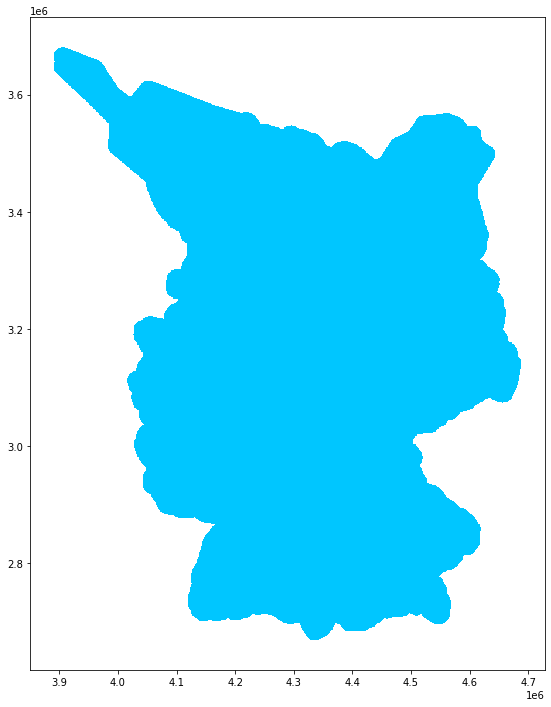

In [36]:
fig, ax = plt.subplots(figsize=(20, 12))
isl.plot(ax=ax)

In [19]:
min_youth = df_countries_youth['DEU'].population.quantile(0.4)

In [30]:
from folium.plugins import HeatMap

In [26]:
center = df_countries_youth['DEU'].loc[
    df_countries_youth['DEU'].population.idxmax(), 
    ['latitude', 'longitude']].compute()

In [27]:
m = folium.Map(location=center, control_scale=True, zoom_start=12)

In [ ]:
m.add_children(HeatMap(df_countries_youth['DEU'].loc[
    df_countries_youth['DEU'].population > min_youth].values.compute(),
    radius=8, max_zoom=13))

In [26]:
gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(df_countries_child['ISL'].longitude.compute(),
                                                   df_countries_child['ISL'].latitude.compute()))


In [43]:
df_countries_child['DEU'].compute()

,latitude,longitude,population
0,54.375139,9.085139,0.086284
1,54.377917,9.088750,0.086284
2,54.376528,9.079583,0.086284
3,54.378750,9.083194,0.086284
4,54.378750,9.087361,0.086284
...,...,...,...
32446523,49.924861,11.596250,0.110706
32446524,49.926806,11.566806,0.110706
32446525,49.907083,11.580417,0.110706
32446526,49.936528,11.549583,0.110706
